In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold, output, info

## directory where results are
CHANSEY_ROOT = "W:"
EXPERIMENT_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"
FIG_DIR = f"{TEAMS_DIR}/figs"
TAB_DIR = f"{TEAMS_DIR}/tables"

In [2]:
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']
TABLE_SCORE_PRECISION = 2
MIN_MAL = 15

In [3]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [6]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [7]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [8]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [9]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [10]:

attribute_valid_subgroups_1172 = cat_df0[cat_df0['Partial (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_1172 = list(attribute_valid_subgroups_1172[attribute_valid_subgroups_1172 < 2].index)

attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911), len(invalid_attributes_1172))
print("valid:", total_categorical_columns - len(invalid_attributes_5911), total_categorical_columns - len(invalid_attributes_1172))

invalid: 36 59
valid: 49 26


In [11]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [12]:
multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [13]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

Full Dataset (n=5911 Scans)  \
                                                                Malignant (n=581)   
category     attribute              value                                           
Demographics BMI                    < 25                               209 (36.0)   
                                    ≥ 25                               372 (64.0)   
             Education Status       8th grade or less                     9 (1.5)   
                                    9th-11th grade                       32 (5.5)   
                                    Associate Degree                   126 (21.7)   
...                                                                           ...   
Smoking      Total Years of Smoking Median (IQR)                          44 (10)   
             Pack-Years             Median (IQR)                          56 (39)   
Other        Nodules Per Scan       Median (IQR)                            2 (2)   
             Diameter (mm)          Median (IQR)                           12 (9)   
             Slices In Scan         Median (IQR)                         162 (40)   

                                                                       \
                                                      Benign (n=5330)   
category     attribute              value                               
Demographics BMI                    < 25                  1690 (31.7)   
                                    ≥ 25                  3640 (68.3)   
             Education Status       8th grade or less       102 (1.9)   
                                    9th-11th grade          258 (4.8)   
                                    Associate Degree      1175 (22.0)   
...                                                               ...   
Smoking      Total Years of Smoking Median (IQR)              41 (10)   
             Pack-Years             Median (IQR)              50 (28)   
Other        Nodules Per Scan       Median (IQR)                1 (1)   
             Diameter (mm)          Median (IQR)                6 (4)   
             Slices In Scan         Median (IQR)             160 (38)   

                                                      Partial Dataset (n=1172 Scans)  \
                                                                   Malignant (n=127)   
category     attribute              value                                              
Demographics BMI                    < 25                                   45 (35.4)   
                                    ≥ 25                                   82 (64.6)   
             Education Status       8th grade or less                        4 (3.1)   
                                    9th-11th grade                           2 (1.6)   
                                    Associate Degree                       31 (24.4)   
...                                                                              ...   
Smoking      Total Years of Smoking Median (IQR)                             44 (10)   
             Pack-Years             Median (IQR)                             64 (35)   
Other        Nodules Per Scan       Median (IQR)                               2 (1)   
             Diameter (mm)          Median (IQR)                              11 (9)   
             Slices In Scan         Median (IQR)                            162 (43)   

                                                                       
                                                      Benign (n=1045)  
category     attribute              value                              
Demographics BMI                    < 25                   326 (31.2)  
                                    ≥ 25                   719 (68.8)  
             Education Status       8th grade or less        23 (2.2)  
                                    9th-11th grade           65 (6.2)  
                                    Associate Degree       213 (20.4)  
...                            

In [14]:
df_out2 = df_out.xs('Demographics', level='category')
df_out2

Full Dataset (n=5911 Scans)  \
                                                         Malignant (n=581)   
attribute                  value                                             
BMI                        < 25                                 209 (36.0)   
                           ≥ 25                                 372 (64.0)   
Education Status           8th grade or less                       9 (1.5)   
                           9th-11th grade                         32 (5.5)   
                           Associate Degree                     126 (21.7)   
                           Bachelors Degree                      96 (16.5)   
                           Graduate School                       76 (13.1)   
                           HS Graduate / GED                    141 (24.3)   
                           Post-HS training                      87 (15.0)   
Gender                     Female                               244 (42.0)   
                           Male                                 337 (58.0)   
Married                    False                                197 (33.9)   
                           True                                 384 (66.1)   
HS Education               False                                   9 (1.5)   
                           True                                 572 (98.5)   
Non-Hispanic White         False                                  55 (9.5)   
                           True                                 526 (90.5)   
Unfinished Education Level False                                423 (72.8)   
                           True                                 158 (27.2)   
White or Black             Black                                  28 (4.8)   
                           White                                530 (91.2)   
Marital Status             Divorced                             125 (21.5)   
                           Married                              384 (66.1)   
                           Never Married                          16 (2.8)   
                           Separated                               5 (0.9)   
                           Widowed                                49 (8.4)   
Ethnicity                  Hispanic/Latino                         4 (0.7)   
                           Not Hispanic/Latino                  574 (98.8)   
Race                       Asian                                   6 (1.0)   
                           Black                                  28 (4.8)   
                           More than one race                      6 (1.0)   
                           Native American                         8 (1.4)   
                           Native Hawaiian                         1 (0.2)   
                           White                                530 (91.2)   
Body Mass Index            Median (IQR)                             26 (4)   
Age                        Median (IQR)                             64 (8)   
Height                     Median (IQR)                             68 (6)   
Weight                     Median (IQR)                           175 (50)   

                                                                \
                                               Benign (n=5330)   
attribute                  value                                 
BMI                        < 25                    1690 (31.7)   
                           ≥ 25                    3640 (68.3)   
Education Status           8th grade or less         102 (1.9)   
                           9th-11th grade            258 (4.8)   
                           Associate Degree        1175 (22.0)   
                           Bachelors Degree         817 (15.3)   
                           Graduate School          778 (14.6)   
                           HS Graduate / GED       1338 (25.1)   
                           Post-HS training         765 (14.4)   
Gender                     Female                  2226 

In [15]:
print(df_out2.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [16]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, info.DLCST_DEMOCOLS)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [17]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [18]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [19]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Gender               Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Gender               Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Gender               Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Gender               Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [20]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [21]:
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=output.DLCST_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

In [22]:
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=output.NLST_1172_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [23]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=output.NLST_5911_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [24]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies = combined_policies[combined_policies.index != 'De Haas Global (Shown Nodule)']
combined_policies

DLCST (n=599)                  NLST Partial (n=1172)  \
                 90\% Sensitivity 90\% Specificity      90\% Sensitivity   
Venkadesh                   0.134            0.204                 0.026   
Sybil (Year 1)              0.001            0.018                 0.003   
PanCan2b                    0.020            0.093                 0.014   
De Haas Local                 NaN              NaN                 0.049   
De Haas Global                NaN              NaN                 0.060   
De Haas Combined            0.099            0.193                 0.069   

                                  NLST Full (n=5911)                   
                 90\% Specificity   90\% Sensitivity 90\% Specificity  
Venkadesh                   0.229              0.048            0.220  
Sybil (Year 1)              0.058              0.003            0.058  
PanCan2b                    0.168              0.015            0.165  
De Haas Local               0.214              0.044            0.212  
De Haas Global              0.235              0.066            0.241  
De Haas Combined            0.261                NaN              NaN

In [25]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

## ROC Tables

### DLCST

In [27]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_18052\2578401092.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh         De Haas Combined        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.92 (0.87, 0.97)  None  0.91 (0.85, 0.96)  None   
          ≤ 61    0.92 (0.85, 0.97)   .99  0.92 (0.86, 0.97)   .78   
Gender    Male    0.91 (0.84, 0.96)  None  0.90 (0.84, 0.96)  None   
          Female  0.94 (0.91, 0.97)   .44  0.95 (0.91, 0.98)   .37   

                     Sybil (Year 1)                 PanCan2b        
                            ROC AUC     p            ROC AUC     p  
Attribute Group                                                     
Age       > 61    0.86 (0.78, 0.94)  None  0.85 (0.79, 0.91)  None  
          ≤ 61    0.86 (0.78, 0.93)   .98  0.90 (0.84, 0.95)   .46  
Gender    Male    0.87 (0.78, 0.94)  None  0.91 (0.86, 0.95)  None  
          Female  0.86 (0.78, 0.93)   .88  0.86 (0.79, 0.92)   .35

In [28]:
print(dlcst_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST (for Tijmen's combined model only.)

In [29]:
nlst_demos_to_include = ['Age', 'Gender', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']

In [30]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)

nlst_tijmen_scan_out = output.roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_1172')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_18052\104166115.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = output.roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined            De Haas Local        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.86 (0.82, 0.90)  None  0.85 (0.81, 0.90)  None   
          ≤ 61    0.88 (0.82, 0.92)   .73  0.88 (0.83, 0.93)   .45   
BMI       ≥ 25    0.87 (0.83, 0.90)  None  0.87 (0.83, 0.91)  None   
          < 25    0.87 (0.82, 0.92)   .91  0.85 (0.79, 0.90)   .57   
Gender    Male    0.87 (0.84, 0.91)  None  0.87 (0.82, 0.91)  None   
          Female  0.86 (0.80, 0.91)   .69  0.87 (0.81, 0.91)   .98   
Height    > 68    0.87 (0.83, 0.91)  None  0.86 (0.82, 0.91)  None   
          ≤ 68    0.87 (0.82, 0.92)   .91  0.87 (0.83, 0.92)   .83   
Weight    ≤ 180   0.86 (0.82, 0.90)  None  0.86 (0.82, 0.90)  None   
          > 180   0.87 (0.83, 0.91)   .83  0.87 (0.82, 0.92)   .71   

                     De Haas Global        
                            ROC AUC     p  
Attribute Group                            
Age       > 61    0.77 (0.73, 0.82)  None  
          ≤ 61    0.77 (0.71, 0.82)   .91  
BMI       ≥ 25    0.78 (0.74, 0.82)  None  
          < 25    0.75 (0.68, 0.81)   .49  
Gender    Male    0.80 (0.75, 0.84)  None  
          Female  0.72 (0.66, 0.78)   .13  
Height    > 68    0.79 (0.74, 0.84)  None  
          ≤ 68    0.75 (0.69, 0.81)   .39  
Weight    ≤ 180   0.74 (0.69, 0.79)  None  
          > 180   0.80 (0.75, 0.85)   .17

In [31]:
print(nlst_tijmen_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|ll"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [32]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh',    'de Haas Local', 'de Haas Global (hidden nodule)', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_18052\1823227323.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh            De Haas Local        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.88 (0.86, 0.90)  None  0.86 (0.85, 0.88)  None   
          ≤ 61    0.90 (0.88, 0.92)   .14  0.88 (0.86, 0.91)   .33   
BMI       ≥ 25    0.90 (0.88, 0.91)  None  0.87 (0.85, 0.89)  None   
          < 25    0.88 (0.85, 0.90)   .32  0.87 (0.85, 0.90)   .91   
Gender    Male    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)  None   
          Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)   .40   
Height    ≤ 68    0.89 (0.87, 0.91)  None  0.88 (0.86, 0.90)  None   
          > 68    0.88 (0.86, 0.91)   .67  0.86 (0.84, 0.89)   .35   
Race      White   0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
          Black   0.82 (0.74, 0.89)   .14  0.81 (0.72, 0.89)   .21   
Weight    ≤ 180   0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)  None   
          > 180   0.89 (0.87, 0.91)   .65  0.87 (0.85, 0.89)   .95   

                     De Haas Global           Sybil (Year 1)          \
                            ROC AUC     p            ROC AUC       p   
Attribute Group                                                        
Age       > 61    0.79 (0.77, 0.81)  None  0.84 (0.82, 0.86)    None   
          ≤ 61    0.81 (0.79, 0.83)   .30  0.85 (0.82, 0.88)     .67   
BMI       ≥ 25    0.80 (0.78, 0.82)  None  0.86 (0.84, 0.88)    None   
          < 25    0.79 (0.76, 0.82)   .63  0.81 (0.78, 0.85)     .05   
Gender    Male    0.81 (0.80, 0.83)  None  0.81 (0.78, 0.84)    None   
          Female  0.77 (0.74, 0.80)   .05  0.88 (0.86, 0.90)  < .001   
Height    ≤ 68    0.79 (0.76, 0.81)  None  0.87 (0.85, 0.89)    None   
          > 68    0.80 (0.78, 0.83)   .48  0.80 (0.77, 0.83)  < .001   
Race      White   0.80 (0.78, 0.81)  None  0.84 (0.83, 0.86)    None   
          Black   0.83 (0.76, 0.90)   .45  0.83 (0.74, 0.90)     .77   
Weight    ≤ 180   0.78 (0.75, 0.80)  None  0.84 (0.82, 0.87)    None   
          > 180   0.82 (0.79, 0.84)   .05  0.84 (0.81, 0.87)     .82   

                           PanCan2b        
                            ROC AUC     p  
Attribute Group                            
Age       > 61    0.76 (0.74, 0.79)  None  
          ≤ 61    0.81 (0.78, 0.83)   .05  
BMI       ≥ 25    0.81 (0.79, 0.83)  None  
          < 25    0.73 (0.70, 0.77)  .001  
Gender    Male    0.79 (0.76, 0.81)  None  
          Female  0.78 (0.75, 0.81)   .66  
Height    ≤ 68    0.79 (0.76, 0.81)  None  
          > 68    0.78 (0.75, 0.80)   .71  
Race      White   0.78 (0.76, 0.80)  None  
          Black   0.75 (0.65, 0.83)   .54  
Weight    ≤ 180   0.77 (0.74, 0.79)  None  
          > 180   0.80 (0.77, 0.82)   .13

In [33]:
print(nlst_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values. Sybil has significant demographic biases against men, people above 68 inches tall, and married indivivduals.'))

None


## Threshold Utilities

In [35]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, info.DLCST_DEMOCOLS)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = output.threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [36]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = output.threshold_stats_pretty(threshold_nlst_1172, nlst_1172_policies)

In [37]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = output.threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

## Threshold Plots

### DLCST

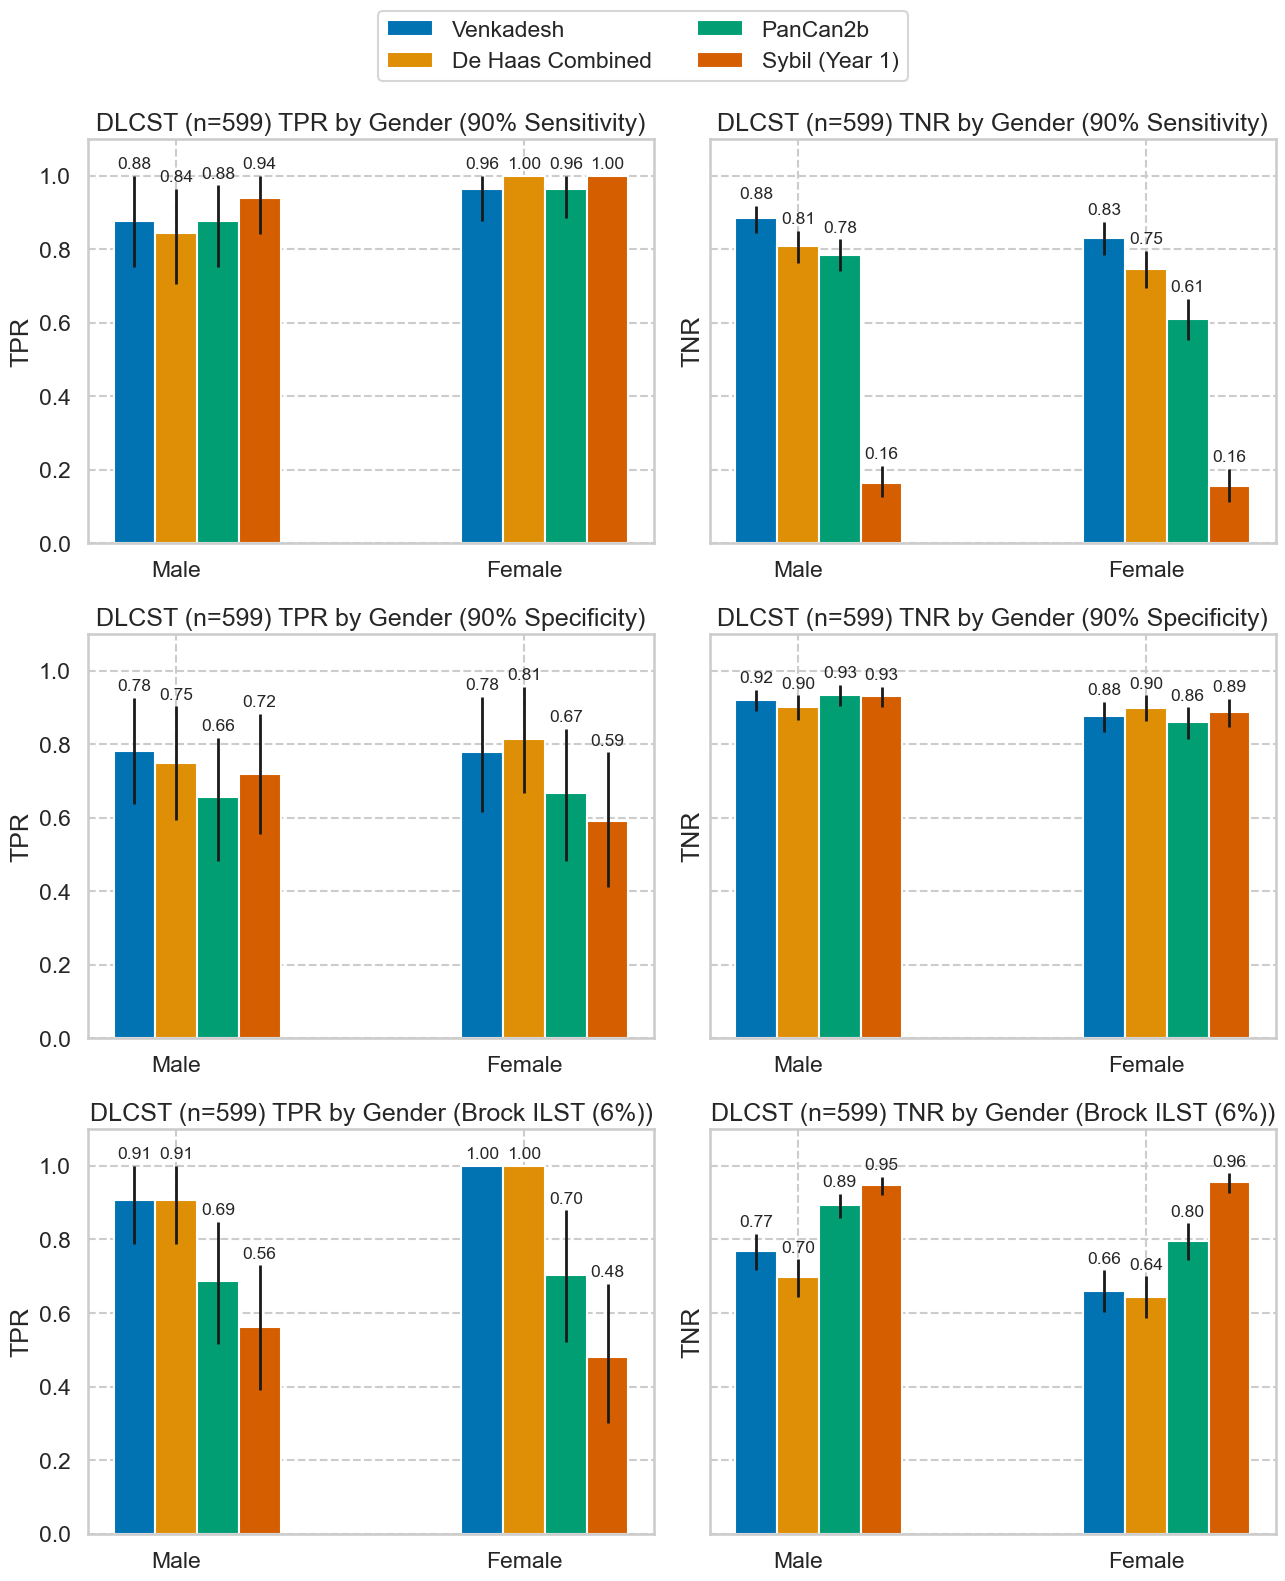

In [38]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

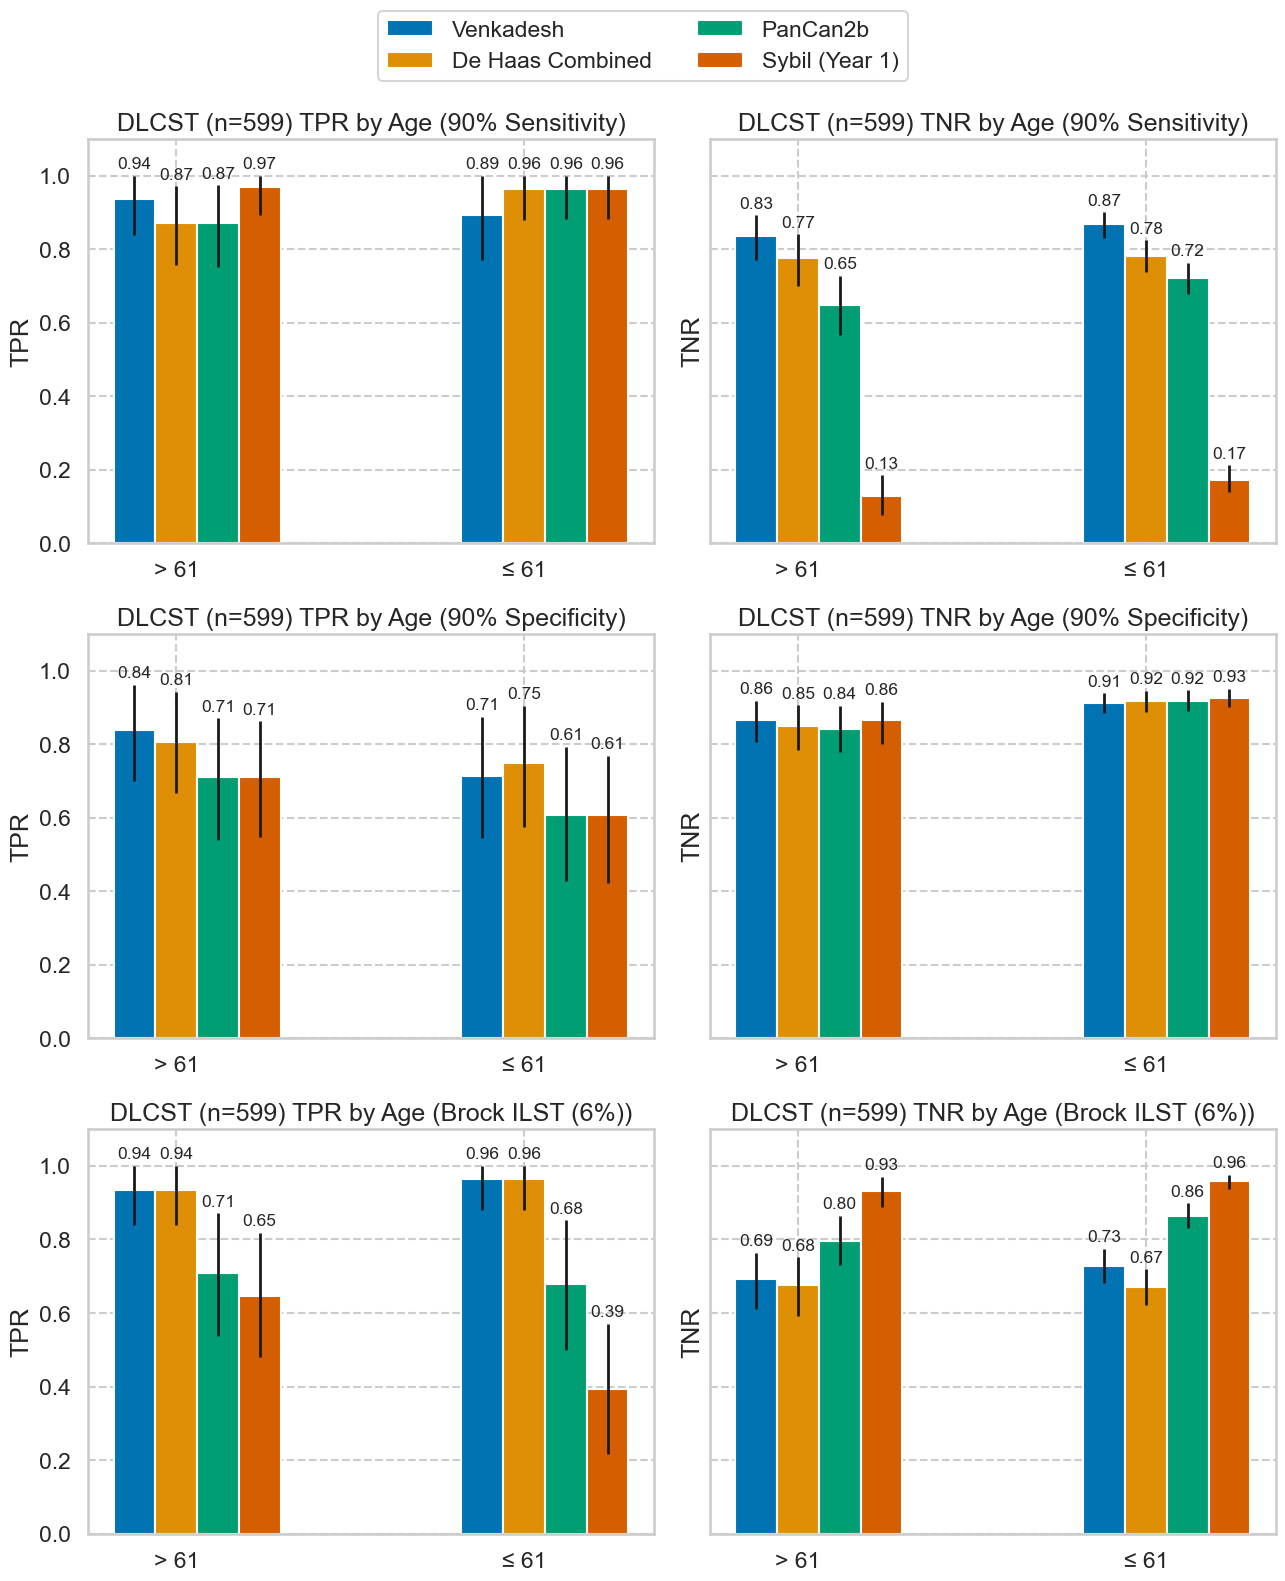

In [39]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

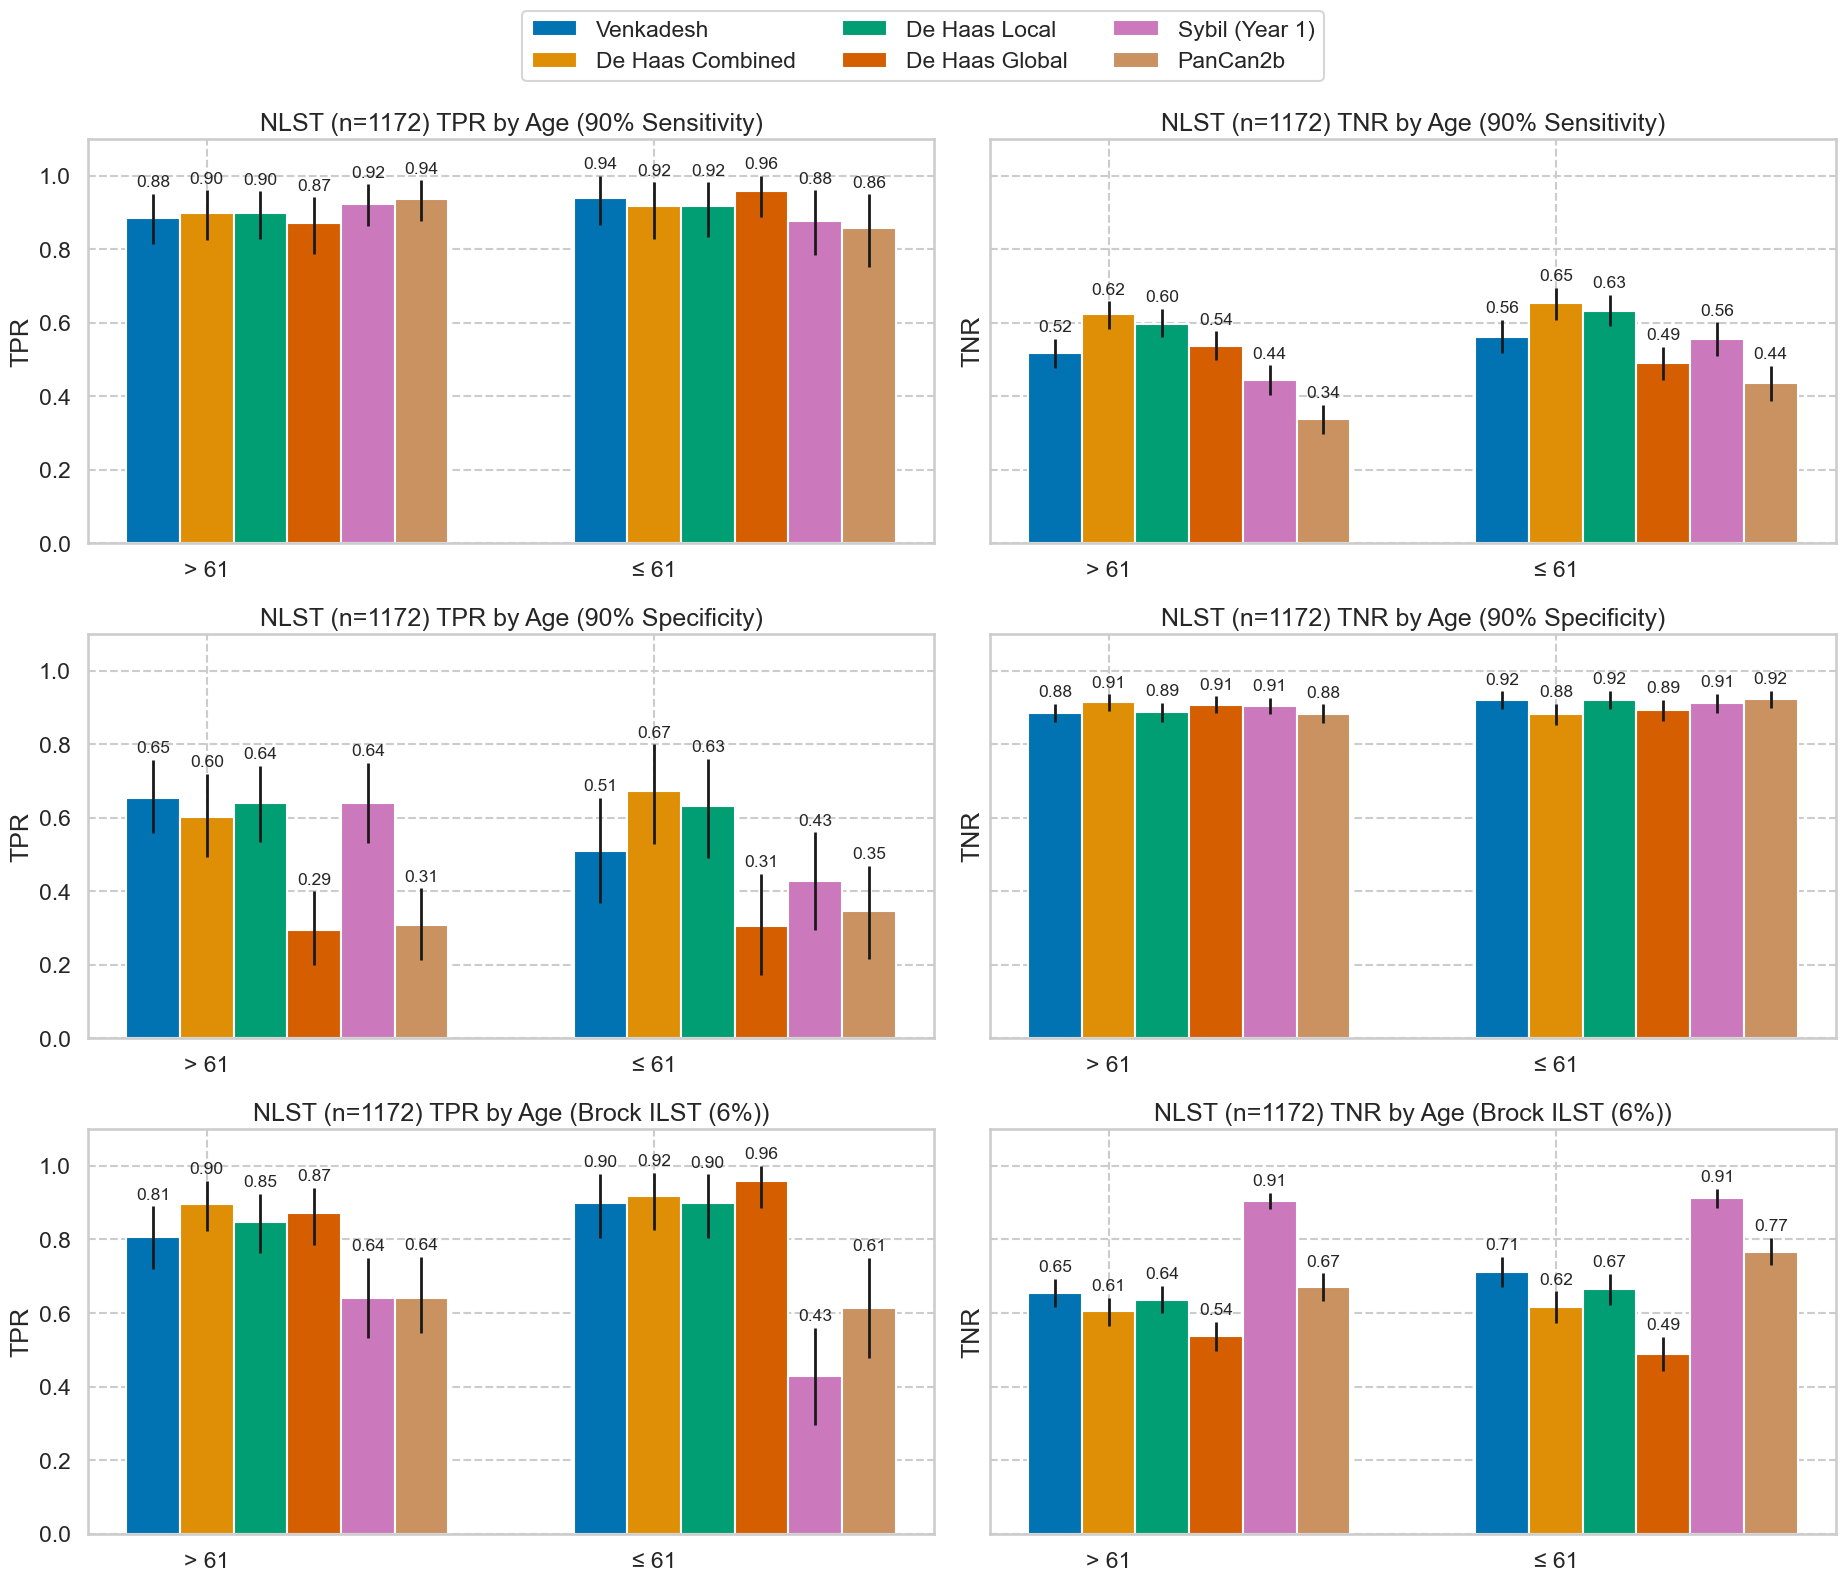

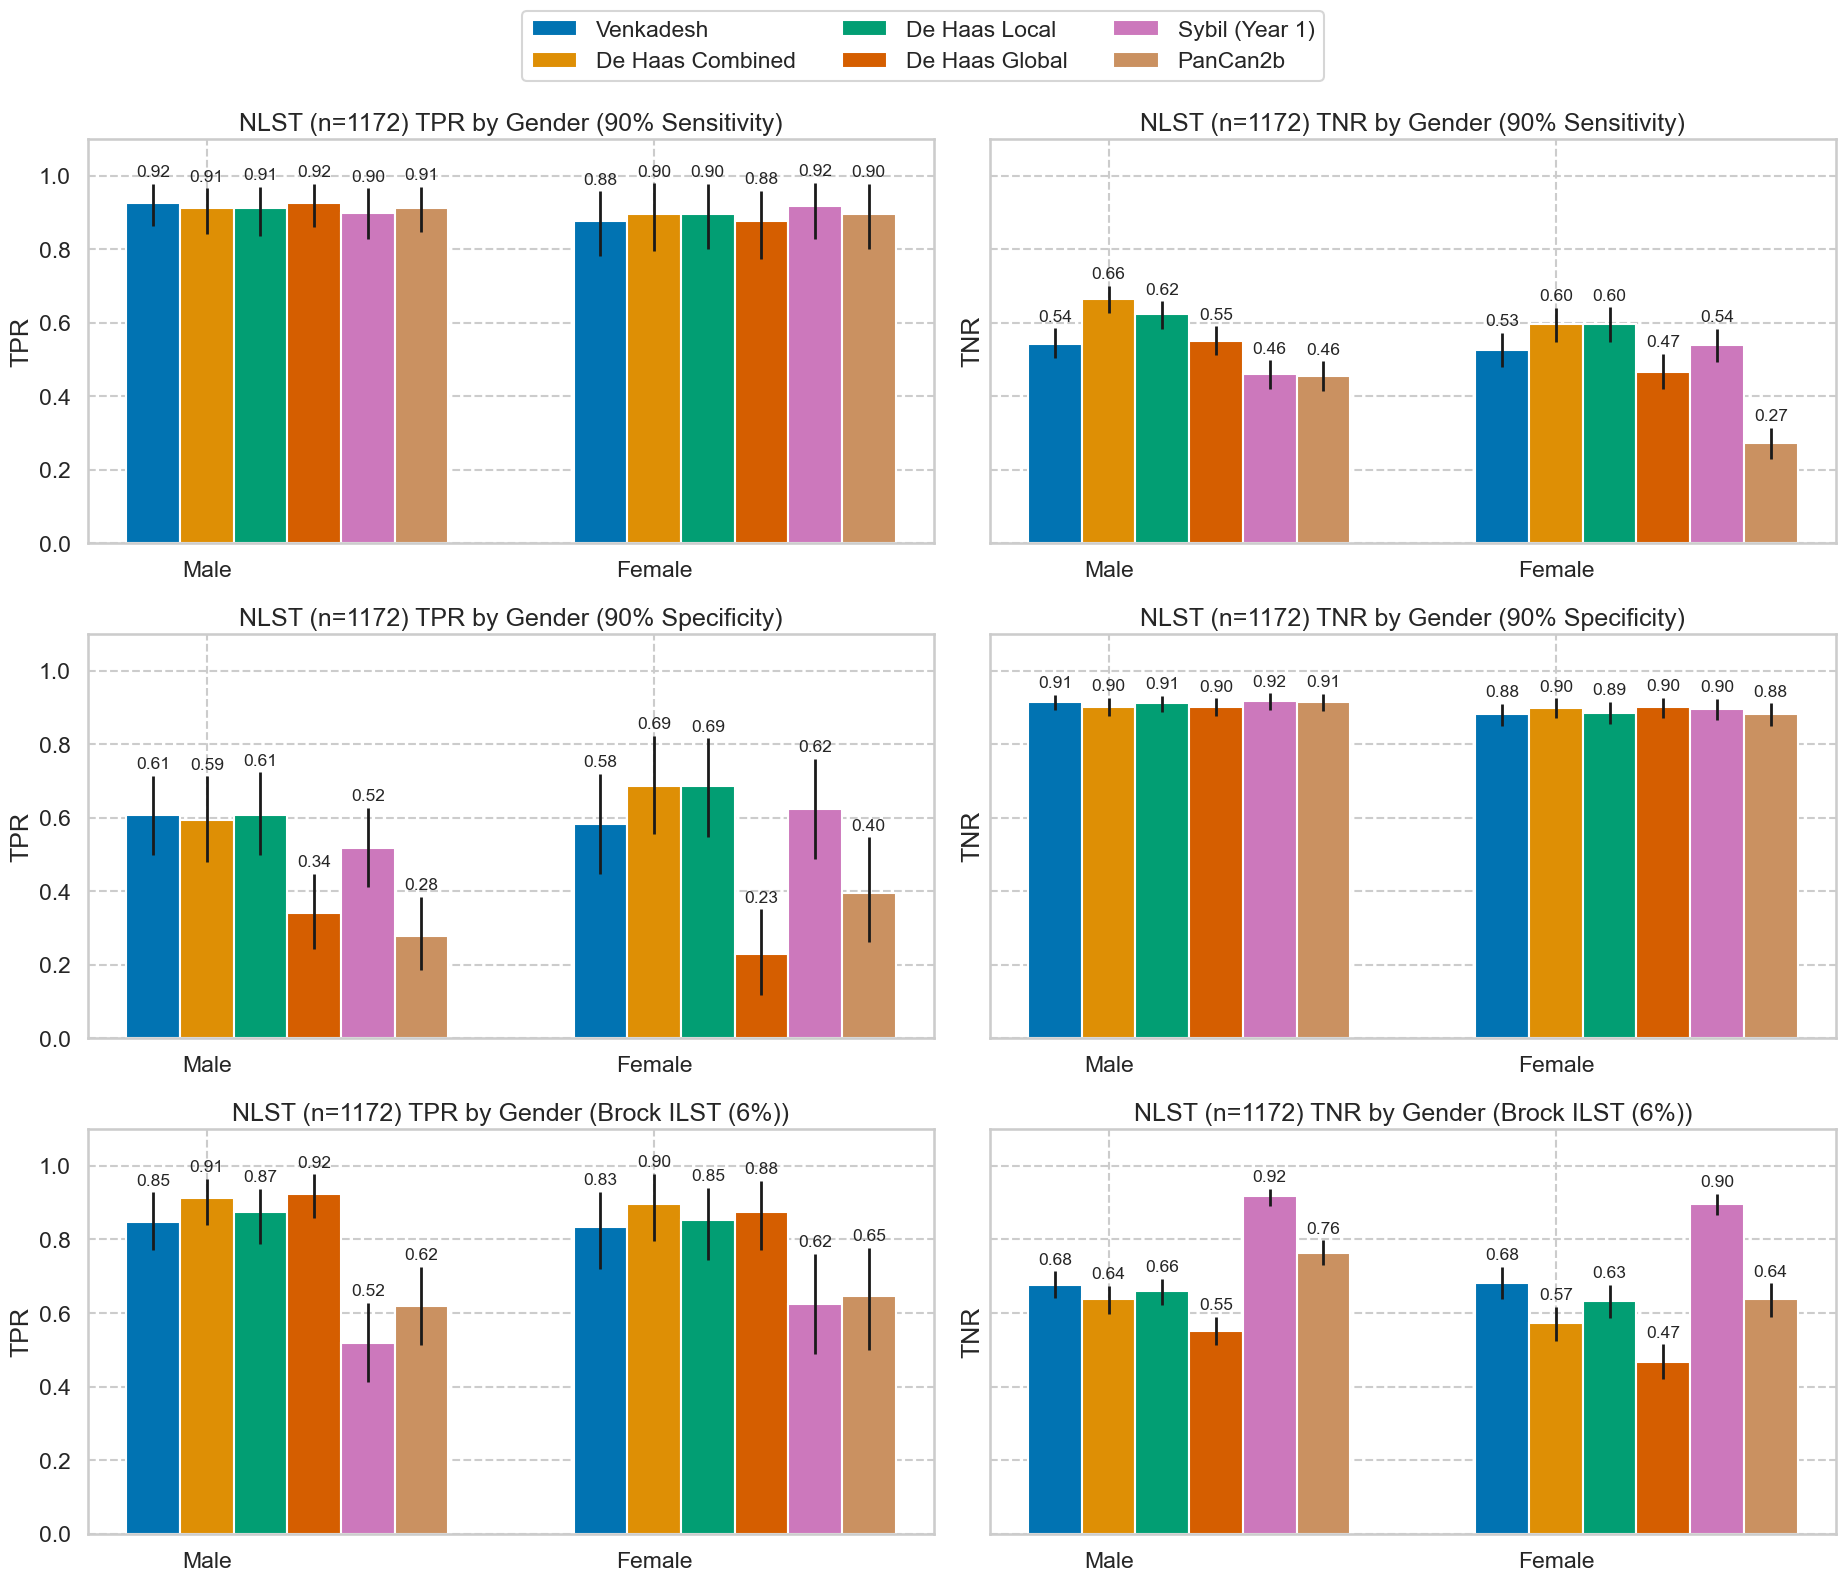

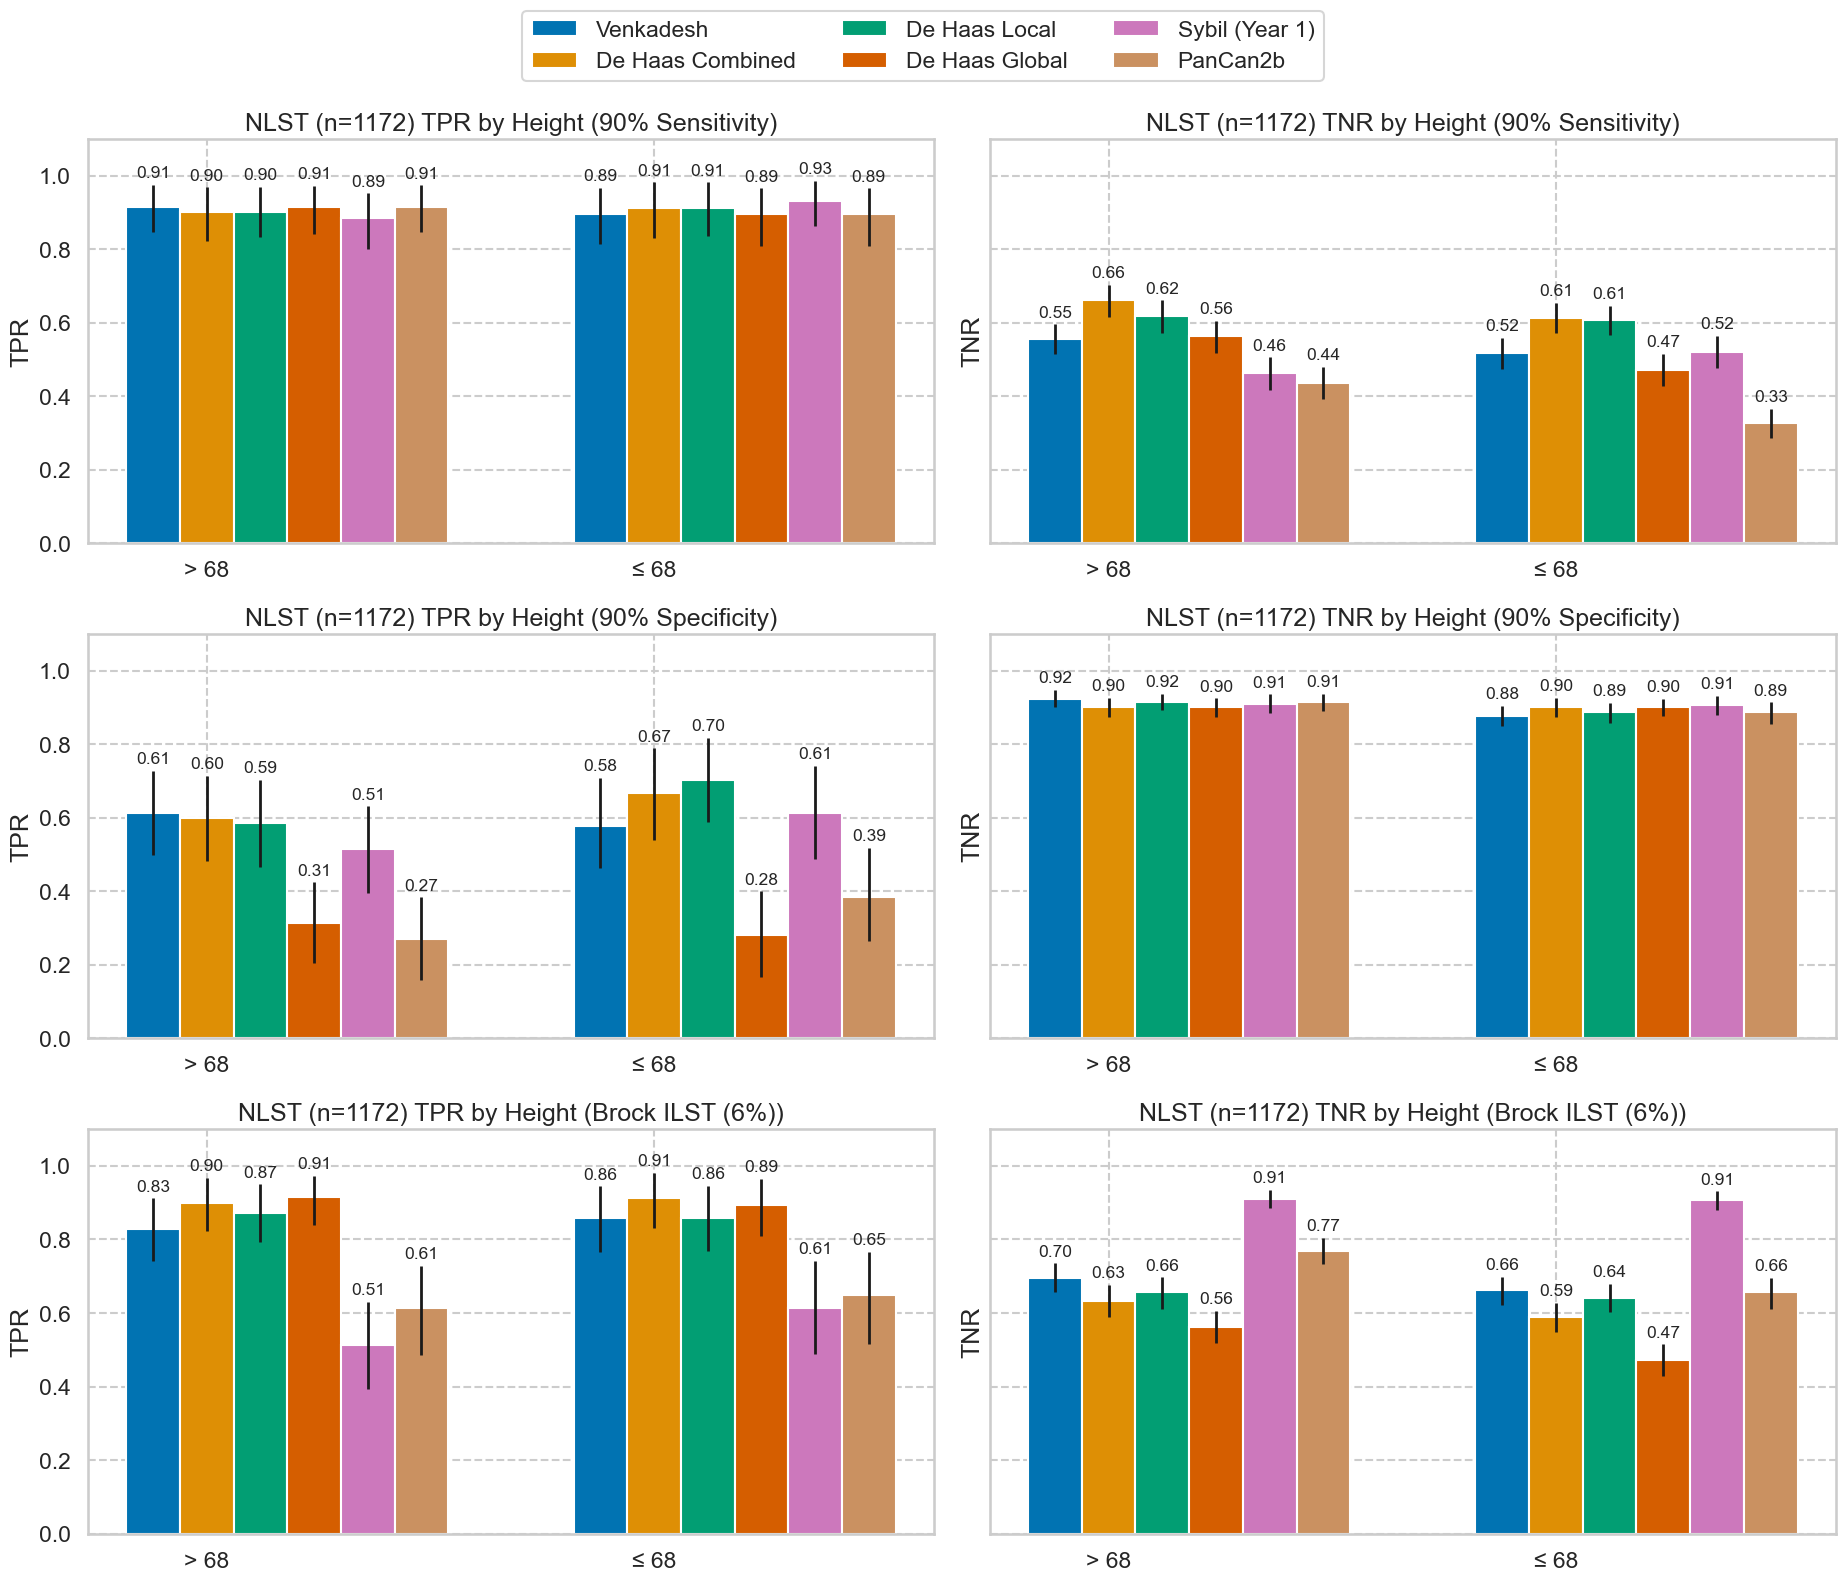

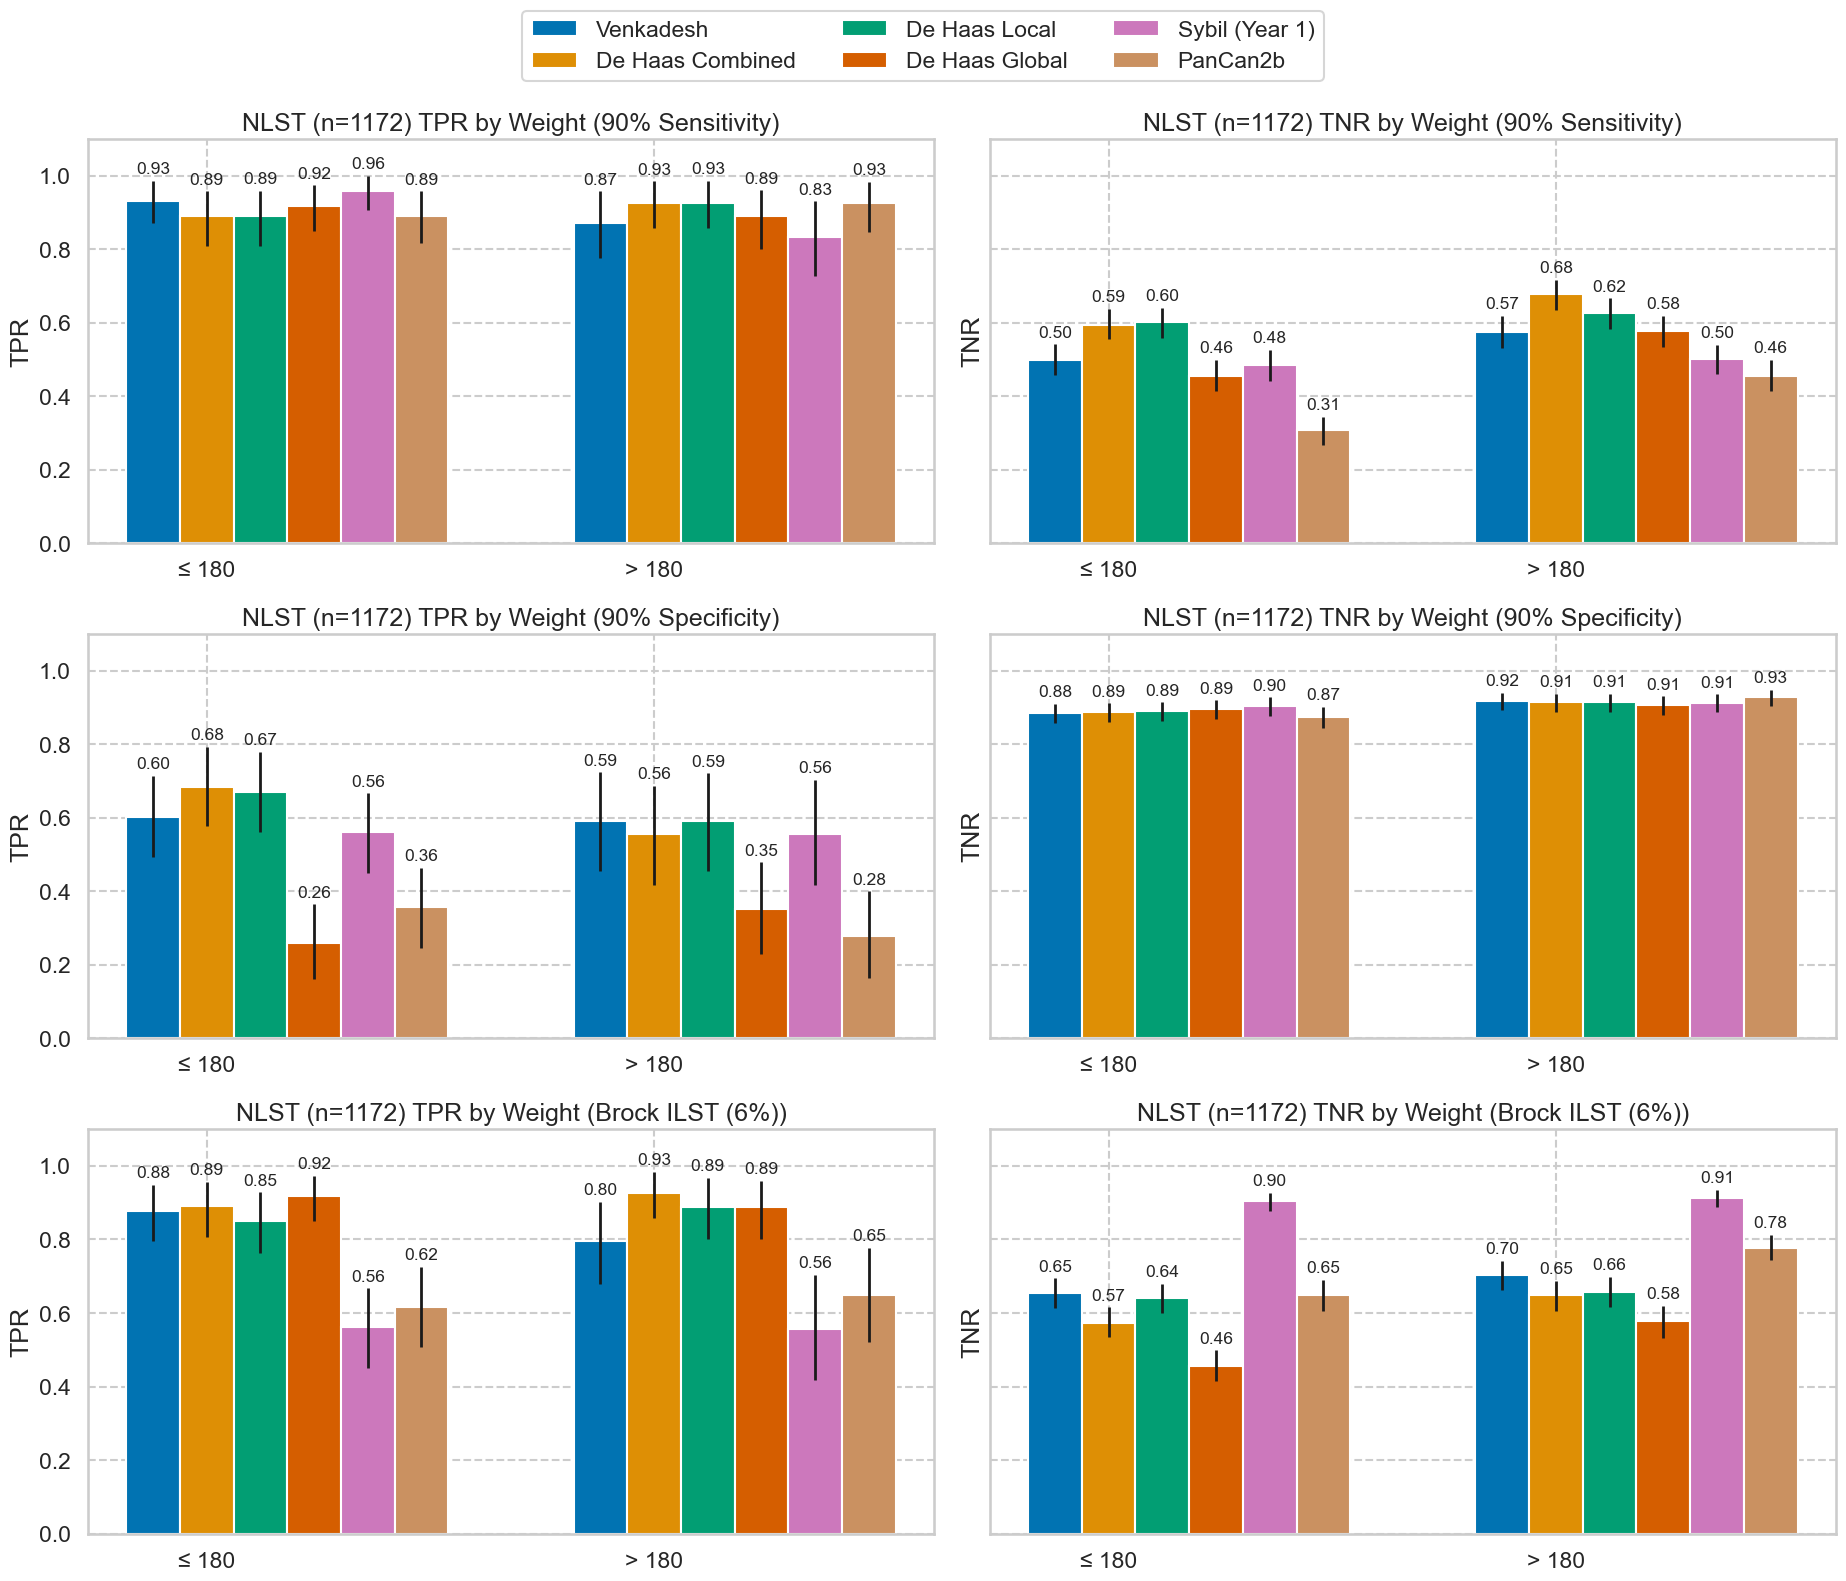

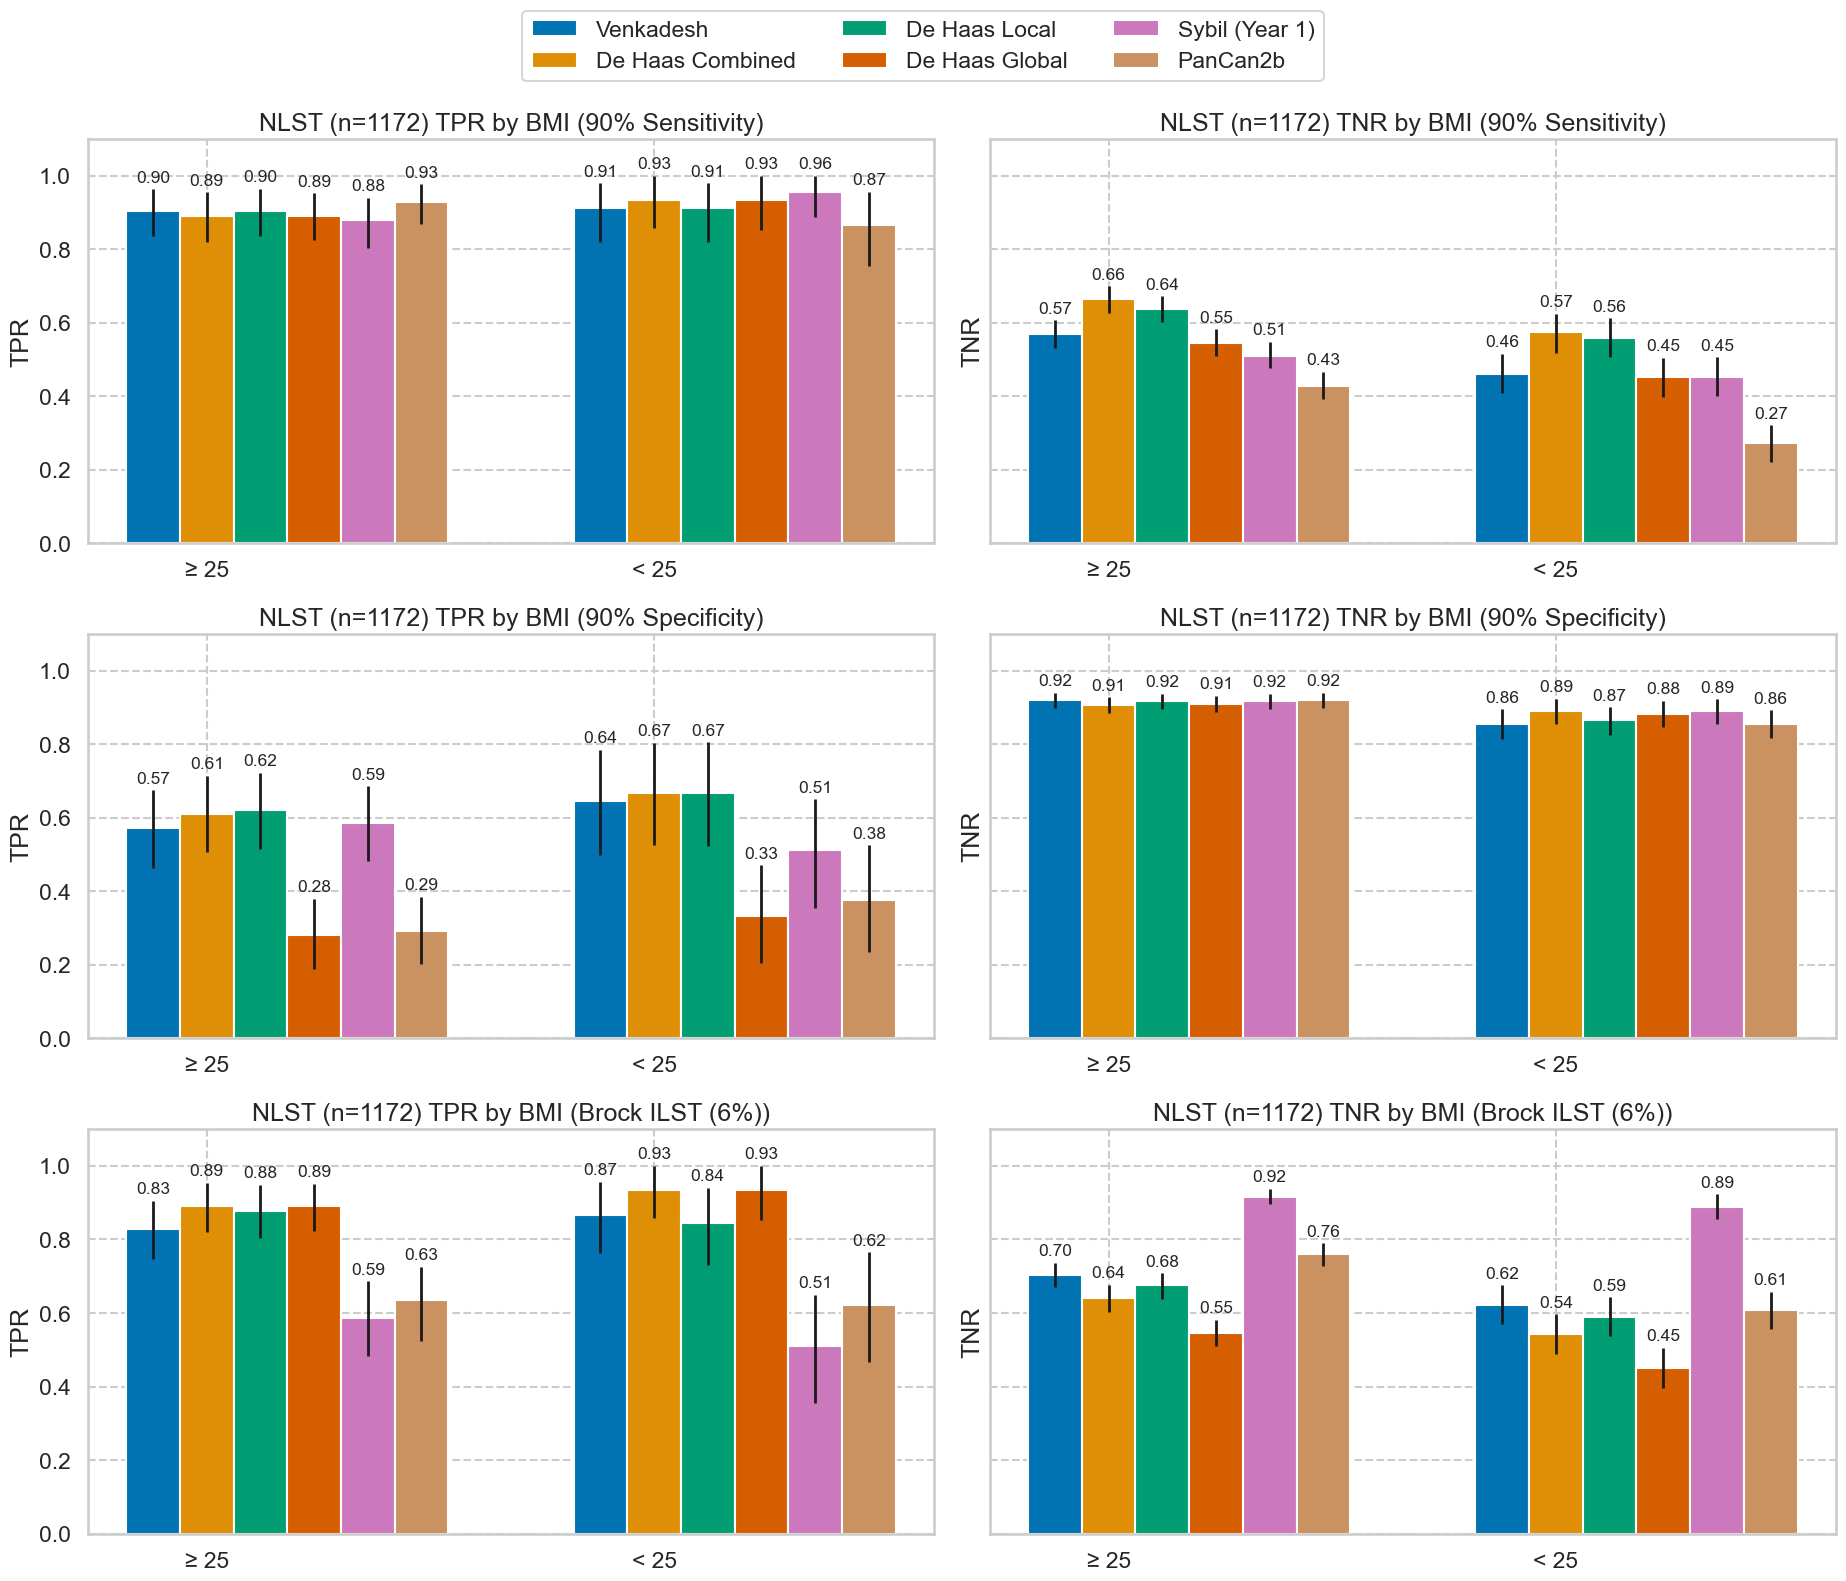

In [40]:
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
                                                policies=nlst_1172_policies, models=output.NLST_1172_MODELCOLS, 
                                                stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
                                                )  

### NLST 5911


['Age', 'Gender', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']


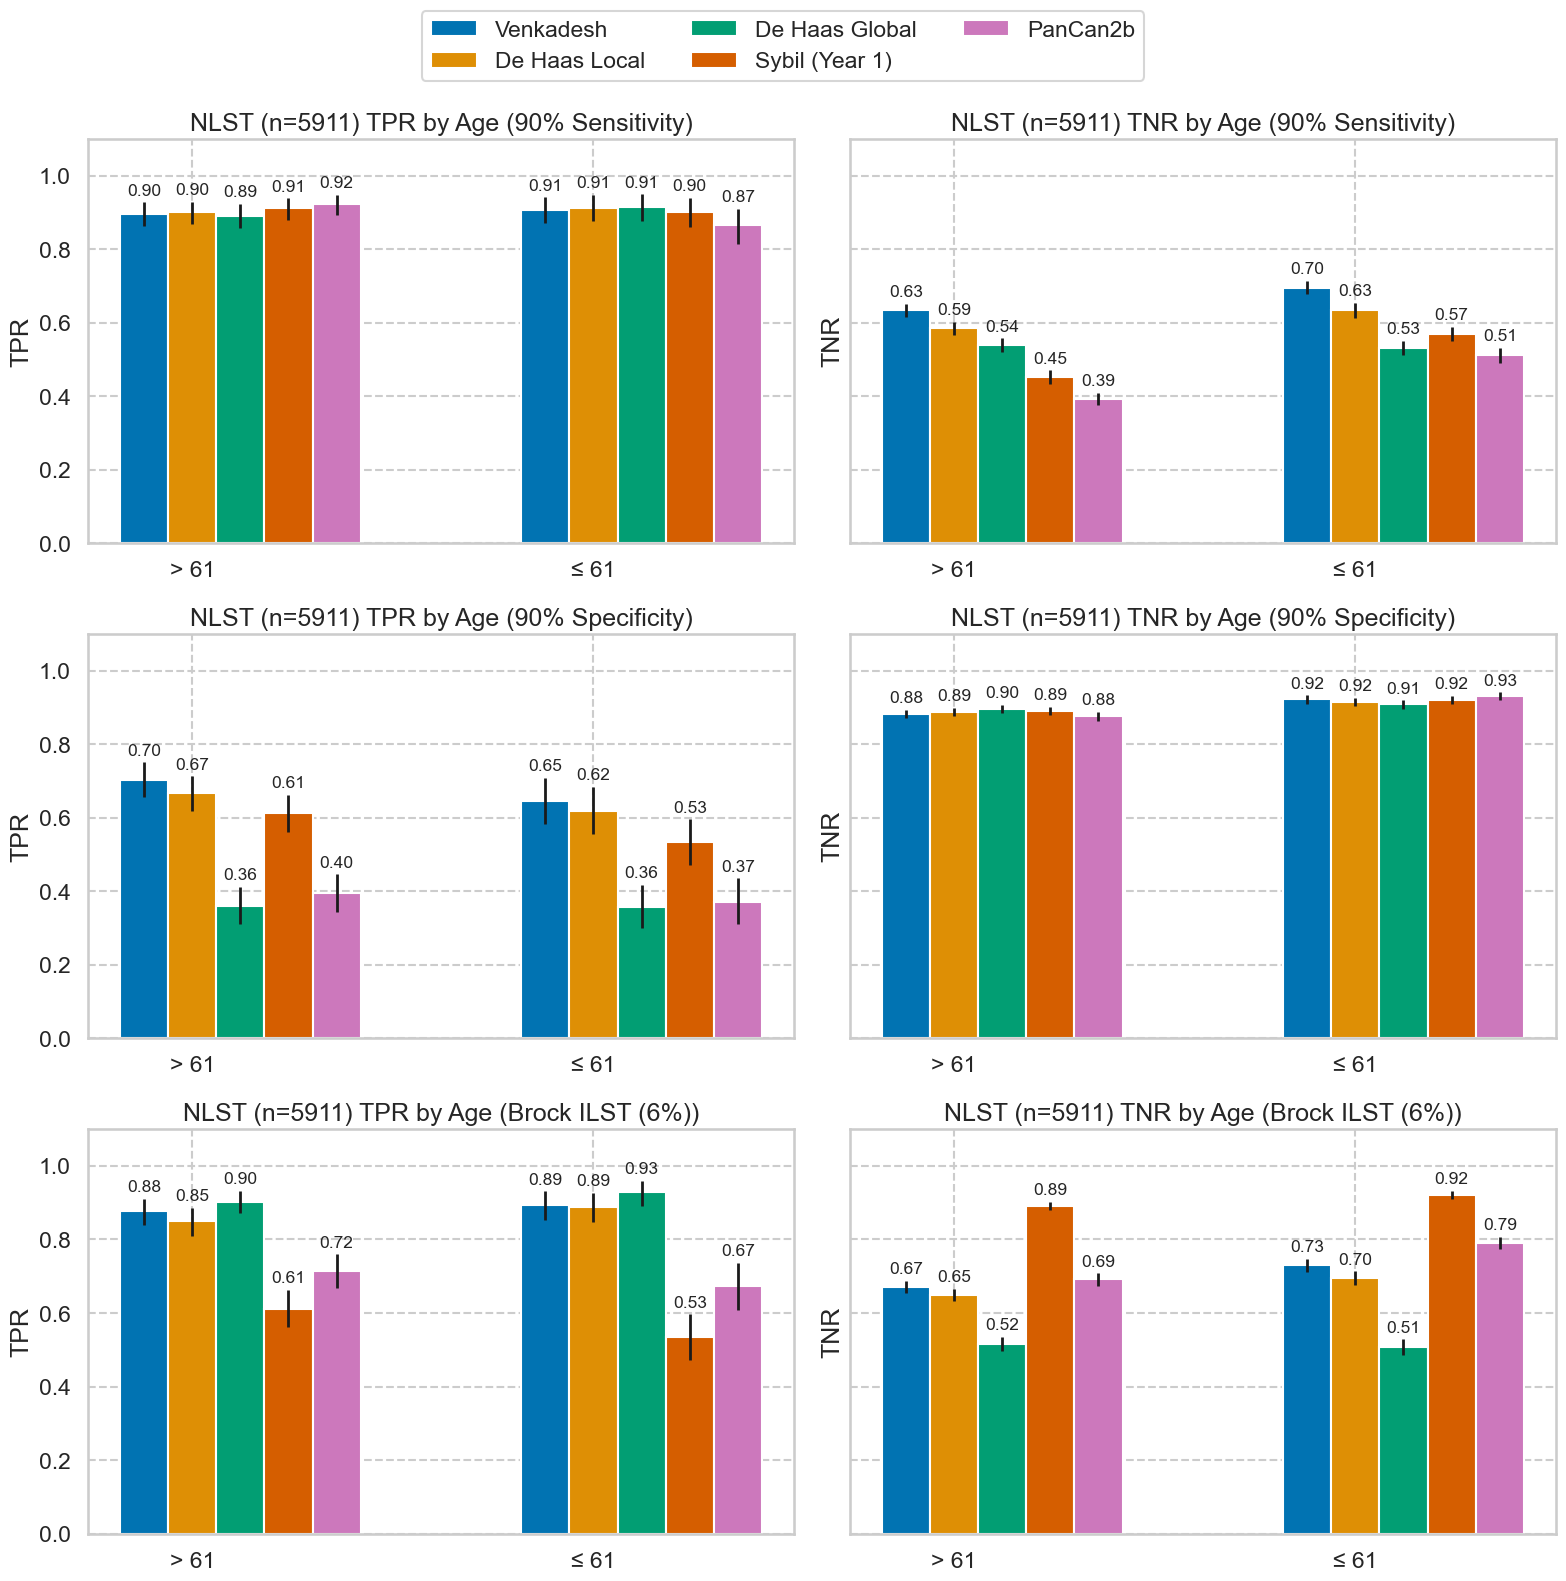

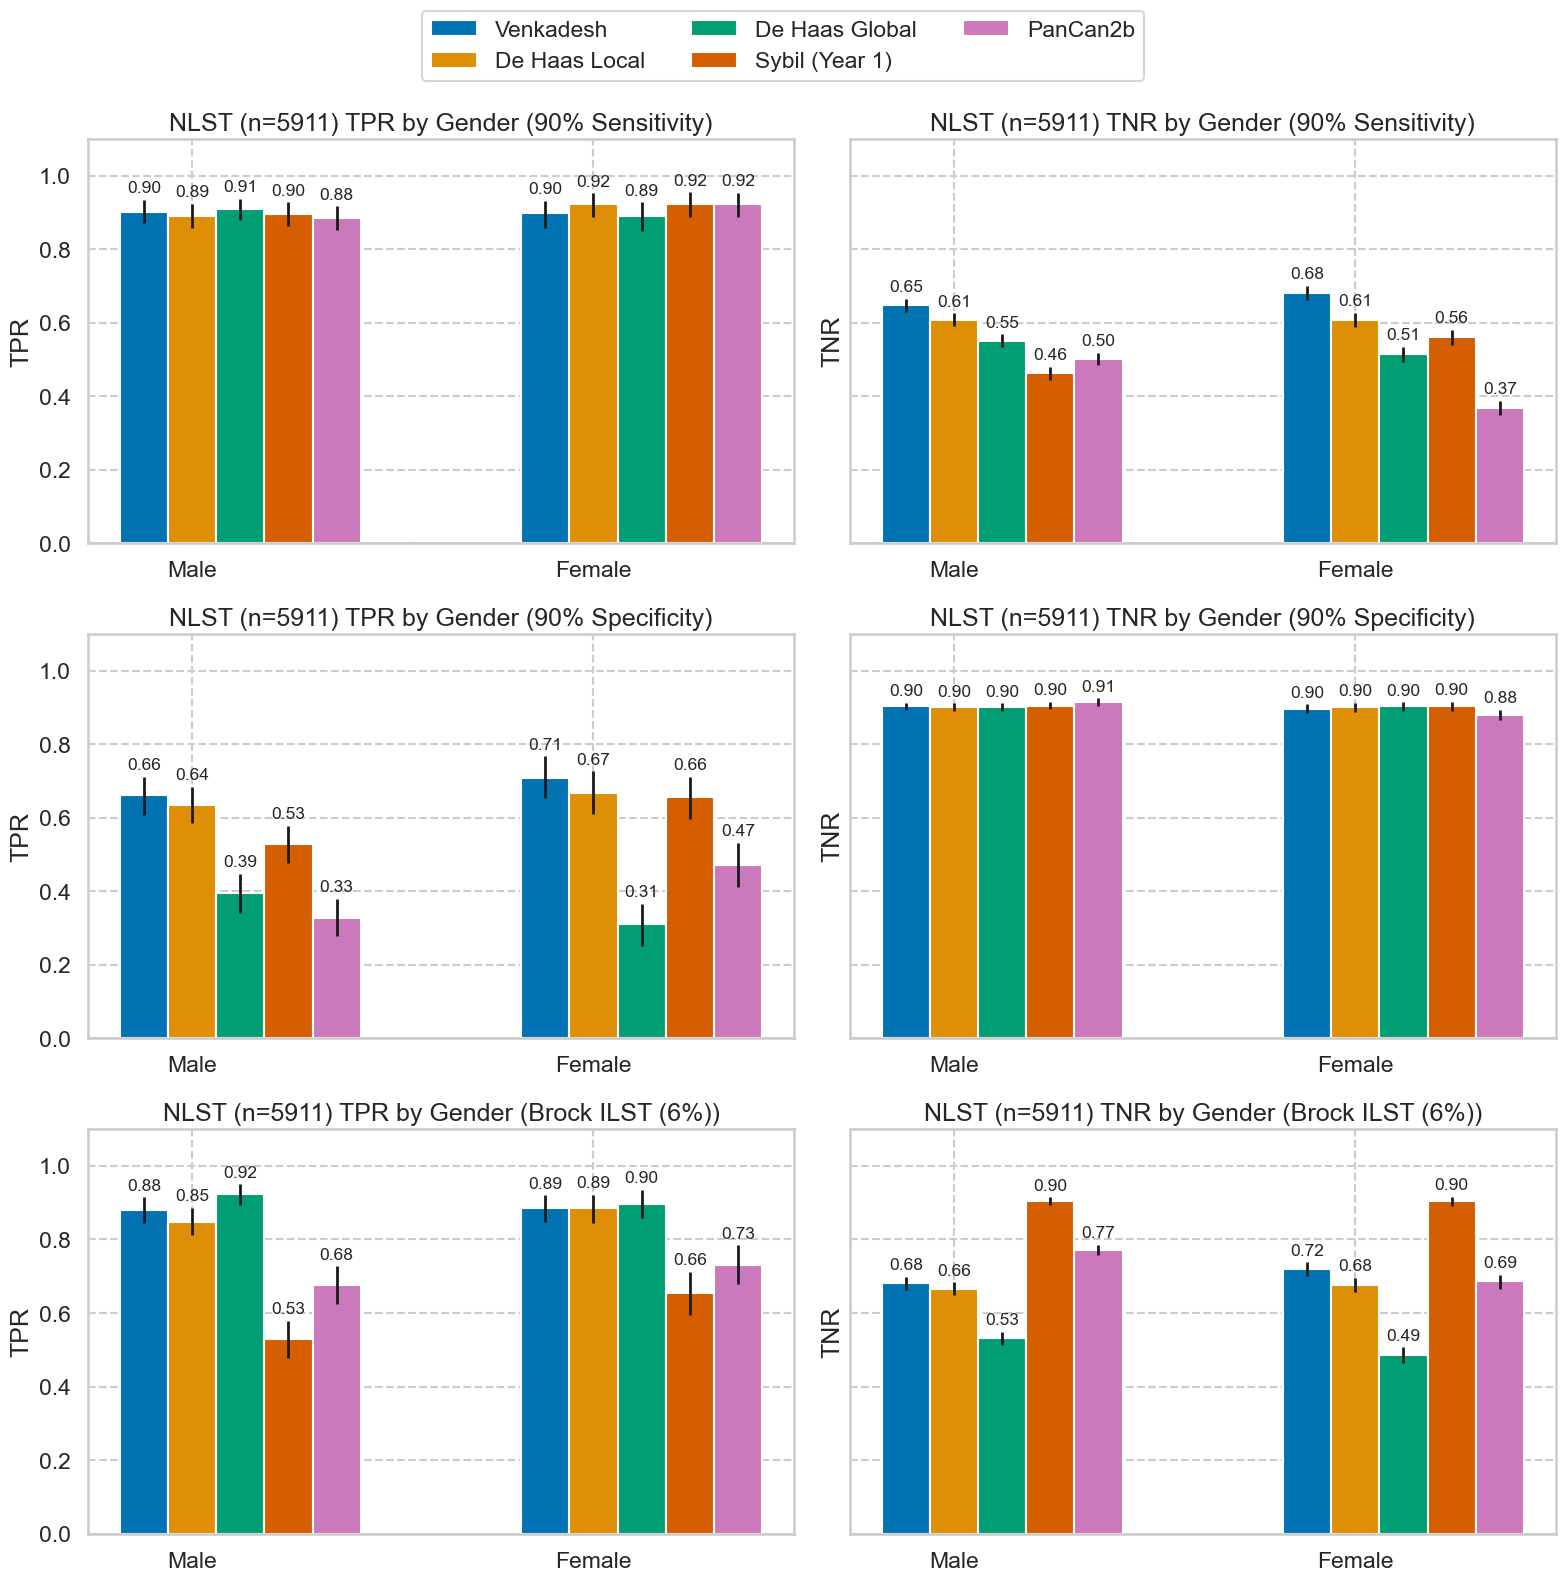

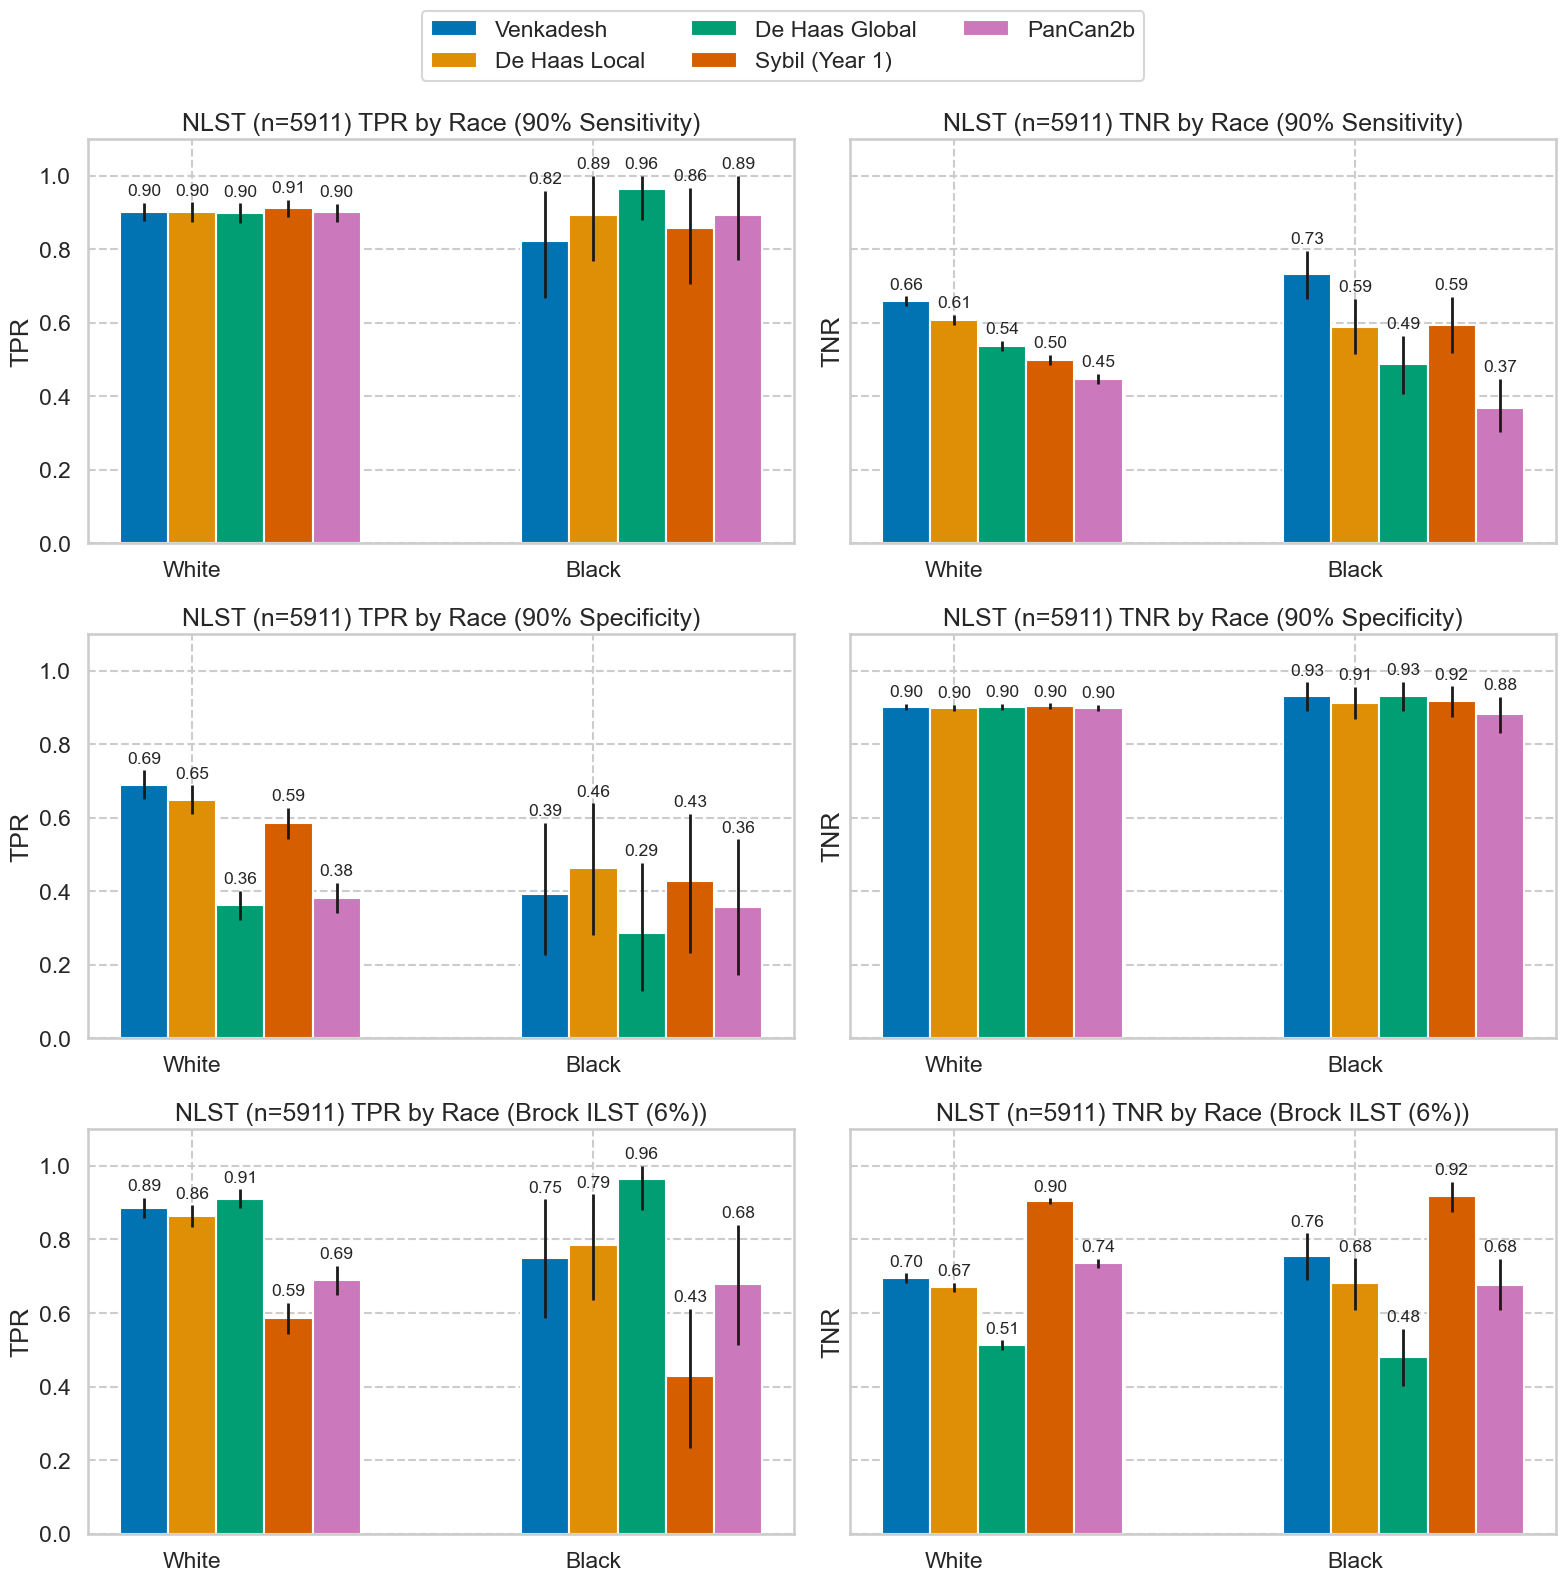

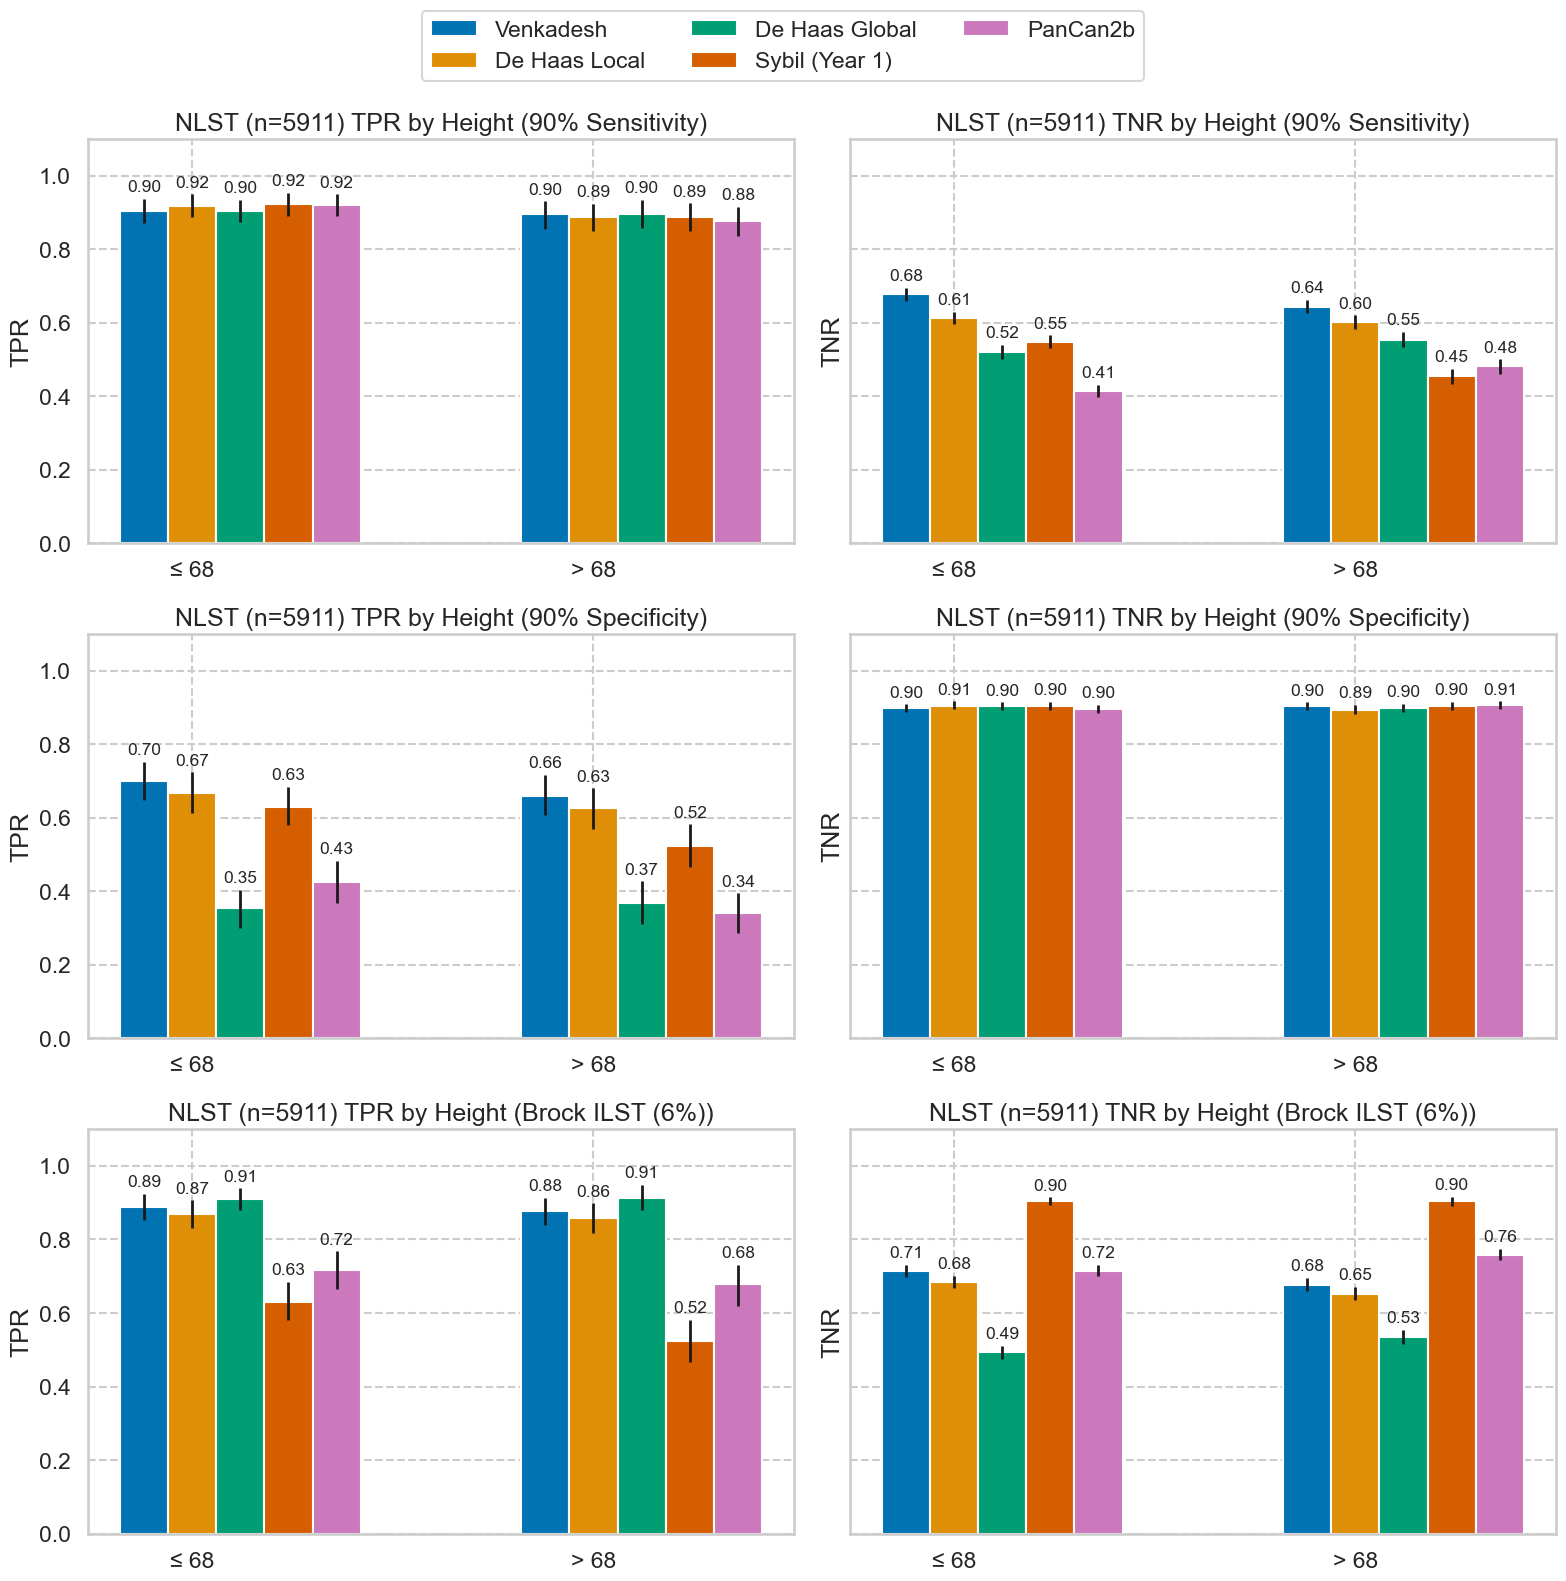

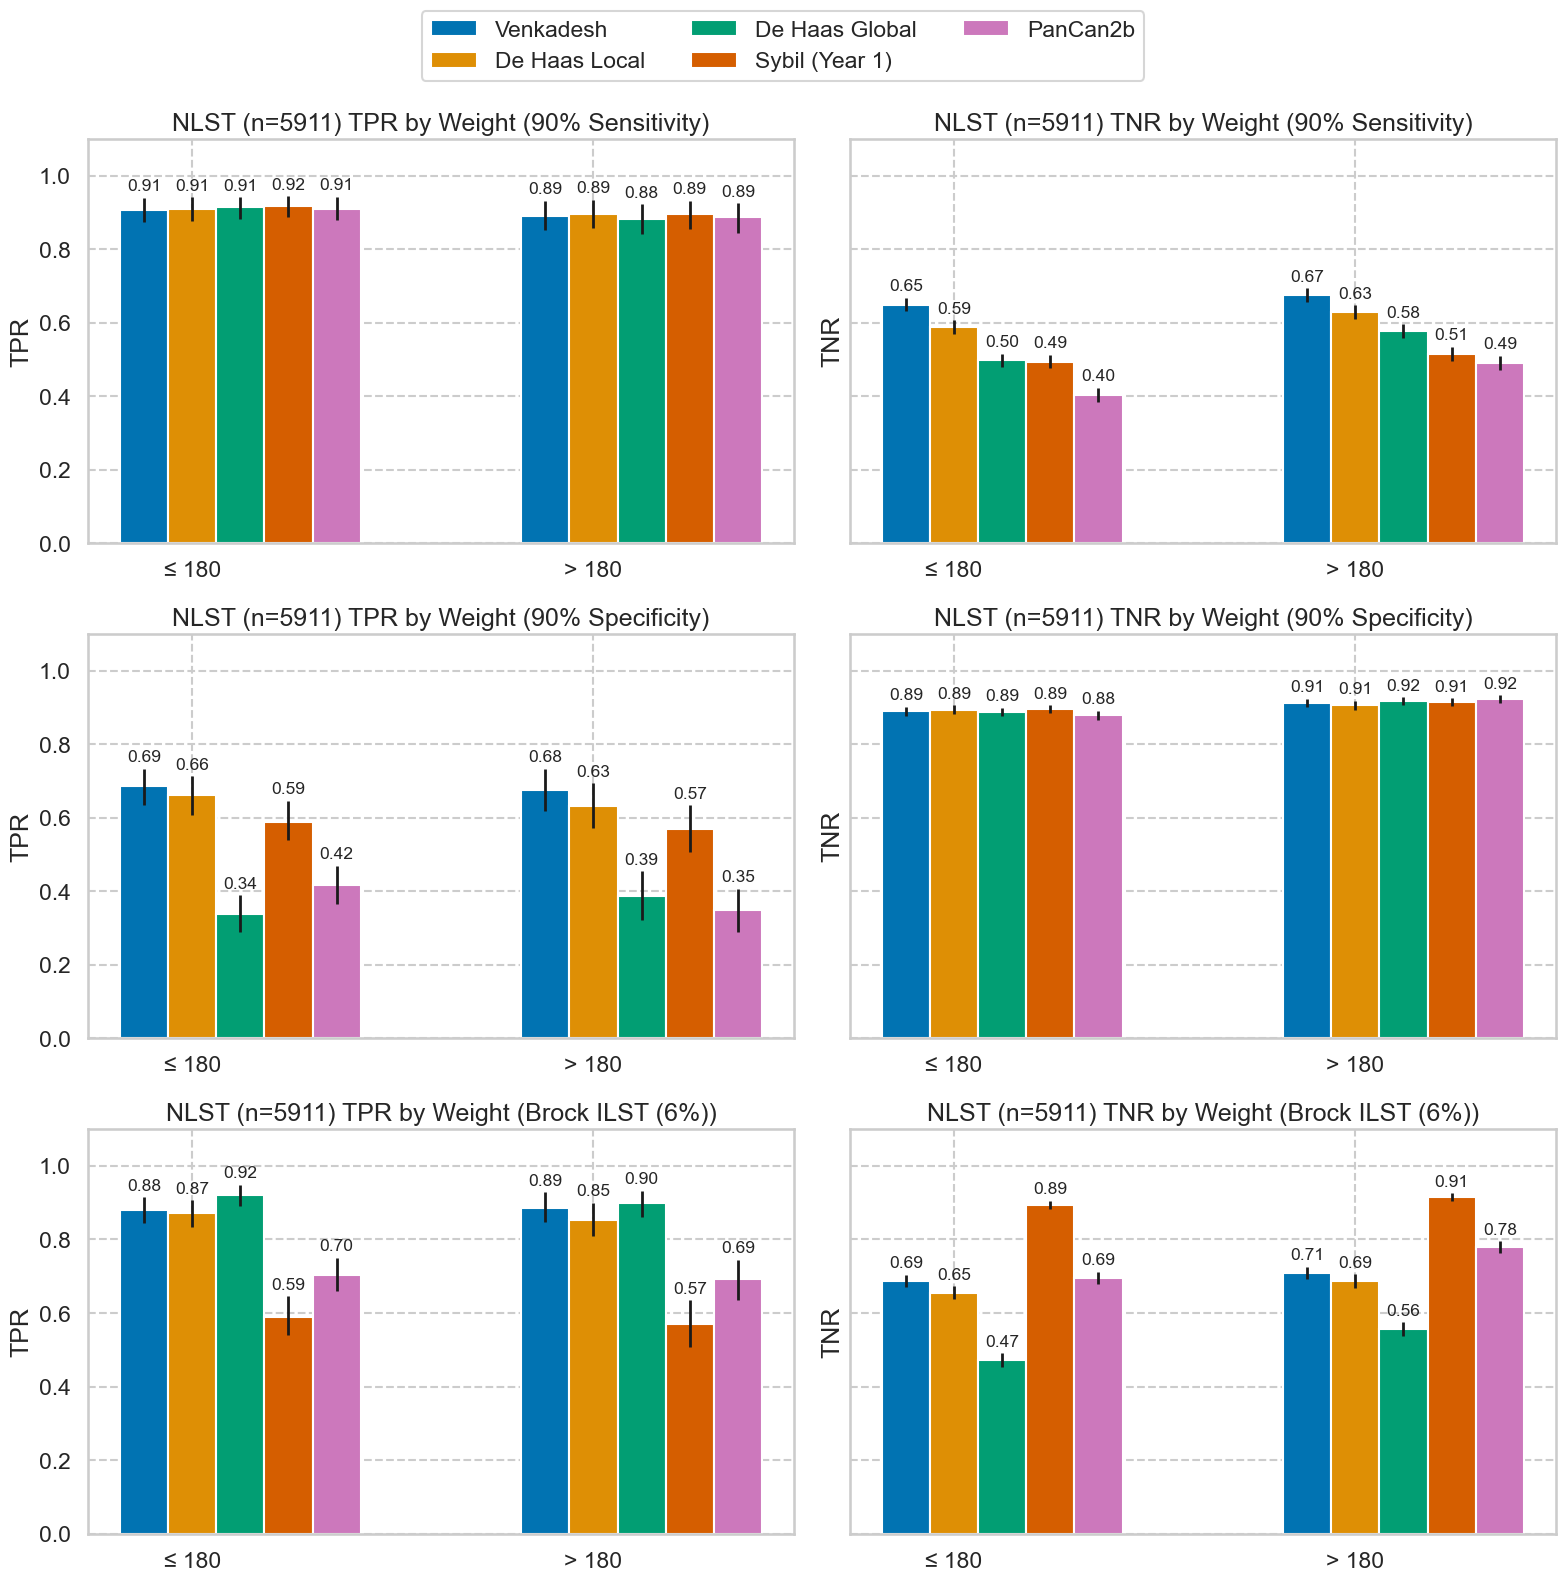

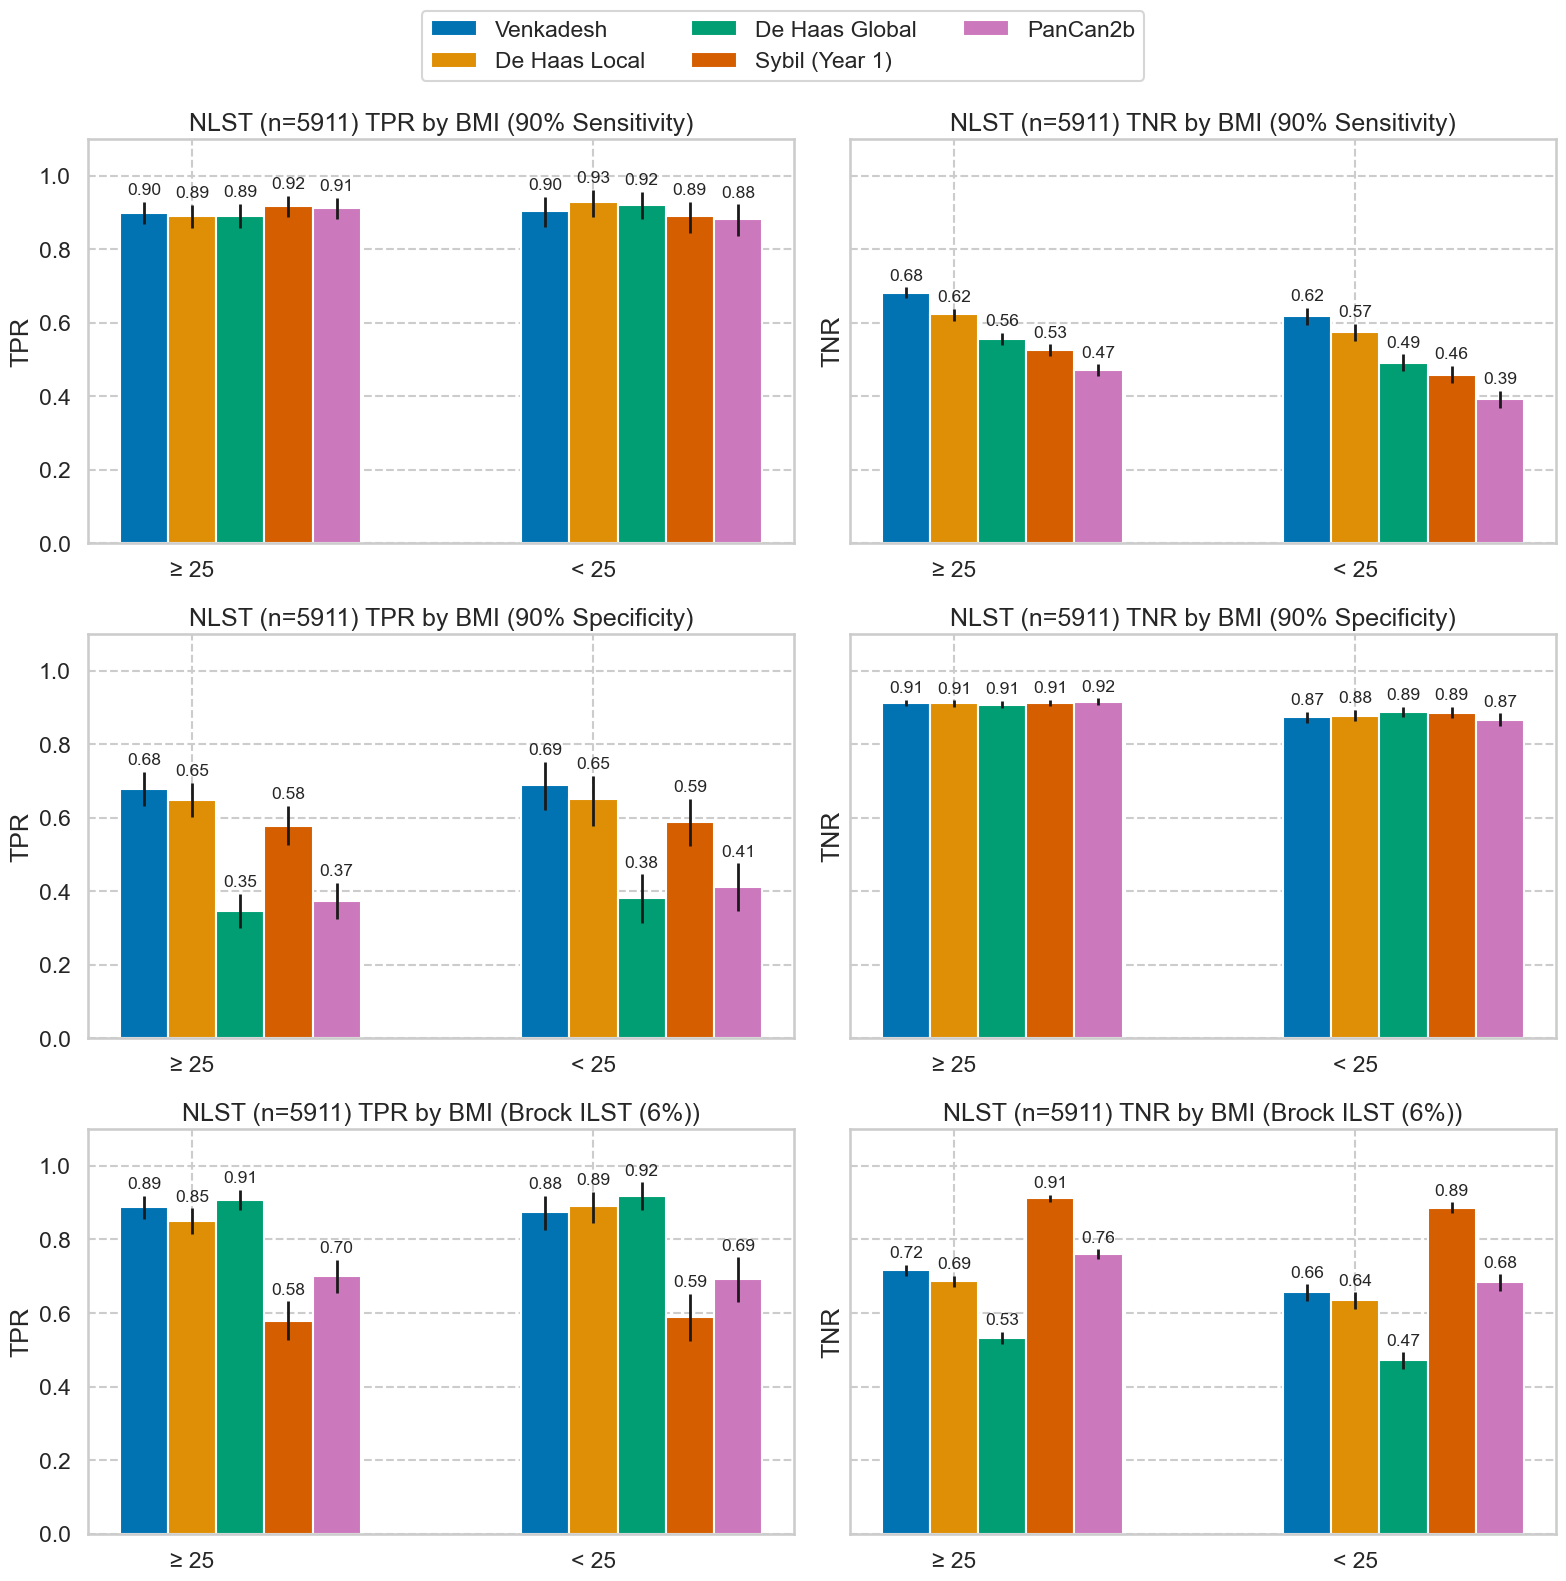

In [41]:
print(nlst_demos_to_include)
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
                                                policies=nlst_5911_policies, models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
                                                )  

## Threshold Tables

### DLCST

In [43]:
dlcst_demos_to_include = ['Age', 'Gender']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric="TPR")
threshold_tpr_dlcst = output.threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='TPR')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh      De Haas Combined      \
                                                TPR CI                TPR  CI   
policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.94 (0.84, 1.00)     0.87 (0.76, 0.97)       
                          ≤ 61    0.89 (0.77, 1.00)     0.96 (0.88, 1.00)       
                Gender    Male    0.88 (0.75, 1.00)     0.84 (0.70, 0.96)       
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)  **   
90% Specificity Age       > 61    0.84 (0.70, 0.96)     0.81 (0.67, 0.94)       
                          ≤ 61    0.71 (0.55, 0.88)     0.75 (0.58, 0.90)       
                Gender    Male    0.78 (0.64, 0.93)     0.75 (0.59, 0.90)       
                          Female  0.78 (0.62, 0.93)     0.81 (0.67, 0.96)       
Brock ILST (6%) Age       > 61    0.94 (0.84, 1.00)     0.94 (0.84, 1.00)       
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)       
                Gender    Male    0.91 (0.79, 1.00)     0.91 (0.79, 1.00)       
                          Female  1.00 (1.00, 1.00)     1.00 (1.00, 1.00)       

                                           PanCan2b        Sybil (Year 1)     
                                                TPR CI                TPR CI  
policy          Attribute Group                                               
90% Sensitivity Age       > 61    0.87 (0.75, 0.97)     0.97 (0.89, 1.00)     
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)     
                Gender    Male    0.88 (0.75, 0.97)     0.94 (0.84, 1.00)     
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)     
90% Specificity Age       > 61    0.71 (0.54, 0.87)     0.71 (0.55, 0.86)     
                          ≤ 61    0.61 (0.43, 0.79)     0.61 (0.42, 0.77)     
                Gender    Male    0.66 (0.48, 0.82)     0.72 (0.56, 0.88)     
                          Female  0.67 (0.48, 0.84)     0.59 (0.41, 0.78)     
Brock ILST (6%) Age       > 61    0.71 (0.54, 0.87)     0.65 (0.48, 0.82)     
                          ≤ 61    0.68 (0.50, 0.85)     0.39 (0.22, 0.57)  *  
                Gender    Male    0.69 (0.52, 0.85)     0.56 (0.39, 0.73)     
                          Female  0.70 (0.52, 0.88)     0.48 (0.30, 0.68)

In [44]:
print(tpr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [45]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='TNR')
threshold_tnr_dlcst = output.threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='TNR')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh       De Haas Combined     \
                                                TNR  CI                TNR CI   
policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.83 (0.77, 0.89)      0.77 (0.70, 0.84)      
                          ≤ 61    0.87 (0.83, 0.90)      0.78 (0.74, 0.82)      
                Gender    Male    0.88 (0.84, 0.92)      0.81 (0.76, 0.85)      
                          Female  0.83 (0.78, 0.87)   *  0.75 (0.69, 0.80)  *   
90% Specificity Age       > 61    0.86 (0.81, 0.92)      0.85 (0.79, 0.91)      
                          ≤ 61    0.91 (0.88, 0.94)      0.92 (0.89, 0.94)  *   
                Gender    Male    0.92 (0.89, 0.95)      0.90 (0.87, 0.93)      
                          Female  0.88 (0.83, 0.91)   *  0.90 (0.86, 0.93)      
Brock ILST (6%) Age       > 61    0.69 (0.61, 0.76)      0.68 (0.59, 0.75)      
                          ≤ 61    0.73 (0.68, 0.78)      0.67 (0.62, 0.72)      
                Gender    Male    0.77 (0.72, 0.82)      0.70 (0.64, 0.75)      
                          Female  0.66 (0.60, 0.72)  **  0.64 (0.59, 0.70)      

                                           PanCan2b         Sybil (Year 1)     
                                                TNR  CI                TNR CI  
policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.65 (0.57, 0.73)      0.13 (0.08, 0.18)     
                          ≤ 61    0.72 (0.68, 0.76)      0.17 (0.14, 0.21)     
                Gender    Male    0.78 (0.74, 0.83)      0.16 (0.13, 0.21)     
                          Female  0.61 (0.55, 0.66)  **  0.16 (0.11, 0.20)     
90% Specificity Age       > 61    0.84 (0.78, 0.90)      0.86 (0.80, 0.92)     
                          ≤ 61    0.92 (0.89, 0.95)   *  0.93 (0.90, 0.95)  *  
                Gender    Male    0.93 (0.90, 0.96)      0.93 (0.90, 0.96)     
                          Female  0.86 (0.81, 0.90)  **  0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age       > 61    0.80 (0.73, 0.86)      0.93 (0.89, 0.97)     
                          ≤ 61    0.86 (0.83, 0.90)   *  0.96 (0.94, 0.98)     
                Gender    Male    0.89 (0.86, 0.92)      0.95 (0.92, 0.97)     
                          Female  0.80 (0.74, 0.84)  **  0.96 (0.93, 0.98)

In [46]:
print(tnr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
    hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 1172

In [47]:
pairwise_tpr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric="TPR")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_1172, model_order=list(output.NLST_1172_MODELCOLS.keys()), metric='TPR')

In [49]:
tpr_demo_1172 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tpr_demo_1172 = tpr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tpr_demo_1172

De Haas Combined         De Haas Local     \
                                                TPR CI                TPR CI   
policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.90 (0.82, 0.96)     0.90 (0.83, 0.96)      
                          ≤ 61    0.92 (0.83, 0.98)     0.92 (0.83, 0.98)      
                BMI       ≥ 25    0.89 (0.82, 0.95)     0.90 (0.84, 0.96)      
                          < 25    0.93 (0.86, 1.00)     0.91 (0.82, 0.98)      
                Gender    Male    0.91 (0.84, 0.97)     0.91 (0.84, 0.97)      
                          Female  0.90 (0.80, 0.98)     0.90 (0.80, 0.98)      
                Height    > 68    0.90 (0.82, 0.97)     0.90 (0.83, 0.97)      
                          ≤ 68    0.91 (0.83, 0.98)     0.91 (0.84, 0.98)      
                Weight    ≤ 180   0.89 (0.81, 0.96)     0.89 (0.81, 0.96)      
                          > 180   0.93 (0.86, 0.98)     0.93 (0.86, 0.98)      
90% Specificity Age       > 61    0.60 (0.49, 0.72)     0.64 (0.53, 0.74)      
                          ≤ 61    0.67 (0.53, 0.80)     0.63 (0.49, 0.76)      
                BMI       ≥ 25    0.61 (0.51, 0.71)     0.62 (0.52, 0.72)      
                          < 25    0.67 (0.53, 0.80)     0.67 (0.52, 0.80)      
                Gender    Male    0.59 (0.48, 0.71)     0.61 (0.50, 0.72)      
                          Female  0.69 (0.56, 0.82)     0.69 (0.55, 0.82)      
                Height    > 68    0.60 (0.48, 0.71)     0.59 (0.47, 0.70)      
                          ≤ 68    0.67 (0.54, 0.79)     0.70 (0.59, 0.82)      
                Weight    ≤ 180   0.68 (0.58, 0.79)     0.67 (0.56, 0.78)      
                          > 180   0.56 (0.42, 0.69)     0.59 (0.46, 0.72)      
Brock ILST (6%) Age       > 61    0.90 (0.82, 0.96)     0.85 (0.76, 0.92)      
                          ≤ 61    0.92 (0.83, 0.98)     0.90 (0.80, 0.98)      
                BMI       ≥ 25    0.89 (0.82, 0.95)     0.88 (0.81, 0.95)      
                          < 25    0.93 (0.86, 1.00)     0.84 (0.73, 0.94)      
                Gender    Male    0.91 (0.84, 0.97)     0.87 (0.79, 0.94)      
                          Female  0.90 (0.80, 0.98)     0.85 (0.75, 0.94)      
                Height    > 68    0.90 (0.82, 0.97)     0.87 (0.79, 0.95)      
                          ≤ 68    0.91 (0.83, 0.98)     0.86 (0.77, 0.95)      
                Weight    ≤ 180   0.89 (0.81, 0.96)     0.85 (0.76, 0.93)      
                          > 180   0.93 (0.86, 0.98)     0.89 (0.80, 0.97)      

                                     De Haas Global     
                                                TPR CI  
policy          Attribute Group                         
90% Sensitivity Age       > 61    0.87 (0.79, 0.94)     
                          ≤ 61    0.96 (0.89, 1.00)  *  
                BMI       ≥ 25    0.89 (0.82, 0.95)     
                          < 25    0.93 (0.85, 1.00)     
                Gender    Male    0.92 (0.86, 0.98)     
                          Female  0.88 (0.77, 0.96)     
                Height    > 68    0.91 (0.84, 0.97)     
                          ≤ 68    0.89 (0.81, 0.96)     
                Weight    ≤ 180   0.92 (0.85, 0.97)     
                          > 180   0.89 (0.80, 0.96)     
90% Specificity Age       > 61    0.29 (0.20, 0.40)     
                          ≤ 61    0.31 (0.17, 0.45)     
                BMI       ≥ 25    0.28 (0.19, 0.38)     
                          < 25    0.33 (0.20, 0.47)     
                Gender    Male    0.34 (0.24, 0.45)     
                          Female  0.23 (0.12, 0.35)     
                Height    > 68    0.31 (0.21, 0.42)     
                          ≤ 68    0.28 (0.17, 0.40)     
                Weight    ≤ 180   0.26 (0.16, 0.36)     
                          > 180   0.35 (0.23, 0.48)     
Brock ILST (6%) Age       > 61    0.87 (0.79, 0.94)     
                          

In [50]:
print(tpr_demo_1172.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTPR.tex",
    hrules=True, label='tab:resNLSTtijmenTPR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [51]:
pairwise_tnr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric='TNR')
tnr_1172 = output.threshold_results_pretty(pairwise_tnr_1172, model_order=list(output.NLST_1172_MODELCOLS.keys()), metric='TNR')
tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')

Venkadesh       De Haas Combined  \
                                                TNR  CI                TNR   
policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.52 (0.48, 0.56)      0.62 (0.58, 0.66)   
                          ≤ 61    0.56 (0.52, 0.61)   *  0.65 (0.61, 0.69)   
                BMI       ≥ 25    0.57 (0.53, 0.61)      0.66 (0.63, 0.70)   
                          < 25    0.46 (0.41, 0.52)  **  0.57 (0.52, 0.62)   
                Gender    Male    0.54 (0.50, 0.58)      0.66 (0.63, 0.70)   
                          Female  0.53 (0.48, 0.57)      0.60 (0.55, 0.64)   
                Height    > 68    0.55 (0.52, 0.59)      0.66 (0.62, 0.70)   
                          ≤ 68    0.52 (0.47, 0.56)      0.61 (0.57, 0.65)   
                Weight    ≤ 180   0.50 (0.46, 0.54)      0.59 (0.56, 0.64)   
                          > 180   0.57 (0.53, 0.62)   *  0.68 (0.63, 0.72)   
90% Specificity Age       > 61    0.88 (0.86, 0.91)      0.91 (0.89, 0.94)   
                          ≤ 61    0.92 (0.90, 0.94)   *  0.88 (0.85, 0.91)   
                BMI       ≥ 25    0.92 (0.90, 0.94)      0.91 (0.88, 0.93)   
                          < 25    0.86 (0.82, 0.89)  **  0.89 (0.85, 0.92)   
                Gender    Male    0.91 (0.89, 0.93)      0.90 (0.88, 0.93)   
                          Female  0.88 (0.85, 0.91)   *  0.90 (0.87, 0.93)   
                Height    > 68    0.92 (0.90, 0.95)      0.90 (0.87, 0.93)   
                          ≤ 68    0.88 (0.85, 0.90)   *  0.90 (0.87, 0.93)   
                Weight    ≤ 180   0.88 (0.86, 0.91)      0.89 (0.86, 0.91)   
                          > 180   0.92 (0.89, 0.94)   *  0.91 (0.89, 0.94)   
Brock ILST (6%) Age       > 61    0.65 (0.62, 0.69)      0.61 (0.57, 0.64)   
                          ≤ 61    0.71 (0.67, 0.75)   *  0.62 (0.57, 0.66)   
                BMI       ≥ 25    0.70 (0.67, 0.74)      0.64 (0.60, 0.68)   
                          < 25    0.62 (0.57, 0.67)   *  0.54 (0.49, 0.60)   
                Gender    Male    0.68 (0.64, 0.71)      0.64 (0.60, 0.67)   
                          Female  0.68 (0.64, 0.72)      0.57 (0.52, 0.62)   
                Height    > 68    0.70 (0.66, 0.73)      0.63 (0.59, 0.68)   
                          ≤ 68    0.66 (0.62, 0.70)      0.59 (0.55, 0.63)   
                Weight    ≤ 180   0.65 (0.61, 0.69)      0.57 (0.54, 0.62)   
                          > 180   0.70 (0.66, 0.74)   *  0.65 (0.61, 0.69)   

                                          De Haas Local        De Haas Global  \
                                  CI                TNR CI                TNR   
policy          Attribute Group                                                 
90% Sensitivity Age       > 61        0.60 (0.56, 0.64)     0.54 (0.50, 0.58)   
                          ≤ 61        0.63 (0.59, 0.67)     0.49 (0.44, 0.53)   
                BMI       ≥ 25        0.64 (0.60, 0.67)     0.55 (0.51, 0.58)   
                          < 25    **  0.56 (0.51, 0.61)  *  0.45 (0.40, 0.50)   
                Gender    Male        0.62 (0.58, 0.66)     0.55 (0.51, 0.59)   
                          Female   *  0.60 (0.55, 0.64)     0.47 (0.42, 0.52)   
                Height    > 68        0.62 (0.57, 0.66)     0.56 (0.52, 0.61)   
                          ≤ 68     *  0.61 (0.57, 0.64)     0.47 (0.43, 0.51)   
                Weight    ≤ 180       0.60 (0.56, 0.64)     0.46 (0.41, 0.50)   
                          > 180    *  0.62 (0.58, 0.67)     0.58 (0.53, 0.62)   
90% Specificity Age       > 61        0.89 (0.86, 0.91)     0.91 (0.88, 0.93)   
                          ≤ 61     *  0.92 (0.90, 0.95)  *  0.89 (0.86, 0.92)   
                BMI       ≥ 25        0.92 (0.90, 0.94)     0.91 (0.89, 0.93)   
                          < 25        0.87 (0.83, 0.90)  *  0.88 (0.85, 0.92)   
                Gender    Male        0.91 (0.89, 0.93)     0.90 (0.88, 0.92)   
         

In [52]:
tnr_demo_1172 = tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tnr_demo_1172 = tnr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tnr_demo_1172

De Haas Combined          De Haas Local     \
                                                TNR  CI                TNR CI   
policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.62 (0.58, 0.66)      0.60 (0.56, 0.64)      
                          ≤ 61    0.65 (0.61, 0.69)      0.63 (0.59, 0.67)      
                BMI       ≥ 25    0.66 (0.63, 0.70)      0.64 (0.60, 0.67)      
                          < 25    0.57 (0.52, 0.62)  **  0.56 (0.51, 0.61)  *   
                Gender    Male    0.66 (0.63, 0.70)      0.62 (0.58, 0.66)      
                          Female  0.60 (0.55, 0.64)   *  0.60 (0.55, 0.64)      
                Height    > 68    0.66 (0.62, 0.70)      0.62 (0.57, 0.66)      
                          ≤ 68    0.61 (0.57, 0.65)   *  0.61 (0.57, 0.64)      
                Weight    ≤ 180   0.59 (0.56, 0.64)      0.60 (0.56, 0.64)      
                          > 180   0.68 (0.63, 0.72)   *  0.62 (0.58, 0.67)      
90% Specificity Age       > 61    0.91 (0.89, 0.94)      0.89 (0.86, 0.91)      
                          ≤ 61    0.88 (0.85, 0.91)   *  0.92 (0.90, 0.95)  *   
                BMI       ≥ 25    0.91 (0.88, 0.93)      0.92 (0.90, 0.94)      
                          < 25    0.89 (0.85, 0.92)      0.87 (0.83, 0.90)  *   
                Gender    Male    0.90 (0.88, 0.93)      0.91 (0.89, 0.93)      
                          Female  0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                Height    > 68    0.90 (0.87, 0.93)      0.92 (0.89, 0.94)      
                          ≤ 68    0.90 (0.87, 0.93)      0.89 (0.86, 0.91)  *   
                Weight    ≤ 180   0.89 (0.86, 0.91)      0.89 (0.86, 0.91)      
                          > 180   0.91 (0.89, 0.94)   *  0.91 (0.89, 0.94)      
Brock ILST (6%) Age       > 61    0.61 (0.57, 0.64)      0.64 (0.60, 0.67)      
                          ≤ 61    0.62 (0.57, 0.66)      0.67 (0.62, 0.71)      
                BMI       ≥ 25    0.64 (0.60, 0.68)      0.68 (0.64, 0.71)      
                          < 25    0.54 (0.49, 0.60)  **  0.59 (0.54, 0.64)  *   
                Gender    Male    0.64 (0.60, 0.67)      0.66 (0.62, 0.69)      
                          Female  0.57 (0.52, 0.62)   *  0.63 (0.59, 0.68)      
                Height    > 68    0.63 (0.59, 0.68)      0.66 (0.61, 0.70)      
                          ≤ 68    0.59 (0.55, 0.63)      0.64 (0.60, 0.68)      
                Weight    ≤ 180   0.57 (0.54, 0.62)      0.64 (0.60, 0.68)      
                          > 180   0.65 (0.61, 0.69)   *  0.66 (0.62, 0.70)      

                                     De Haas Global      
                                                TNR  CI  
policy          Attribute Group                          
90% Sensitivity Age       > 61    0.54 (0.50, 0.58)      
                          ≤ 61    0.49 (0.44, 0.53)   *  
                BMI       ≥ 25    0.55 (0.51, 0.58)      
                          < 25    0.45 (0.40, 0.50)  **  
                Gender    Male    0.55 (0.51, 0.59)      
                          Female  0.47 (0.42, 0.52)   *  
                Height    > 68    0.56 (0.52, 0.61)      
                          ≤ 68    0.47 (0.43, 0.51)  **  
                Weight    ≤ 180   0.46 (0.41, 0.50)      
                          > 180   0.58 (0.53, 0.62)  **  
90% Specificity Age       > 61    0.91 (0.88, 0.93)      
                          ≤ 61    0.89 (0.86, 0.92)      
                BMI       ≥ 25    0.91 (0.89, 0.93)      
                          < 25    0.88 (0.85, 0.92)      
                Gender    Male    0.90 (0.88, 0.92)      
                          Female  0.90 (0.87, 0.93)      
                Height    > 68    0.90 (0.87, 0.93)      
                          ≤ 68    0.90 (0.88, 0.92)      
                Weight    ≤ 180   0.89 (0.87, 0.92)      
                          > 180   0.91 (0.88, 0.93)      
Brock ILST (6%) Age       >

In [53]:
print(tnr_demo_1172.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTNR.tex",
    hrules=True, label='tab:resNLSTtijmenTNR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 5911

In [54]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TPR")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='TPR')
tpr_demo_5911 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tpr_demo_5911

Venkadesh          De Haas Local     \
                                                TPR  CI                TPR CI   
policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.90 (0.86, 0.93)      0.90 (0.87, 0.93)      
                          ≤ 61    0.91 (0.87, 0.94)      0.91 (0.88, 0.95)      
                BMI       ≥ 25    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                          < 25    0.90 (0.86, 0.94)      0.93 (0.89, 0.96)      
                Gender    Male    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                          Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.95)      
                Height    ≤ 68    0.90 (0.87, 0.94)      0.92 (0.89, 0.95)      
                          > 68    0.90 (0.85, 0.93)      0.89 (0.85, 0.92)      
                Race      White   0.90 (0.88, 0.93)      0.90 (0.87, 0.93)      
                          Black   0.82 (0.67, 0.96)      0.89 (0.77, 1.00)      
                Weight    ≤ 180   0.91 (0.87, 0.94)      0.91 (0.88, 0.94)      
                          > 180   0.89 (0.85, 0.93)      0.89 (0.86, 0.93)      
90% Specificity Age       > 61    0.70 (0.66, 0.75)      0.67 (0.62, 0.71)      
                          ≤ 61    0.65 (0.58, 0.71)      0.62 (0.56, 0.68)      
                BMI       ≥ 25    0.68 (0.63, 0.72)      0.65 (0.60, 0.70)      
                          < 25    0.69 (0.62, 0.75)      0.65 (0.58, 0.71)      
                Gender    Male    0.66 (0.61, 0.71)      0.64 (0.59, 0.68)      
                          Female  0.71 (0.65, 0.77)      0.67 (0.61, 0.73)      
                Height    ≤ 68    0.70 (0.65, 0.75)      0.67 (0.61, 0.72)      
                          > 68    0.66 (0.61, 0.72)      0.63 (0.57, 0.68)      
                Race      White   0.69 (0.65, 0.73)      0.65 (0.61, 0.69)      
                          Black   0.39 (0.23, 0.59)  **  0.46 (0.28, 0.64)  *   
                Weight    ≤ 180   0.69 (0.64, 0.73)      0.66 (0.61, 0.71)      
                          > 180   0.68 (0.62, 0.73)      0.63 (0.57, 0.69)      
Brock ILST (6%) Age       > 61    0.88 (0.84, 0.91)      0.85 (0.81, 0.89)      
                          ≤ 61    0.89 (0.85, 0.93)      0.89 (0.85, 0.93)      
                BMI       ≥ 25    0.89 (0.86, 0.92)      0.85 (0.81, 0.88)      
                          < 25    0.88 (0.83, 0.92)      0.89 (0.84, 0.93)      
                Gender    Male    0.88 (0.85, 0.91)      0.85 (0.81, 0.89)      
                          Female  0.89 (0.85, 0.92)      0.89 (0.84, 0.92)      
                Height    ≤ 68    0.89 (0.85, 0.92)      0.87 (0.83, 0.91)      
                          > 68    0.88 (0.84, 0.91)      0.86 (0.82, 0.90)      
                Race      White   0.89 (0.86, 0.91)      0.86 (0.83, 0.89)      
                          Black   0.75 (0.59, 0.91)      0.79 (0.64, 0.92)      
                Weight    ≤ 180   0.88 (0.84, 0.91)      0.87 (0.83, 0.91)      
                          > 180   0.89 (0.85, 0.93)      0.85 (0.81, 0.90)      

                                     De Haas Global        Sybil (Year 1)      \
                                                TPR CI                TPR  CI   
policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.89 (0.86, 0.92)     0.91 (0.88, 0.94)       
                          ≤ 61    0.91 (0.88, 0.95)     0.90 (0.86, 0.94)       
                BMI       ≥ 25    0.89 (0.86, 0.92)     0.92 (0.89, 0.95)       
                          < 25    0.92 (0.88, 0.96)     0.89 (0.84, 0.93)       
                Gender    Male    0.91 (0.88, 0.94)     0.90 (0.86, 0.93)       
                          Female  0.89 (0.85, 0.93)     0.92 (0.89, 0.95)       
                Height    ≤ 68    0.90 (0.87, 0.93)     0.92 (0.89, 0.95)       
                          > 68    0.90 (0.86, 0.93)     0.89 (0.85, 0.92

In [55]:
print(tpr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTPR.tex",
    hrules=True, label='tab:resNLSTfullTPR', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [56]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TNR")
threshold_tnr = output.threshold_results_pretty(pairwise_tnr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='TNR')
tnr_demo_5911 = threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tnr_demo_5911

Venkadesh          De Haas Local  \
                                                TNR  CI                TNR   
policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.63 (0.62, 0.65)      0.59 (0.57, 0.60)   
                          ≤ 61    0.70 (0.68, 0.71)  **  0.63 (0.61, 0.65)   
                BMI       ≥ 25    0.68 (0.67, 0.70)      0.62 (0.61, 0.64)   
                          < 25    0.62 (0.59, 0.64)  **  0.57 (0.55, 0.60)   
                Gender    Male    0.65 (0.63, 0.66)      0.61 (0.59, 0.63)   
                          Female  0.68 (0.66, 0.70)   *  0.61 (0.59, 0.63)   
                Height    ≤ 68    0.68 (0.66, 0.69)      0.61 (0.60, 0.63)   
                          > 68    0.64 (0.63, 0.66)   *  0.60 (0.58, 0.62)   
                Race      White   0.66 (0.65, 0.67)      0.61 (0.59, 0.62)   
                          Black   0.73 (0.66, 0.79)   *  0.59 (0.52, 0.66)   
                Weight    ≤ 180   0.65 (0.63, 0.67)      0.59 (0.57, 0.61)   
                          > 180   0.67 (0.66, 0.69)   *  0.63 (0.61, 0.65)   
90% Specificity Age       > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                          ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.90, 0.93)   
                BMI       ≥ 25    0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                          < 25    0.87 (0.86, 0.89)  **  0.88 (0.86, 0.89)   
                Gender    Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.91)   
                Height    ≤ 68    0.90 (0.89, 0.91)      0.91 (0.89, 0.92)   
                          > 68    0.90 (0.89, 0.91)      0.89 (0.88, 0.91)   
                Race      White   0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Black   0.93 (0.89, 0.97)      0.91 (0.87, 0.96)   
                Weight    ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                          > 180   0.91 (0.90, 0.92)  **  0.91 (0.89, 0.92)   
Brock ILST (6%) Age       > 61    0.67 (0.65, 0.69)      0.65 (0.63, 0.67)   
                          ≤ 61    0.73 (0.71, 0.75)  **  0.70 (0.68, 0.71)   
                BMI       ≥ 25    0.72 (0.70, 0.73)      0.69 (0.67, 0.70)   
                          < 25    0.66 (0.63, 0.68)  **  0.64 (0.61, 0.66)   
                Gender    Male    0.68 (0.66, 0.70)      0.66 (0.65, 0.68)   
                          Female  0.72 (0.70, 0.74)  **  0.68 (0.66, 0.70)   
                Height    ≤ 68    0.71 (0.70, 0.73)      0.68 (0.67, 0.70)   
                          > 68    0.68 (0.66, 0.70)  **  0.65 (0.64, 0.67)   
                Race      White   0.70 (0.68, 0.71)      0.67 (0.66, 0.68)   
                          Black   0.76 (0.69, 0.82)      0.68 (0.61, 0.75)   
                Weight    ≤ 180   0.69 (0.67, 0.70)      0.65 (0.64, 0.67)   
                          > 180   0.71 (0.69, 0.73)   *  0.69 (0.67, 0.71)   

                                         De Haas Global      \
                                  CI                TNR  CI   
policy          Attribute Group                               
90% Sensitivity Age       > 61        0.54 (0.52, 0.56)       
                          ≤ 61    **  0.53 (0.51, 0.55)       
                BMI       ≥ 25        0.56 (0.54, 0.57)       
                          < 25    **  0.49 (0.47, 0.51)  **   
                Gender    Male        0.55 (0.53, 0.57)       
                          Female      0.51 (0.49, 0.53)   *   
                Height    ≤ 68        0.52 (0.50, 0.54)       
                          > 68        0.55 (0.53, 0.57)   *   
                Race      White       0.54 (0.52, 0.55)       
                          Black       0.49 (0.41, 0.56)       
                Weight    ≤ 180       0.50 (0.48, 0.52)       
                          > 180   **  0.58 (0.56, 0.60)  **   
90% Specificity Age       > 61        0.90 (0.89, 0.91

In [57]:
print(tnr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTNR.tex",
    hrules=True, label='tab:resNLSTfullTNR', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


## Demographic Confounder Links

In [60]:
nlst_5911_v2, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)

### Gender

In [62]:
cat_gender, num_gender = output.confounders_by_attribute(nlst_5911_v2, 'Gender', output.NLST_POSSIBLE_CONFOUNDERS)
display(cat_gender)
display(num_gender)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]


Male       Female  \
                                                   Scans (%)    Scans (%)   
category     attribute          value                                       
Demographics Age                > 61             1980 (57.5)  1345 (54.5)   
                                ≤ 61             1461 (42.5)  1125 (45.5)   
             BMI                < 25              903 (26.2)   996 (40.3)   
                                ≥ 25             2538 (73.8)  1474 (59.7)   
             Ethnicity          Hispanic/Latino     65 (1.9)     33 (1.3)   
...                                                      ...          ...   
Work History Work: Painting     True               267 (7.8)     50 (2.0)   
             Work: Sandblasting False            3341 (97.1)  2459 (99.6)   
                                True                99 (2.9)     11 (0.4)   
             Work: Welding      False            3099 (90.1)  2451 (99.2)   
                                True               341 (9.9)     19 (0.8)   

                                                Difference Abs Diff  
                                                                     
category     attribute          value                                
Demographics Age                > 61                3.0880   3.0880  
                                ≤ 61               -3.0880   3.0880  
             BMI                < 25              -14.0815  14.0815  
                                ≥ 25               14.0815  14.0815  
             Ethnicity          Hispanic/Latino     0.5530   0.5530  
...                                                    ...      ...  
Work History Work: Painting     True                5.7351   5.7351  
             Work: Sandblasting False              -2.4608   2.4608  
                                True                2.4318   2.4318  
             Work: Welding      False              -9.1698   9.1698  
                                True                9.1407   9.1407  

[176 rows x 4 columns]

Male Scans  \
category     attribute                 value                        
Demographics Age                       Mean (SD)       63.4 (5.3)   
                                       Median (IQR)        63 (8)   
             Body Mass Index           Mean (SD)       27.9 (4.4)   
                                       Median (IQR)        27 (5)   
             Height                    Mean (SD)       70.5 (2.7)   
                                       Median (IQR)        71 (3)   
             Weight                    Mean (SD)     197.1 (35.0)   
                                       Median (IQR)      192 (46)   
Other        Diameter (mm)             Mean (SD)        9.3 (6.5)   
                                       Median (IQR)         7 (5)   
             Nodules Per Scan          Mean (SD)        1.9 (1.3)   
                                       Median (IQR)         1 (1)   
             Slices In Scan            Mean (SD)     175.0 (49.8)   
                                       Median (IQR)      165 (36)   
Smoking      Age at Smoking Onset      Mean (SD)       16.0 (3.4)   
                                       Median (IQR)        16 (4)   
             Cigarettes per Day (avg.) Mean (SD)      30.3 (12.3)   
                                       Median (IQR)       30 (20)   
             Pack-Years                Mean (SD)      62.4 (27.1)   
                                       Median (IQR)       55 (35)   
             Total Years of Smoking    Mean (SD)       41.6 (7.6)   
                                       Median (IQR)       42 (10)   

                                                     Female Scans  Difference  
category     attribute                 value                                   
Demographics Age                       Mean (SD)       62.9 (5.1)      0.5531  
                                       Median (IQR)        62 (8)      1.0000  
             Body Mass Index           Mean (SD)       27.1 (5.5)      0.7129  
                                       Median (IQR)        26 (7)      0.8880  
             Height                    Mean (SD)       64.5 (2.6)      5.9899  
                                       Median (IQR)        64 (3)      7.0000  
             Weight                    Mean (SD)     160.7 (34.8)     36.3716  
                                       Median (IQR)      157 (45)     35.0000  
Other        Diameter (mm)             Mean (SD)        8.7 (5.2)      0.6355  
                                       Median (IQR)         7 (4)      0.2000  
             Nodules Per Scan          Mean (SD)        1.9 (1.2)      0.0014  
                                       Median (IQR)         1 (1)      0.0000  
             Slices In Scan            Mean (SD)     164.0 (48.9)     10.9648  
                                       Median (IQR)      155 (36)     10.0000  
Smoking      Age at Smoking Onset      Mean (SD)       17.1 (3.6)     -1.0830  
                                       Median (IQR)        17 (4)     -1.0000  
             Cigarettes per Day (avg.) Mean (SD)      26.3 (10.4)      3.9389  
                                       Median (IQR)       20 (10)     10.0000  
             Pack-Years                Mean (SD)      52.6 (20.9)      9.7587  
                                       Median (IQR)       46 (22)      9.0000  
             Total Years of Smoking    Mean (SD)       40.5 (7.0)      1.0913  
                                       Median (IQR)        40 (9)      2.0000

In [63]:
cat_gender2, gender_topn = output.sort_multiindex_by_attribute(cat_gender, 'Abs Diff', topn=25)
cat_gender2

Male  \
                                                          Scans (%)   
category          attribute                      value                
Demographics      Height                         > 68   2621 (76.2)   
                                                 ≤ 68    820 (23.8)   
                  Weight                         > 180  2226 (64.7)   
                                                 ≤ 180  1215 (35.3)   
Smoking           Smoked Pipe                    False  2164 (62.9)   
                                                 True   1256 (36.5)   
                  Smoked Cigars                  True   1065 (31.0)   
                                                 False  2360 (68.6)   
Demographics      Married                        False   772 (22.4)   
                                                 True   2669 (77.6)   
Other             Work Without Mask              False  2257 (65.6)   
                                                 True   1184 (34.4)   
Smoking           Pack-Years                     ≤ 55   1742 (50.6)   
                                                 > 55   1699 (49.4)   
Demographics      BMI                            ≥ 25   2538 (73.8)   
                                                 < 25    903 (26.2)   
Smoking           Cigarettes per Day (avg.)      > 25   1827 (53.1)   
                                                 ≤ 25   1614 (46.9)   
                  Lived with Smoker              True   2877 (83.6)   
                                                 False   541 (15.7)   
Disease Diagnosis Diagnosis: Pneumonia           True    652 (18.9)   
                                                 False  2783 (80.9)   
                  Heart Disease or Attack        True    618 (18.0)   
                                                 False  2812 (81.7)   
Smoking           Age at Smoking Onset           ≤ 16   2034 (59.1)   
                                                 > 16   1407 (40.9)   
Nodule            Solid Nodule                   True   2467 (71.7)   
                                                 False   974 (28.3)   
Disease Diagnosis Diagnosis: Chronic Bronchitis  False  3208 (93.2)   
                                                 True     222 (6.5)   
Nodule            Ground-Glass Nodule            False  2623 (76.2)   
                                                 True    818 (23.8)   
Work History      Work: Welding                  False  3099 (90.1)   
                                                 True     341 (9.9)   
                  Work: Farming                  False  2896 (84.2)   
                                                 True    544 (15.8)   
                  Work: Asbestos                 False  3163 (91.9)   
                                                 True     277 (8.0)   
Disease Diagnosis Diagnosis: Adult Asthma        True     117 (3.4)   
                                                 False  3322 (96.5)   
Other             Previous Cancer Diagnosis      False  3370 (97.9)   
                                                 True      71 (2.1)   
Smoking           Total Years of Smoking         > 40   1923 (55.9)   
                                                 ≤ 40   1518 (44.1)   
Work History      Work: Foundry or Steel Milling False  3217 (93.5)   
                                                 True     223 (6.5)   
                  Work: Painting                 True     267 (7.8)   
                                                 False  3173 (92.2)   
Disease Diagnosis Diagnosis: Hypertension        False  2205 (64.1)   
                                                 True   1231 (35.8)   

                                                             Female  \
                                                          Scans (%)   
category          attribute                      value                
Demographics      Height                         > 68     146 (5.9)   
               

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:632: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)


Male       Female
                                        Scans (%)    Scans (%)
attribute                      value                          
Height                         > 68   2621 (76.2)    146 (5.9)
                               ≤ 68    820 (23.8)  2324 (94.1)
Weight                         > 180  2226 (64.7)   590 (23.9)
                               ≤ 180  1215 (35.3)  1880 (76.1)
Smoked Pipe                    False  2164 (62.9)  2411 (97.6)
                               True   1256 (36.5)     45 (1.8)
Smoked Cigars                  True   1065 (31.0)     83 (3.4)
                               False  2360 (68.6)  2378 (96.3)
Married                        False   772 (22.4)  1165 (47.2)
                               True   2669 (77.6)  1305 (52.8)
Work Without Mask              False  2257 (65.6)  2150 (87.0)
                               True   1184 (34.4)   320 (13.0)
Pack-Years                     ≤ 55   1742 (50.6)  1648 (66.7)
                               > 55   1699 (49.4)   822 (33.3)
BMI                            ≥ 25   2538 (73.8)  1474 (59.7)
                               < 25    903 (26.2)   996 (40.3)
Cigarettes per Day (avg.)      > 25   1827 (53.1)   965 (39.1)
                               ≤ 25   1614 (46.9)  1505 (60.9)
Lived with Smoker              True   2877 (83.6)  2334 (94.5)
                               False   541 (15.7)    124 (5.0)
Diagnosis: Pneumonia           True    652 (18.9)   730 (29.6)
                               False  2783 (80.9)  1731 (70.1)
Heart Disease or Attack        True    618 (18.0)    184 (7.4)
                               False  2812 (81.7)  2275 (92.1)
Age at Smoking Onset           ≤ 16   2034 (59.1)  1222 (49.5)
                               > 16   1407 (40.9)  1248 (50.5)
Solid Nodule                   True   2467 (71.7)  1533 (62.1)
                               False   974 (28.3)   937 (37.9)
Diagnosis: Chronic Bronchitis  False  3208 (93.2)  2068 (83.7)
                               True     222 (6.5)   397 (16.1)
Ground-Glass Nodule            False  2623 (76.2)  1652 (66.9)
                               True    818 (23.8)   818 (33.1)
Work: Welding                  False  3099 (90.1)  2451 (99.2)
                               True     341 (9.9)     19 (0.8)
Work: Farming                  False  2896 (84.2)  2301 (93.2)
                               True    544 (15.8)    169 (6.8)
Work: Asbestos                 False  3163 (91.9)  2447 (99.1)
                               True     277 (8.0)     23 (0.9)
Diagnosis: Adult Asthma        True     117 (3.4)   258 (10.4)
                               False  3322 (96.5)  2212 (89.6)
Previous Cancer Diagnosis      False  3370 (97.9)  2268 (91.8)
                               True      71 (2.1)    202 (8.2)
Total Years of Smoking         > 40   1923 (55.9)  1232 (49.9)
                               ≤ 40   1518 (44.1)  1238 (50.1)
Work: Foundry or Steel Milling False  3217 (93.5)  2453 (99.3)
                               True     223 (6.5)     17 (0.7)
Work: Painting                 True     267 (7.8)     50 (2.0)
                               False  3173 (92.2)  2420 (98.0)
Diagnosis: Hypertension        False  2205 (64.1)  1704 (69.0)
                               True   1231 (35.8)   762 (30.9)

In [64]:
print(cat_gender2.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderConfounders.tex",
    hrules=True, label='tab:genderConfounders', environment='table', column_format=f'll|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='The 25 clinical confounders in the NLST dataset with the highest difference in prevalence between men and women.'))

None


### Race

In [65]:
cat_race, num_race = output.confounders_by_attribute(nlst_5911_v2, 'WhiteOrBlack', output.NLST_POSSIBLE_CONFOUNDERS)
cat_race2, race_topn = output.sort_multiindex_by_attribute(cat_race, 'Abs Diff')
cat_race2

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]


White  \
                                                           Scans (%)   
category          attribute                      value                 
Demographics      Married                        False   1764 (31.9)   
                                                 True    3759 (68.1)   
Smoking           Cigarettes per Day (avg.)      > 25    2667 (48.3)   
                                                 ≤ 25    2856 (51.7)   
                  Pack-Years                     ≤ 55    3126 (56.6)   
                                                 > 55    2397 (43.4)   
Disease Diagnosis Diagnosis: Hypertension        False   3702 (67.0)   
                                                 True    1813 (32.8)   
Smoking           Current Smoker                 True    2734 (49.5)   
                                                 False   2789 (50.5)   
Demographics      Unfinished Education Level     True    1466 (26.5)   
                                                 False   4057 (73.5)   
Smoking           Smoked Pipe                    True    1259 (22.8)   
                                                 False   4234 (76.7)   
Demographics      Gender                         Female  2302 (41.7)   
                                                 Male    3221 (58.3)   
Disease Diagnosis Diagnosis: Diabetes            False   5058 (91.6)   
                                                 True      462 (8.4)   
Demographics      Height                         ≤ 68    2886 (52.3)   
                                                 > 68    2637 (47.7)   
Work History      Work: Farming                  False   4843 (87.7)   
                                                 True     680 (12.3)   
Smoking           Age at Smoking Onset           ≤ 16    3055 (55.3)   
                                                 > 16    2468 (44.7)   
Nodule            Solid Nodule                   False   1747 (31.6)   
                                                 True    3776 (68.4)   
Smoking           Total Years of Smoking         > 40    2925 (53.0)   
                                                 ≤ 40    2598 (47.0)   
                  Smoked Cigars                  False   4407 (79.8)   
                                                 True    1096 (19.8)   
Other             Diameter (mm)                  > 6     3500 (63.4)   
                                                 ≤ 6     2023 (36.6)   
Disease Diagnosis Diagnosis: Pneumonia           False   4203 (76.1)   
                                                 True    1306 (23.6)   
Smoking           Worked with Smoker             True    4798 (86.9)   
                                                 False    679 (12.3)   
Nodule            Ground-Glass Nodule            False   4013 (72.7)   
                                                 True    1510 (27.3)   
Disease Diagnosis Heart Disease or Attack        True     750 (13.6)   
                                                 False   4752 (86.0)   
Smoking           Lived with Smoker              True    4879 (88.3)   
                                                 False    610 (11.0)   
Work History      Work: Foundry or Steel Milling True      216 (3.9)   
                                                 False   5307 (96.1)   
Disease Diagnosis Diagnosis: Tuberculosis        True       55 (1.0)   
                                                 False   5463 (98.9)   
Work History      Work: Asbestos                 False   5259 (95.2)   
                                                 True      264 (4.8)   
Lung Cancer       Unclassified Carcinoma         False   5463 (98.9)   
                                                 True       60 (1.1)   

                                                              Black  \
                                                          Scans (%)   
category          attribute                      value                
Demographics      Married        

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:632: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)


White       Black
                                         Scans (%)   Scans (%)
attribute                      value                          
Married                        False   1764 (31.9)  113 (60.1)
                               True    3759 (68.1)   75 (39.9)
Cigarettes per Day (avg.)      > 25    2667 (48.3)   41 (21.8)
                               ≤ 25    2856 (51.7)  147 (78.2)
Pack-Years                     ≤ 55    3126 (56.6)  148 (78.7)
                               > 55    2397 (43.4)   40 (21.3)
Diagnosis: Hypertension        False   3702 (67.0)   86 (45.7)
                               True    1813 (32.8)  102 (54.3)
Current Smoker                 True    2734 (49.5)  129 (68.6)
                               False   2789 (50.5)   59 (31.4)
Unfinished Education Level     True    1466 (26.5)   79 (42.0)
                               False   4057 (73.5)  109 (58.0)
Smoked Pipe                    True    1259 (22.8)    17 (9.0)
                               False   4234 (76.7)  168 (89.4)
Gender                         Female  2302 (41.7)  103 (54.8)
                               Male    3221 (58.3)   85 (45.2)
Diagnosis: Diabetes            False   5058 (91.6)  153 (81.4)
                               True      462 (8.4)   35 (18.6)
Height                         ≤ 68    2886 (52.3)  117 (62.2)
                               > 68    2637 (47.7)   71 (37.8)
Work: Farming                  False   4843 (87.7)  182 (96.8)
                               True     680 (12.3)     6 (3.2)
Age at Smoking Onset           ≤ 16    3055 (55.3)   89 (47.3)
                               > 16    2468 (44.7)   99 (52.7)
Solid Nodule                   False   1747 (31.6)   74 (39.4)
                               True    3776 (68.4)  114 (60.6)
Total Years of Smoking         > 40    2925 (53.0)  113 (60.1)
                               ≤ 40    2598 (47.0)   75 (39.9)
Smoked Cigars                  False   4407 (79.8)  161 (85.6)
                               True    1096 (19.8)   24 (12.8)
Diameter (mm)                  > 6     3500 (63.4)  129 (68.6)
                               ≤ 6     2023 (36.6)   59 (31.4)
Diagnosis: Pneumonia           False   4203 (76.1)  152 (80.9)
                               True    1306 (23.6)   36 (19.1)
Worked with Smoker             True    4798 (86.9)  172 (91.5)
                               False    679 (12.3)    16 (8.5)
Ground-Glass Nodule            False   4013 (72.7)  128 (68.1)
                               True    1510 (27.3)   60 (31.9)
Heart Disease or Attack        True     750 (13.6)    18 (9.6)
                               False   4752 (86.0)  170 (90.4)
Lived with Smoker              True    4879 (88.3)  159 (84.6)
                               False    610 (11.0)   29 (15.4)
Work: Foundry or Steel Milling True      216 (3.9)    15 (8.0)
                               False   5307 (96.1)  173 (92.0)
Diagnosis: Tuberculosis        True       55 (1.0)     9 (4.8)
                               False   5463 (98.9)  179 (95.2)
Work: Asbestos                 False   5259 (95.2)  173 (92.0)
                               True      264 (4.8)    15 (8.0)
Unclassified Carcinoma         False   5463 (98.9)  180 (95.7)
                               True       60 (1.1)     8 (4.3)

In [66]:
num_race

White Scans  \
category     attribute                 value                        
Demographics Age                       Mean (SD)       63.2 (5.3)   
                                       Median (IQR)        62 (8)   
             Body Mass Index           Mean (SD)       27.6 (4.9)   
                                       Median (IQR)        26 (6)   
             Height                    Mean (SD)       68.0 (4.0)   
                                       Median (IQR)        68 (6)   
             Weight                    Mean (SD)     182.2 (38.9)   
                                       Median (IQR)      180 (50)   
Other        Diameter (mm)             Mean (SD)        9.0 (5.9)   
                                       Median (IQR)         7 (5)   
             Nodules Per Scan          Mean (SD)        1.9 (1.3)   
                                       Median (IQR)         1 (1)   
             Slices In Scan            Mean (SD)     170.5 (49.5)   
                                       Median (IQR)      161 (39)   
Smoking      Age at Smoking Onset      Mean (SD)       16.5 (3.5)   
                                       Median (IQR)        16 (4)   
             Cigarettes per Day (avg.) Mean (SD)      28.8 (11.7)   
                                       Median (IQR)       25 (17)   
             Pack-Years                Mean (SD)      58.6 (25.0)   
                                       Median (IQR)       51 (29)   
             Total Years of Smoking    Mean (SD)       41.1 (7.4)   
                                       Median (IQR)       41 (10)   

                                                      Black Scans  Difference  
category     attribute                 value                                   
Demographics Age                       Mean (SD)       62.7 (4.9)      0.5507  
                                       Median (IQR)        62 (7)     -0.5000  
             Body Mass Index           Mean (SD)       28.3 (5.8)     -0.7176  
                                       Median (IQR)        27 (6)     -0.7401  
             Height                    Mean (SD)       67.6 (4.0)      0.4392  
                                       Median (IQR)        67 (7)      1.0000  
             Weight                    Mean (SD)     183.7 (41.3)     -1.5515  
                                       Median (IQR)      180 (47)      0.0000  
Other        Diameter (mm)             Mean (SD)        9.9 (6.8)     -0.8664  
                                       Median (IQR)         7 (6)     -0.6500  
             Nodules Per Scan          Mean (SD)        1.8 (1.1)      0.1098  
                                       Median (IQR)         1 (1)      0.0000  
             Slices In Scan            Mean (SD)     180.2 (65.0)     -9.7817  
                                       Median (IQR)      161 (32)      0.0000  
Smoking      Age at Smoking Onset      Mean (SD)       17.2 (3.5)     -0.6908  
                                       Median (IQR)        17 (4)     -1.0000  
             Cigarettes per Day (avg.) Mean (SD)       23.1 (7.9)      5.7245  
                                       Median (IQR)        20 (4)      5.0000  
             Pack-Years                Mean (SD)      48.6 (18.6)     10.0402  
                                       Median (IQR)       43 (18)      8.0000  
             Total Years of Smoking    Mean (SD)       42.1 (6.6)     -1.0355  
                                       Median (IQR)        42 (9)     -1.0000

In [67]:
print(cat_race2.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceConfounders.tex",
    hrules=True, label='tab:raceConfounders', environment='table', column_format=f'll|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='The 25 clinical confounders in the NLST dataset with the highest difference in prevalence between White and Black patients.'))

None


### BMI

In [68]:
cat_overweight, num_overweight = output.confounders_by_attribute(nlst_5911_v2, 'Overweight', output.NLST_POSSIBLE_CONFOUNDERS)
cat_overweight2, overweight_topn = output.sort_multiindex_by_attribute(cat_overweight)
cat_overweight2

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]


< 25         ≥ 25  \
                                                      Scans (%)    Scans (%)   
category          attribute                 value                              
Demographics      Weight                    ≤ 180   1799 (94.7)  1296 (32.3)   
                                            > 180     100 (5.3)  2716 (67.7)   
Smoking           Current Smoker            False    716 (37.7)  2214 (55.2)   
                                            True    1183 (62.3)  1798 (44.8)   
Demographics      Gender                    Female   996 (52.4)  1474 (36.7)   
                                            Male     903 (47.6)  2538 (63.3)   
Other             Emphysema in Scan         False   1007 (53.0)  2748 (68.5)   
                                            True     892 (47.0)  1264 (31.5)   
Disease Diagnosis Diagnosis: Hypertension   True     459 (24.2)  1534 (38.2)   
                                            False   1435 (75.6)  2474 (61.7)   
Demographics      Height                    > 68     751 (39.5)  2016 (50.2)   
                                            ≤ 68    1148 (60.5)  1996 (49.8)   
                  Married                   True    1152 (60.7)  2822 (70.3)   
                                            False    747 (39.3)  1190 (29.7)   
Smoking           Total Years of Smoking    ≤ 40     774 (40.8)  1982 (49.4)   
                                            > 40    1125 (59.2)  2030 (50.6)   
                  Smoked Pipe               True     314 (16.5)   987 (24.6)   
                                            False   1577 (83.0)  2998 (74.7)   
Disease Diagnosis Diagnosis: Diabetes       True       68 (3.6)   477 (11.9)   
                                            False   1827 (96.2)  3535 (88.1)   
Smoking           Smoked Cigars             False   1627 (85.7)  3111 (77.5)   
                                            True     265 (14.0)   883 (22.0)   
                  Cigarettes per Day (avg.) ≤ 25    1097 (57.8)  2022 (50.4)   
                                            > 25     802 (42.2)  1990 (49.6)   
Disease Diagnosis Heart Disease or Attack   False   1719 (90.5)  3368 (83.9)   
                                            True      174 (9.2)   628 (15.7)   
                  Diagnosis: Pneumonia      True     501 (26.4)   881 (22.0)   
                                            False   1390 (73.2)  3124 (77.9)   
Smoking           Age at Smoking Onset      > 16     910 (47.9)  1745 (43.5)   
                                            ≤ 16     989 (52.1)  2267 (56.5)   
Disease Diagnosis Diagnosis: Emphysema      False   1643 (86.5)  3622 (90.3)   
                                            True     252 (13.3)    383 (9.5)   
Nodule            Semi-Solid Nodule         True     290 (15.3)   462 (11.5)   
                                            False   1609 (84.7)  3550 (88.5)   
                  Nodule in Upper Lung      False    868 (45.7)  1982 (49.4)   
                                            True    1031 (54.3)  2030 (50.6)   
Disease Diagnosis Diagnosis: COPD           False   1720 (90.6)  3772 (94.0)   
                                            True      168 (8.8)    233 (5.8)   
Nodule            Perfissural Nodule        True      124 (6.5)   400 (10.0)   
                                            False   1775 (93.5)  3612 (90.0)   
Other             Diameter (mm)             > 6     1241 (65.4)  2508 (62.5)   
                                            ≤ 6      658 (34.6)  1504 (37.5)   
Smoking           Pack-Years                > 55     774 (40.8)  1747 (43.5)   
                                            ≤ 55    1125 (59.2)  2265 (56.5)   
Other             Family History of LC      False   1438 (75.7)  2946 (73.4)   
                                            True     461 (24.3)  1066 (26.6)   
Work History      Work: Welding             False   1810 (95.3)  3740 (93.2)   
                                            True       88 (

< 25         ≥ 25
                                    Scans (%)    Scans (%)
attribute                 value                           
Weight                    ≤ 180   1799 (94.7)  1296 (32.3)
                          > 180     100 (5.3)  2716 (67.7)
Current Smoker            False    716 (37.7)  2214 (55.2)
                          True    1183 (62.3)  1798 (44.8)
Gender                    Female   996 (52.4)  1474 (36.7)
                          Male     903 (47.6)  2538 (63.3)
Emphysema in Scan         False   1007 (53.0)  2748 (68.5)
                          True     892 (47.0)  1264 (31.5)
Diagnosis: Hypertension   True     459 (24.2)  1534 (38.2)
                          False   1435 (75.6)  2474 (61.7)
Height                    > 68     751 (39.5)  2016 (50.2)
                          ≤ 68    1148 (60.5)  1996 (49.8)
Married                   True    1152 (60.7)  2822 (70.3)
                          False    747 (39.3)  1190 (29.7)
Total Years of Smoking    ≤ 40     774 (40.8)  1982 (49.4)
                          > 40    1125 (59.2)  2030 (50.6)
Smoked Pipe               True     314 (16.5)   987 (24.6)
                          False   1577 (83.0)  2998 (74.7)
Diagnosis: Diabetes       True       68 (3.6)   477 (11.9)
                          False   1827 (96.2)  3535 (88.1)
Smoked Cigars             False   1627 (85.7)  3111 (77.5)
                          True     265 (14.0)   883 (22.0)
Cigarettes per Day (avg.) ≤ 25    1097 (57.8)  2022 (50.4)
                          > 25     802 (42.2)  1990 (49.6)
Heart Disease or Attack   False   1719 (90.5)  3368 (83.9)
                          True      174 (9.2)   628 (15.7)
Diagnosis: Pneumonia      True     501 (26.4)   881 (22.0)
                          False   1390 (73.2)  3124 (77.9)
Age at Smoking Onset      > 16     910 (47.9)  1745 (43.5)
                          ≤ 16     989 (52.1)  2267 (56.5)
Diagnosis: Emphysema      False   1643 (86.5)  3622 (90.3)
                          True     252 (13.3)    383 (9.5)
Semi-Solid Nodule         True     290 (15.3)   462 (11.5)
                          False   1609 (84.7)  3550 (88.5)
Nodule in Upper Lung      False    868 (45.7)  1982 (49.4)
                          True    1031 (54.3)  2030 (50.6)
Diagnosis: COPD           False   1720 (90.6)  3772 (94.0)
                          True      168 (8.8)    233 (5.8)
Perfissural Nodule        True      124 (6.5)   400 (10.0)
                          False   1775 (93.5)  3612 (90.0)
Diameter (mm)             > 6     1241 (65.4)  2508 (62.5)
                          ≤ 6      658 (34.6)  1504 (37.5)
Pack-Years                > 55     774 (40.8)  1747 (43.5)
                          ≤ 55    1125 (59.2)  2265 (56.5)
Family History of LC      False   1438 (75.7)  2946 (73.4)
                          True     461 (24.3)  1066 (26.6)
Work: Welding             False   1810 (95.3)  3740 (93.2)
                          True       88 (4.6)    272 (6.8)
Ground-Glass Nodule       False   1401 (73.8)  2874 (71.6)
                          True     498 (26.2)  1138 (28.4)

In [69]:
num_overweight

< 25 Scans  \
category     attribute                 value                        
Demographics Age                       Mean (SD)       63.3 (5.3)   
                                       Median (IQR)        63 (8)   
             Body Mass Index           Mean (SD)       22.5 (1.9)   
                                       Median (IQR)        22 (2)   
             Height                    Mean (SD)       67.3 (4.0)   
                                       Median (IQR)        67 (6)   
             Weight                    Mean (SD)     145.7 (22.7)   
                                       Median (IQR)      145 (32)   
Other        Diameter (mm)             Mean (SD)        9.5 (6.7)   
                                       Median (IQR)         7 (5)   
             Nodules Per Scan          Mean (SD)        1.9 (1.2)   
                                       Median (IQR)         1 (1)   
             Slices In Scan            Mean (SD)     173.6 (50.9)   
                                       Median (IQR)      163 (37)   
Smoking      Age at Smoking Onset      Mean (SD)       16.7 (3.6)   
                                       Median (IQR)        16 (3)   
             Cigarettes per Day (avg.) Mean (SD)      27.4 (11.3)   
                                       Median (IQR)       20 (10)   
             Pack-Years                Mean (SD)      57.4 (24.5)   
                                       Median (IQR)       50 (29)   
             Total Years of Smoking    Mean (SD)       42.3 (7.2)   
                                       Median (IQR)       42 (10)   

                                                       ≥ 25 Scans  Difference  
category     attribute                 value                                   
Demographics Age                       Mean (SD)       63.1 (5.2)      0.2310  
                                       Median (IQR)        62 (8)      1.0000  
             Body Mass Index           Mean (SD)       29.9 (4.1)     -7.3951  
                                       Median (IQR)        29 (5)     -6.0586  
             Height                    Mean (SD)       68.3 (3.9)     -1.0464  
                                       Median (IQR)        69 (5)     -2.0000  
             Weight                    Mean (SD)     198.9 (33.4)    -53.1974  
                                       Median (IQR)      195 (45)    -50.0000  
Other        Diameter (mm)             Mean (SD)        8.8 (5.6)      0.6977  
                                       Median (IQR)         7 (4)      0.3000  
             Nodules Per Scan          Mean (SD)        1.9 (1.3)      0.0147  
                                       Median (IQR)         1 (1)      0.0000  
             Slices In Scan            Mean (SD)     168.9 (49.1)      4.7522  
                                       Median (IQR)      160 (38)      3.0000  
Smoking      Age at Smoking Onset      Mean (SD)       16.4 (3.5)      0.3161  
                                       Median (IQR)        16 (4)      0.0000  
             Cigarettes per Day (avg.) Mean (SD)      29.2 (11.8)     -1.8699  
                                       Median (IQR)       25 (20)     -5.0000  
             Pack-Years                Mean (SD)      58.7 (25.4)     -1.3180  
                                       Median (IQR)       51 (29)     -1.0000  
             Total Years of Smoking    Mean (SD)       40.6 (7.4)      1.7294  
                                       Median (IQR)        41 (9)      1.0000

In [70]:
print(cat_overweight2.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiConfounders.tex",
    hrules=True, label='tab:bmiConfounders', environment='table', column_format=f'll|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='The 25 clinical confounders in the NLST dataset with the highest difference in prevalence between patients with high BMI ($\geqslant 25$) and low BMI ($< 25$).'))

None


## ROC isolating for confounders

### Gender

In [73]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_roc_pretty = output.roc_isolations_pretty(gender_roc, 'Gender', 'Sybil (Year 1)')
gender_roc_pretty

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_2_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Male             Female  \
                                                      AUC                AUC   
Category     Confounder   Subset                                               
Demographics Age          ≤ 61          0.79 (0.74, 0.83)  0.91 (0.87, 0.94)   
                          > 61          0.82 (0.79, 0.85)  0.86 (0.83, 0.89)   
             HS Education True          0.81 (0.78, 0.84)  0.88 (0.86, 0.91)   
             Married      False         0.80 (0.75, 0.85)  0.91 (0.89, 0.94)   
                          True          0.81 (0.78, 0.84)  0.85 (0.81, 0.88)   
...                                                   ...                ...   
Scanner      Model Name   Mx8000        0.72 (0.62, 0.81)  0.90 (0.84, 0.96)   
                          Sensation 16  0.84 (0.76, 0.90)  0.86 (0.80, 0.92)   
                          Sensation 4   0.98 (0.96, 1.00)  0.96 (0.89, 1.00)   
                          Sensation 64  0.82 (0.64, 0.99)  0.95 (0.83, 1.00)   
                          Volume Zoom   0.85 (0.80, 0.90)  0.93 (0.88, 0.97)   

                                             P  
                                                
Category     Confounder   Subset                
Demographics Age          ≤ 61          < .001  
                          > 61             .14  
             HS Education True          < .001  
             Married      False           .001  
                          True             .18  
...                                        ...  
Scanner      Model Name   Mx8000          .004  
                          Sensation 16     .60  
                          Sensation 4      .75  
                          Sensation 64     .37  
                          Volume Zoom      .05  

[157 rows x 3 columns]

In [74]:
gender_roc_out = gender_roc_pretty[gender_roc_pretty.index.isin(gender_topn, level='Confounder')].droplevel(0)
gender_roc_out

Male             Female  \
                                                     AUC                AUC   
Confounder                     Subset                                         
Married                        False   0.80 (0.75, 0.85)  0.91 (0.89, 0.94)   
                               True    0.81 (0.78, 0.84)  0.85 (0.81, 0.88)   
BMI                            < 25    0.76 (0.70, 0.82)  0.85 (0.81, 0.89)   
                               ≥ 25    0.83 (0.80, 0.86)  0.90 (0.87, 0.93)   
Height                         ≤ 68    0.84 (0.79, 0.88)  0.88 (0.86, 0.90)   
                               > 68    0.80 (0.77, 0.83)  0.84 (0.69, 0.96)   
Weight                         ≤ 180   0.77 (0.72, 0.82)  0.88 (0.86, 0.90)   
                               > 180   0.83 (0.80, 0.86)  0.86 (0.77, 0.93)   
Smoked Cigars                  False   0.82 (0.79, 0.86)  0.88 (0.85, 0.90)   
                               True    0.79 (0.74, 0.83)  0.97 (0.92, 1.00)   
Smoked Pipe                    False   0.82 (0.79, 0.85)  0.88 (0.85, 0.90)   
                               True    0.80 (0.76, 0.84)  0.97 (0.93, 1.00)   
Pack-Years                     ≤ 55    0.81 (0.77, 0.85)  0.87 (0.83, 0.90)   
                               > 55    0.80 (0.77, 0.84)  0.90 (0.86, 0.93)   
Age at Smoking Onset           ≤ 16    0.81 (0.78, 0.84)  0.88 (0.85, 0.91)   
                               > 16    0.81 (0.76, 0.85)  0.88 (0.84, 0.92)   
Cigarettes per Day (avg.)      ≤ 25    0.80 (0.76, 0.84)  0.86 (0.82, 0.89)   
                               > 25    0.82 (0.78, 0.85)  0.91 (0.88, 0.94)   
Lived with Smoker              False   0.81 (0.74, 0.89)  0.85 (0.75, 0.93)   
                               True    0.81 (0.78, 0.84)  0.88 (0.86, 0.91)   
Total Years of Smoking         ≤ 40    0.80 (0.75, 0.84)  0.89 (0.85, 0.92)   
                               > 40    0.81 (0.78, 0.84)  0.87 (0.84, 0.90)   
Work: Foundry or Steel Milling False   0.82 (0.79, 0.84)  0.88 (0.85, 0.90)   
                               True    0.71 (0.61, 0.81)  0.99 (1.00, 1.00)   
Work: Asbestos                 False   0.82 (0.79, 0.85)  0.88 (0.86, 0.90)   
                               True    0.74 (0.66, 0.83)  0.85 (0.63, 1.00)   
Work: Farming                  False   0.81 (0.78, 0.83)  0.89 (0.86, 0.91)   
                               True    0.84 (0.79, 0.89)  0.69 (0.48, 0.89)   
Work: Painting                 False   0.81 (0.78, 0.84)  0.88 (0.86, 0.91)   
Work: Welding                  False   0.81 (0.78, 0.84)  0.88 (0.86, 0.90)   
Diagnosis: Pneumonia           False   0.84 (0.81, 0.86)  0.90 (0.87, 0.92)   
                               True    0.68 (0.59, 0.77)  0.86 (0.81, 0.90)   
Heart Disease or Attack        False   0.80 (0.77, 0.83)  0.88 (0.86, 0.91)   
                               True    0.85 (0.81, 0.90)  0.83 (0.72, 0.94)   
Diagnosis: Adult Asthma        False   0.82 (0.80, 0.85)  0.89 (0.86, 0.91)   
                               True    0.51 (0.34, 0.70)  0.81 (0.73, 0.89)   
Diagnosis: Hypertension        False   0.82 (0.79, 0.86)  0.90 (0.87, 0.92)   
                               True    0.79 (0.75, 0.83)  0.85 (0.80, 0.90)   
Diagnosis: Chronic Bronchitis  False   0.82 (0.80, 0.85)  0.88 (0.86, 0.91)   
                               True    0.67 (0.55, 0.78)  0.87 (0.80, 0.94)   
Ground-Glass Nodule            False   0.80 (0.77, 0.82)  0.87 (0.84, 0.89)   
Solid Nodule                   False   0.79 (0.72, 0.84)  0.90 (0.86, 0.93)   
                               True    0.82 (0.79, 0.84)  0.87 (0.84, 0.90)   
Previous Cancer Diagnosis      False   0.81 (0.78, 0.84)  0.88 (0.85, 0.90)   
                               True    0.85 (0.62, 1.00)  0.90 (0.82, 0.96)   
Work Without Mask              False   0.82 (0.79, 0.85)  0.89 (0.87, 0.91)   
                               True    0.79 (0.74, 0.84)  0.79 (0.69, 0.87)   

                                            P  
                                               
Confo

In [75]:
print(gender_roc_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderROCisolated.tex",
    hrules=True, label='tab:genderROCisolated', environment='table', column_format=f'll|llr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='ROC AUC scores of the Sybil (Year 1) model between men and women, isolating for the top 25 characteristics with the largest prevalence difference between genders.'))

None


### Race

In [76]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_roc_pretty = output.roc_isolations_pretty(race_roc, 'WhiteOrBlack', 'Venkadesh')

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_2_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [77]:
race_roc_out = race_roc_pretty[race_roc_pretty.index.isin(race_topn, level='Confounder')].droplevel(0)
race_roc_out

White              Black  \
                                                     AUC                AUC   
Confounder                     Subset                                         
Gender                         Male    0.89 (0.87, 0.91)  0.81 (0.66, 0.93)   
                               Female  0.89 (0.87, 0.91)  0.84 (0.75, 0.92)   
Married                        False   0.90 (0.88, 0.92)  0.87 (0.76, 0.96)   
                               True    0.89 (0.87, 0.91)  0.74 (0.60, 0.86)   
Unfinished Education Level     False   0.89 (0.88, 0.91)  0.81 (0.70, 0.92)   
                               True    0.89 (0.86, 0.92)  0.84 (0.72, 0.94)   
Height                         ≤ 68    0.89 (0.87, 0.91)  0.84 (0.76, 0.92)   
                               > 68    0.89 (0.87, 0.91)  0.78 (0.61, 0.93)   
Smoked Cigars                  False   0.90 (0.88, 0.91)  0.80 (0.71, 0.88)   
                               True    0.87 (0.84, 0.90)  0.95 (0.82, 1.00)   
Current Smoker                 False   0.89 (0.87, 0.91)  0.88 (0.77, 0.96)   
                               True    0.89 (0.87, 0.91)  0.76 (0.62, 0.88)   
Smoked Pipe                    False   0.89 (0.87, 0.91)  0.80 (0.70, 0.89)   
                               True    0.90 (0.87, 0.92)  0.93 (0.77, 1.00)   
Pack-Years                     ≤ 55    0.88 (0.86, 0.90)  0.79 (0.69, 0.88)   
                               > 55    0.90 (0.88, 0.91)  0.93 (0.83, 1.00)   
Age at Smoking Onset           ≤ 16    0.89 (0.87, 0.91)  0.88 (0.80, 0.95)   
                               > 16    0.90 (0.87, 0.92)  0.78 (0.66, 0.89)   
Cigarettes per Day (avg.)      ≤ 25    0.88 (0.86, 0.90)  0.77 (0.67, 0.87)   
                               > 25    0.90 (0.89, 0.92)  0.94 (0.85, 1.00)   
Lived with Smoker              True    0.89 (0.88, 0.91)  0.82 (0.73, 0.89)   
Worked with Smoker             False   0.86 (0.81, 0.92)  0.70 (0.41, 0.94)   
                               True    0.90 (0.88, 0.91)  0.81 (0.70, 0.90)   
Total Years of Smoking         ≤ 40    0.89 (0.87, 0.92)  0.85 (0.74, 0.93)   
                               > 40    0.89 (0.87, 0.91)  0.80 (0.67, 0.91)   
Work: Foundry or Steel Milling False   0.89 (0.88, 0.91)  0.85 (0.77, 0.93)   
                               True    0.88 (0.81, 0.94)  0.75 (0.46, 1.00)   
Work: Asbestos                 False   0.89 (0.88, 0.91)  0.81 (0.73, 0.89)   
Work: Farming                  False   0.89 (0.88, 0.91)  0.81 (0.71, 0.88)   
                               True    0.90 (0.85, 0.94)  0.99 (1.00, 1.00)   
Diagnosis: Pneumonia           False   0.91 (0.89, 0.92)  0.79 (0.68, 0.90)   
                               True    0.86 (0.82, 0.89)  0.84 (0.70, 0.95)   
Heart Disease or Attack        False   0.89 (0.88, 0.91)  0.81 (0.71, 0.90)   
                               True    0.88 (0.83, 0.91)  0.92 (0.75, 1.00)   
Diagnosis: Diabetes            False   0.89 (0.88, 0.90)  0.83 (0.74, 0.91)   
                               True    0.90 (0.86, 0.94)  0.67 (0.32, 1.00)   
Diagnosis: Tuberculosis        False   0.89 (0.88, 0.91)  0.81 (0.72, 0.89)   
                               True    0.86 (0.72, 0.97)  0.99 (1.00, 1.00)   
Diagnosis: Hypertension        False   0.90 (0.89, 0.92)  0.93 (0.87, 0.98)   
                               True    0.87 (0.84, 0.90)  0.73 (0.61, 0.85)   
Ground-Glass Nodule            False   0.89 (0.87, 0.90)  0.82 (0.73, 0.90)   
Solid Nodule                   False   0.88 (0.84, 0.91)  0.60 (0.30, 0.89)   
                               True    0.90 (0.88, 0.91)  0.87 (0.80, 0.94)   
Diameter (mm)                  ≤ 6     0.88 (0.84, 0.92)  0.90 (0.81, 0.98)   
                               > 6     0.87 (0.85, 0.89)  0.79 (0.68, 0.88)   

                                         P  
                                            
Confounder                     Subset       
Gender                         Male    .24  
                               Female  .40  
Married                        Fa

In [78]:
print(race_roc_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceROCisolated.tex",
    hrules=True, label='tab:raceROCisolated', environment='table', column_format=f'll|llr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='ROC AUC scores of the Venkadesh model between White and Black patients, isolating for the top 25 characteristics with the largest prevalence difference between races.'))

None


### BMI

In [79]:
overweight_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-5911.csv', index_col=0)
overweight_roc_pretty = output.roc_isolations_pretty(overweight_roc, 'Overweight', 'Sybil (Year 1)')
overweight_roc_pretty

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_2_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

< 25               ≥ 25  \
                                                      AUC                AUC   
Category     Confounder   Subset                                               
Demographics Age          ≤ 61          0.83 (0.79, 0.88)  0.85 (0.82, 0.89)   
                          > 61          0.80 (0.75, 0.84)  0.86 (0.83, 0.88)   
             Gender       Male          0.76 (0.70, 0.82)  0.83 (0.80, 0.86)   
                          Female        0.85 (0.81, 0.89)  0.90 (0.87, 0.93)   
             HS Education False         0.72 (0.37, 1.00)  0.73 (0.42, 1.00)   
...                                                   ...                ...   
Scanner      Model Name   LightSpeed16  0.79 (0.67, 0.90)  0.80 (0.71, 0.87)   
                          Mx8000        0.71 (0.57, 0.84)  0.84 (0.76, 0.90)   
                          Sensation 16  0.76 (0.68, 0.85)  0.91 (0.86, 0.95)   
                          Sensation 64  0.91 (0.70, 1.00)  0.86 (0.69, 1.00)   
                          Volume Zoom   0.86 (0.79, 0.91)  0.90 (0.86, 0.94)   

                                           P  
                                              
Category     Confounder   Subset              
Demographics Age          ≤ 61           .58  
                          > 61           .03  
             Gender       Male           .03  
                          Female         .11  
             HS Education False          .96  
...                                      ...  
Scanner      Model Name   LightSpeed16   .93  
                          Mx8000         .08  
                          Sensation 16  .002  
                          Sensation 64   .77  
                          Volume Zoom    .34  

[161 rows x 3 columns]

In [80]:
bmi_roc_out = overweight_roc_pretty[overweight_roc_pretty.index.isin(overweight_topn, level='Confounder')].droplevel(0)
bmi_roc_out

< 25               ≥ 25       P
                                                AUC                AUC        
Confounder                Subset                                              
Gender                    Male    0.76 (0.70, 0.82)  0.83 (0.80, 0.86)     .03
                          Female  0.85 (0.81, 0.89)  0.90 (0.87, 0.93)     .11
Married                   False   0.85 (0.81, 0.89)  0.89 (0.85, 0.92)     .22
                          True    0.79 (0.74, 0.83)  0.84 (0.82, 0.87)     .07
Height                    ≤ 68    0.84 (0.81, 0.88)  0.89 (0.87, 0.92)     .04
                          > 68    0.77 (0.70, 0.83)  0.82 (0.78, 0.85)     .19
Weight                    ≤ 180   0.81 (0.78, 0.84)  0.89 (0.86, 0.92)    .002
                          > 180   0.93 (0.83, 0.99)  0.84 (0.81, 0.87)     .12
Smoked Cigars             False   0.83 (0.80, 0.87)  0.86 (0.83, 0.89)     .23
                          True    0.70 (0.59, 0.81)  0.83 (0.79, 0.88)     .02
Current Smoker            False   0.82 (0.76, 0.87)  0.85 (0.82, 0.88)     .30
                          True    0.81 (0.77, 0.86)  0.86 (0.84, 0.89)     .07
Smoked Pipe               False   0.83 (0.80, 0.87)  0.86 (0.84, 0.89)     .15
                          True    0.74 (0.63, 0.84)  0.83 (0.79, 0.87)     .09
Pack-Years                ≤ 55    0.80 (0.76, 0.85)  0.86 (0.83, 0.89)     .05
                          > 55    0.83 (0.78, 0.87)  0.85 (0.82, 0.87)     .51
Age at Smoking Onset      ≤ 16    0.81 (0.76, 0.85)  0.86 (0.83, 0.88)     .09
                          > 16    0.82 (0.77, 0.87)  0.85 (0.81, 0.89)     .30
Cigarettes per Day (avg.) ≤ 25    0.80 (0.75, 0.84)  0.85 (0.82, 0.88)     .09
                          > 25    0.84 (0.79, 0.88)  0.86 (0.83, 0.89)     .44
Total Years of Smoking    ≤ 40    0.85 (0.80, 0.90)  0.84 (0.80, 0.88)     .69
                          > 40    0.79 (0.75, 0.84)  0.86 (0.84, 0.88)    .009
Work: Welding             False   0.82 (0.79, 0.86)  0.86 (0.83, 0.88)     .12
                          True    0.61 (0.43, 0.78)  0.85 (0.77, 0.93)     .01
Diagnosis: Pneumonia      False   0.83 (0.80, 0.87)  0.87 (0.85, 0.89)     .09
                          True    0.79 (0.71, 0.86)  0.79 (0.74, 0.84)     .85
Diagnosis: Emphysema      False   0.82 (0.79, 0.85)  0.85 (0.83, 0.88)     .14
                          True    0.79 (0.68, 0.88)  0.86 (0.81, 0.91)     .18
Heart Disease or Attack   False   0.82 (0.78, 0.85)  0.86 (0.83, 0.88)     .08
                          True    0.81 (0.69, 0.91)  0.86 (0.81, 0.90)     .39
Diagnosis: Diabetes       False   0.81 (0.77, 0.84)  0.86 (0.84, 0.88)     .01
                          True    0.99 (1.00, 1.00)  0.82 (0.75, 0.88)  < .001
Diagnosis: COPD           False   0.82 (0.79, 0.86)  0.86 (0.83, 0.88)     .12
                          True    0.75 (0.61, 0.88)  0.77 (0.70, 0.83)     .80
Diagnosis: Hypertension   False   0.82 (0.78, 0.85)  0.88 (0.85, 0.90)     .02
                          True    0.80 (0.73, 0.86)  0.82 (0.79, 0.85)     .55
Ground-Glass Nodule       False   0.79 (0.76, 0.82)  0.84 (0.82, 0.87)     .01
Nodule in Upper Lung      False   0.85 (0.80, 0.89)  0.88 (0.85, 0.91)     .27
                          True    0.80 (0.74, 0.84)  0.83 (0.81, 0.86)     .19
Perfissural Nodule        False   0.81 (0.78, 0.84)  0.85 (0.83, 0.87)     .04
Semi-Solid Nodule         False   0.84 (0.80, 0.87)  0.87 (0.85, 0.89)     .08
Diameter (mm)             ≤ 6     0.70 (0.59, 0.81)  0.70 (0.58, 0.82)     .98
                          > 6     0.81 (0.77, 0.84)  0.84 (0.81, 0.86)     .21
Emphysema in Scan         False   0.84 (0.79, 0.89)  0.88 (0.86, 0.91)     .10
                          True    0.78 (0.73, 0.83)  0.81 (0.77, 0.85)     .44
Family History of LC      False   0.83 (0.80, 0.86)  0.87 (0.85, 0.89)     .09
                          True    0.76 (0.68, 0.84)  0.82 (0.78, 0.86)     .15

In [81]:
print(bmi_roc_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiROCisolated.tex",
    hrules=True, label='tab:bmiROCisolated', environment='table', column_format=f'll|llr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='ROC AUC scores of the Sybil (Year 1) model between high and low BMI patients, isolating for the top 25 characteristics with the largest prevalence difference between the two groups.'))

None


## Thresholds, isolating for confounders

### Gender

In [83]:
thresholds_isolating_gender = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_gender, _ = output.threshold_stats_pretty(thresholds_isolating_gender, nlst_5911_policies, demographic_for_isolations='Gender')

gender_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_gender, metric="TPR")
gender_iso_tpr_pretty = output.threshold_isolations_pretty(gender_isolation_tpr_5911, model='Sybil (Year 1)', metric='TPR')

gender_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_gender, metric="TNR")
gender_iso_tnr_pretty = output.threshold_isolations_pretty(gender_isolation_tnr_5911, model='Sybil (Year 1)', metric='TNR')

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["CI"] = df["CI"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["CI"] = df["CI"]


In [84]:
gender_tpr_out = gender_iso_tpr_pretty[gender_iso_tpr_pretty.index.isin(gender_topn, level='Confounder')].xs('90% Specificity', level='policy').droplevel(0)

print(gender_tpr_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTPRisolated.tex",
    hrules=True, label='tab:genderTPRisolated', environment='table', column_format=f'll|lll', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between men and women, isolating for the top 25 characteristics with the largest prevalence difference between genders. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

gender_tpr_out

None


Male             Female  \
                                                     TPR                TPR   
Confounder                     Subset                                         
BMI                            < 25    0.50 (0.40, 0.60)  0.66 (0.57, 0.74)   
                               ≥ 25    0.54 (0.47, 0.60)  0.65 (0.57, 0.73)   
Height                         > 68    0.52 (0.46, 0.58)  0.60 (0.25, 0.92)   
                               ≤ 68    0.55 (0.44, 0.65)  0.66 (0.60, 0.72)   
Married                        False   0.48 (0.37, 0.60)  0.74 (0.66, 0.81)   
                               True    0.54 (0.49, 0.60)  0.57 (0.49, 0.65)   
Weight                         > 180   0.56 (0.50, 0.63)  0.64 (0.48, 0.79)   
                               ≤ 180   0.48 (0.38, 0.56)  0.66 (0.60, 0.72)   
Diagnosis: Adult Asthma        False   0.54 (0.48, 0.59)  0.67 (0.61, 0.73)   
                               True    0.33 (0.11, 0.60)  0.50 (0.29, 0.73)   
Diagnosis: Chronic Bronchitis  False   0.55 (0.49, 0.60)  0.65 (0.58, 0.71)   
                               True    0.35 (0.17, 0.55)  0.70 (0.52, 0.85)   
Diagnosis: Hypertension        False   0.55 (0.47, 0.62)  0.67 (0.59, 0.74)   
                               True    0.49 (0.41, 0.58)  0.64 (0.53, 0.73)   
Diagnosis: Pneumonia           False   0.56 (0.49, 0.61)  0.68 (0.61, 0.76)   
                               True    0.40 (0.28, 0.54)  0.64 (0.53, 0.74)   
Heart Disease or Attack        False   0.50 (0.44, 0.56)  0.65 (0.59, 0.72)   
                               True    0.63 (0.51, 0.74)  0.71 (0.47, 0.92)   
Ground-Glass Nodule            False   0.53 (0.47, 0.58)  0.66 (0.60, 0.72)   
                               True       nan (nan, nan)     nan (nan, nan)   
Solid Nodule                   False   0.48 (0.36, 0.59)  0.71 (0.60, 0.80)   
                               True    0.54 (0.48, 0.60)  0.63 (0.56, 0.71)   
Previous Cancer Diagnosis      False   0.52 (0.47, 0.58)  0.65 (0.59, 0.72)   
                               True    0.75 (0.33, 1.00)  0.67 (0.46, 0.87)   
Work Without Mask              False   0.53 (0.46, 0.59)  0.68 (0.62, 0.75)   
                               True    0.52 (0.42, 0.62)  0.47 (0.29, 0.64)   
Age at Smoking Onset           > 16    0.54 (0.45, 0.64)  0.69 (0.60, 0.78)   
                               ≤ 16    0.52 (0.45, 0.59)  0.62 (0.54, 0.71)   
Cigarettes per Day (avg.)      > 25    0.54 (0.46, 0.61)  0.74 (0.66, 0.83)   
                               ≤ 25    0.51 (0.43, 0.59)  0.59 (0.51, 0.67)   
Lived with Smoker              False   0.51 (0.36, 0.67)  0.57 (0.33, 0.79)   
                               True    0.53 (0.47, 0.59)  0.67 (0.61, 0.72)   
Pack-Years                     > 55    0.54 (0.47, 0.60)  0.73 (0.64, 0.82)   
                               ≤ 55    0.52 (0.44, 0.60)  0.60 (0.53, 0.68)   
Smoked Cigars                  False   0.56 (0.49, 0.63)  0.65 (0.59, 0.71)   
                               True    0.45 (0.36, 0.55)  0.86 (0.50, 1.00)   
Smoked Pipe                    False   0.56 (0.48, 0.63)  0.65 (0.59, 0.71)   
                               True    0.49 (0.40, 0.57)  1.00 (1.00, 1.00)   
Total Years of Smoking         > 40    0.55 (0.48, 0.61)  0.65 (0.57, 0.73)   
                               ≤ 40    0.48 (0.38, 0.58)  0.66 (0.56, 0.75)   
Work: Asbestos                 False   0.54 (0.48, 0.60)  0.66 (0.60, 0.72)   
                               True    0.43 (0.28, 0.58)  0.50 (0.00, 1.00)   
Work: Farming                  False   0.52 (0.46, 0.58)  0.67 (0.60, 0.73)   
                               True    0.58 (0.41, 0.74)  0.33 (0.00, 0.67)   
Work: Foundry or Steel Milling False   0.55 (0.49, 0.60)  0.65 (0.59, 0.71)   
                               True    0.38 (0.22, 0.55)  1.00 (1.00, 1.00)   
Work: Painting                 False   0.53 (0.47, 0.58)  0.66 (0.60, 0.72)   
                               True    0.54 (0.35, 0.70)  0.00 (0.00, 0.00)   
Work: Welding          

In [85]:
gender_tnr_out = gender_iso_tnr_pretty[gender_iso_tnr_pretty.index.isin(gender_topn, level='Confounder')].xs('90% Sensitivity', level='policy').droplevel(0)

print(gender_tnr_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTNRisolated.tex",
    hrules=True, label='tab:genderTNRisolated', environment='table', column_format=f'll|lll', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between men and women, isolating for the top 25 characteristics with the largest prevalence difference between genders. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

gender_tnr_out

None


Male             Female  \
                                                     TNR                TNR   
Confounder                     Subset                                         
BMI                            < 25    0.41 (0.38, 0.44)  0.51 (0.47, 0.54)   
                               ≥ 25    0.48 (0.46, 0.50)  0.60 (0.57, 0.62)   
Height                         > 68    0.45 (0.43, 0.47)  0.47 (0.40, 0.56)   
                               ≤ 68    0.49 (0.46, 0.53)  0.57 (0.55, 0.59)   
Married                        False   0.48 (0.44, 0.52)  0.55 (0.52, 0.58)   
                               True    0.46 (0.44, 0.48)  0.57 (0.54, 0.60)   
Weight                         > 180   0.48 (0.46, 0.50)  0.63 (0.59, 0.67)   
                               ≤ 180   0.42 (0.39, 0.45)  0.54 (0.52, 0.56)   
Diagnosis: Adult Asthma        False   0.47 (0.45, 0.49)  0.57 (0.55, 0.60)   
                               True    0.25 (0.18, 0.34)  0.45 (0.39, 0.51)   
Diagnosis: Chronic Bronchitis  False   0.47 (0.45, 0.48)  0.58 (0.56, 0.60)   
                               True    0.42 (0.35, 0.49)  0.46 (0.41, 0.51)   
Diagnosis: Hypertension        False   0.47 (0.45, 0.49)  0.58 (0.55, 0.60)   
                               True    0.45 (0.42, 0.48)  0.52 (0.49, 0.56)   
Diagnosis: Pneumonia           False   0.49 (0.47, 0.51)  0.58 (0.56, 0.61)   
                               True    0.35 (0.31, 0.39)  0.51 (0.47, 0.55)   
Heart Disease or Attack        False   0.47 (0.45, 0.49)  0.57 (0.55, 0.59)   
                               True    0.43 (0.38, 0.47)  0.45 (0.37, 0.53)   
Ground-Glass Nodule            False   0.43 (0.41, 0.45)  0.50 (0.47, 0.52)   
                               True    0.55 (0.51, 0.58)  0.67 (0.64, 0.71)   
Solid Nodule                   False   0.50 (0.46, 0.53)  0.62 (0.59, 0.65)   
                               True    0.45 (0.43, 0.47)  0.52 (0.50, 0.55)   
Previous Cancer Diagnosis      False   0.46 (0.45, 0.48)  0.57 (0.54, 0.59)   
                               True    0.44 (0.32, 0.57)  0.52 (0.45, 0.59)   
Work Without Mask              False   0.48 (0.46, 0.50)  0.57 (0.55, 0.59)   
                               True    0.43 (0.40, 0.46)  0.52 (0.46, 0.58)   
Age at Smoking Onset           > 16    0.48 (0.45, 0.51)  0.56 (0.53, 0.59)   
                               ≤ 16    0.45 (0.43, 0.47)  0.56 (0.53, 0.59)   
Cigarettes per Day (avg.)      > 25    0.45 (0.43, 0.47)  0.57 (0.53, 0.60)   
                               ≤ 25    0.48 (0.45, 0.50)  0.56 (0.53, 0.58)   
Lived with Smoker              False   0.46 (0.42, 0.50)  0.53 (0.44, 0.63)   
                               True    0.46 (0.44, 0.48)  0.56 (0.54, 0.58)   
Pack-Years                     > 55    0.43 (0.41, 0.46)  0.54 (0.51, 0.58)   
                               ≤ 55    0.49 (0.47, 0.51)  0.57 (0.55, 0.60)   
Smoked Cigars                  False   0.46 (0.44, 0.48)  0.56 (0.54, 0.58)   
                               True    0.48 (0.45, 0.51)  0.67 (0.56, 0.77)   
Smoked Pipe                    False   0.46 (0.44, 0.48)  0.56 (0.54, 0.58)   
                               True    0.47 (0.44, 0.50)  0.47 (0.32, 0.63)   
Total Years of Smoking         > 40    0.42 (0.40, 0.45)  0.52 (0.49, 0.55)   
                               ≤ 40    0.51 (0.48, 0.53)  0.60 (0.57, 0.63)   
Work: Asbestos                 False   0.47 (0.45, 0.49)  0.56 (0.54, 0.58)   
                               True    0.39 (0.33, 0.45)  0.52 (0.30, 0.73)   
Work: Farming                  False   0.46 (0.45, 0.48)  0.56 (0.54, 0.59)   
                               True    0.45 (0.41, 0.50)  0.52 (0.45, 0.60)   
Work: Foundry or Steel Milling False   0.46 (0.45, 0.48)  0.56 (0.54, 0.58)   
                               True    0.45 (0.37, 0.52)  0.64 (0.38, 0.90)   
Work: Painting                 False   0.47 (0.45, 0.49)  0.56 (0.54, 0.58)   
                               True    0.38 (0.32, 0.44)  0.53 (0.39, 0.66)   
Work: Welding          

### Race

In [86]:
thresholds_isolating_race = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_race, _ = output.threshold_stats_pretty(thresholds_isolating_race, nlst_5911_policies, demographic_for_isolations='WhiteOrBlack')

race_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_race, metric="TPR")
race_iso_tpr_pretty = output.threshold_isolations_pretty(race_isolation_tpr_5911, model='Venkadesh', metric='TPR')

race_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_race, metric="TNR")
race_iso_tnr_pretty = output.threshold_isolations_pretty(race_isolation_tnr_5911, model='Venkadesh', metric='TNR')

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["CI"] = df["CI"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["CI"] = df["CI"]


In [87]:
race_tpr_out = race_iso_tpr_pretty[race_iso_tpr_pretty.index.isin(race_topn, level='Confounder')].xs('90% Specificity', level='policy').droplevel(0)

print(race_tpr_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTPRisolated.tex",
    hrules=True, label='tab:raceTPRisolated', environment='table', column_format=f'll|lll', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between White and Black patients, isolating for the top 25 characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

race_tpr_out

None


White              Black  \
                                                     TPR                TPR   
Confounder                     Subset                                         
Gender                         Female  0.72 (0.66, 0.78)  0.40 (0.14, 0.67)   
                               Male    0.66 (0.61, 0.72)  0.38 (0.10, 0.67)   
Height                         > 68    0.66 (0.60, 0.72)  0.36 (0.09, 0.69)   
                               ≤ 68    0.71 (0.66, 0.77)  0.41 (0.15, 0.67)   
Married                        False   0.76 (0.69, 0.82)  0.50 (0.20, 0.79)   
                               True    0.66 (0.60, 0.70)  0.29 (0.07, 0.55)   
Unfinished Education Level     False   0.67 (0.62, 0.72)  0.31 (0.07, 0.58)   
                               True    0.75 (0.67, 0.81)  0.47 (0.20, 0.71)   
Diagnosis: Diabetes            False   0.69 (0.64, 0.73)  0.38 (0.19, 0.56)   
                               True    0.72 (0.59, 0.84)  0.50 (0.00, 1.00)   
Diagnosis: Hypertension        False   0.71 (0.66, 0.76)  0.67 (0.38, 0.92)   
                               True    0.65 (0.59, 0.72)  0.19 (0.00, 0.40)   
Diagnosis: Pneumonia           False   0.71 (0.67, 0.75)  0.35 (0.13, 0.60)   
                               True    0.64 (0.55, 0.72)  0.45 (0.18, 0.77)   
Diagnosis: Tuberculosis        False   0.69 (0.64, 0.72)  0.38 (0.21, 0.58)   
                               True    0.88 (0.60, 1.00)  0.50 (0.00, 1.00)   
Heart Disease or Attack        False   0.67 (0.63, 0.72)  0.46 (0.27, 0.65)   
                               True    0.78 (0.68, 0.86)  0.00 (0.00, 0.00)   
Unclassified Carcinoma         False   0.67 (0.62, 0.71)  0.35 (0.14, 0.58)   
                               True    0.85 (0.77, 0.93)  0.50 (0.25, 0.75)   
Ground-Glass Nodule            False   0.69 (0.65, 0.73)  0.39 (0.20, 0.58)   
                               True       nan (nan, nan)     nan (nan, nan)   
Solid Nodule                   False   0.63 (0.55, 0.71)  0.00 (0.00, 0.00)   
                               True    0.71 (0.67, 0.75)  0.48 (0.28, 0.67)   
Diameter (mm)                  > 7     0.76 (0.72, 0.80)  0.46 (0.26, 0.67)   
                               ≤ 7     0.27 (0.17, 0.39)  0.00 (0.00, 0.00)   
Age at Smoking Onset           > 16    0.73 (0.67, 0.79)  0.39 (0.17, 0.63)   
                               ≤ 16    0.66 (0.61, 0.72)  0.40 (0.08, 0.73)   
Cigarettes per Day (avg.)      > 25    0.72 (0.66, 0.77)  0.75 (0.38, 1.00)   
                               ≤ 25    0.65 (0.60, 0.72)  0.25 (0.06, 0.45)   
Current Smoker                 False   0.67 (0.60, 0.73)  0.36 (0.09, 0.67)   
                               True    0.71 (0.65, 0.76)  0.41 (0.17, 0.64)   
Lived with Smoker              False   0.60 (0.47, 0.73)  1.00 (1.00, 1.00)   
                               True    0.70 (0.66, 0.74)  0.37 (0.20, 0.56)   
Pack-Years                     > 55    0.71 (0.65, 0.75)  0.60 (0.00, 1.00)   
                               ≤ 55    0.67 (0.61, 0.72)  0.35 (0.15, 0.53)   
Smoked Cigars                  False   0.71 (0.67, 0.76)  0.38 (0.20, 0.59)   
                               True    0.58 (0.49, 0.68)  0.50 (0.00, 1.00)   
Smoked Pipe                    False   0.70 (0.66, 0.75)  0.43 (0.22, 0.65)   
                               True    0.65 (0.57, 0.73)  0.20 (0.00, 0.67)   
Total Years of Smoking         > 40    0.71 (0.66, 0.76)  0.38 (0.13, 0.62)   
                               ≤ 40    0.64 (0.56, 0.71)  0.42 (0.11, 0.71)   
Worked with Smoker             False   0.66 (0.53, 0.77)  0.17 (0.00, 0.50)   
                               True    0.69 (0.65, 0.73)  0.45 (0.24, 0.65)   
Work: Asbestos                 False   0.70 (0.66, 0.74)  0.37 (0.19, 0.56)   
                               True    0.53 (0.36, 0.69)  1.00 (1.00, 1.00)   
Work: Farming                  False   0.69 (0.65, 0.73)  0.38 (0.20, 0.58)   
                               True    0.71 (0.56, 0.84)  0.50 (0.00, 1.00)   
Work: Foundry or Steel

In [88]:
race_tnr_out = race_iso_tnr_pretty[race_iso_tnr_pretty.index.isin(race_topn, level='Confounder')].xs('90% Sensitivity', level='policy').droplevel(0)

print(race_tnr_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTNRisolated.tex",
    hrules=True, label='tab:raceTNRisolated', environment='table', column_format=f'll|lll', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between White and Black patients, isolating for the top 25 characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

race_tnr_out

None


White              Black  \
                                                     TNR                TNR   
Confounder                     Subset                                         
Gender                         Female  0.68 (0.66, 0.70)  0.73 (0.63, 0.82)   
                               Male    0.64 (0.63, 0.66)  0.74 (0.64, 0.84)   
Height                         > 68    0.64 (0.62, 0.66)  0.77 (0.64, 0.87)   
                               ≤ 68    0.68 (0.66, 0.69)  0.71 (0.62, 0.80)   
Married                        False   0.63 (0.61, 0.66)  0.76 (0.68, 0.84)   
                               True    0.67 (0.65, 0.69)  0.69 (0.57, 0.81)   
Unfinished Education Level     False   0.66 (0.65, 0.68)  0.82 (0.74, 0.90)   
                               True    0.64 (0.62, 0.67)  0.59 (0.47, 0.71)   
Diagnosis: Diabetes            False   0.66 (0.64, 0.67)  0.73 (0.66, 0.81)   
                               True    0.66 (0.61, 0.70)  0.74 (0.58, 0.88)   
Diagnosis: Hypertension        False   0.67 (0.65, 0.68)  0.72 (0.62, 0.82)   
                               True    0.64 (0.61, 0.66)  0.74 (0.65, 0.84)   
Diagnosis: Pneumonia           False   0.67 (0.66, 0.69)  0.74 (0.67, 0.82)   
                               True    0.62 (0.59, 0.64)  0.68 (0.48, 0.85)   
Diagnosis: Tuberculosis        False   0.66 (0.65, 0.67)  0.73 (0.66, 0.80)   
                               True    0.49 (0.35, 0.64)  0.71 (0.33, 1.00)   
Heart Disease or Attack        False   0.67 (0.66, 0.68)  0.72 (0.65, 0.79)   
                               True    0.58 (0.54, 0.61)  0.86 (0.67, 1.00)   
Unclassified Carcinoma         False   0.66 (0.65, 0.67)  0.73 (0.66, 0.80)   
                               True       nan (nan, nan)     nan (nan, nan)   
Ground-Glass Nodule            False   0.64 (0.63, 0.66)  0.72 (0.63, 0.80)   
                               True    0.69 (0.67, 0.72)  0.75 (0.65, 0.85)   
Solid Nodule                   False   0.70 (0.67, 0.72)  0.75 (0.65, 0.85)   
                               True    0.64 (0.62, 0.66)  0.71 (0.62, 0.81)   
Diameter (mm)                  > 7     0.43 (0.41, 0.45)  0.58 (0.47, 0.69)   
                               ≤ 7     0.86 (0.84, 0.87)  0.87 (0.80, 0.94)   
Age at Smoking Onset           > 16    0.67 (0.65, 0.69)  0.75 (0.65, 0.85)   
                               ≤ 16    0.65 (0.64, 0.67)  0.71 (0.60, 0.80)   
Cigarettes per Day (avg.)      > 25    0.66 (0.64, 0.68)  0.70 (0.52, 0.84)   
                               ≤ 25    0.66 (0.64, 0.68)  0.74 (0.66, 0.81)   
Current Smoker                 False   0.66 (0.65, 0.68)  0.77 (0.65, 0.89)   
                               True    0.65 (0.63, 0.67)  0.71 (0.62, 0.79)   
Lived with Smoker              False   0.63 (0.59, 0.67)  0.64 (0.46, 0.82)   
                               True    0.66 (0.65, 0.67)  0.75 (0.68, 0.83)   
Pack-Years                     > 55    0.65 (0.62, 0.67)  0.71 (0.57, 0.86)   
                               ≤ 55    0.67 (0.65, 0.69)  0.74 (0.66, 0.81)   
Smoked Cigars                  False   0.66 (0.64, 0.67)  0.70 (0.62, 0.77)   
                               True    0.66 (0.64, 0.69)  0.91 (0.78, 1.00)   
Smoked Pipe                    False   0.66 (0.65, 0.68)  0.71 (0.64, 0.78)   
                               True    0.65 (0.62, 0.68)  0.92 (0.73, 1.00)   
Total Years of Smoking         > 40    0.64 (0.62, 0.65)  0.74 (0.66, 0.82)   
                               ≤ 40    0.68 (0.66, 0.70)  0.71 (0.59, 0.82)   
Worked with Smoker             False   0.65 (0.62, 0.69)  0.50 (0.17, 0.80)   
                               True    0.66 (0.64, 0.67)  0.75 (0.68, 0.81)   
Work: Asbestos                 False   0.66 (0.64, 0.67)  0.74 (0.67, 0.81)   
                               True    0.67 (0.61, 0.73)  0.64 (0.42, 0.86)   
Work: Farming                  False   0.66 (0.65, 0.68)  0.72 (0.65, 0.79)   
                               True    0.64 (0.60, 0.67)  1.00 (1.00, 1.00)   
Work: Foundry or Steel

### BMI

In [89]:
thresholds_isolating_overweight = pd.read_csv(f'{RESULTS_DIR}/threshold-overweight-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_overweight, _ = output.threshold_stats_pretty(thresholds_isolating_overweight, nlst_5911_policies, demographic_for_isolations='Overweight')

overweight_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_overweight, metric="TPR")
overweight_iso_tpr_pretty = output.threshold_isolations_pretty(overweight_isolation_tpr_5911, model='Sybil (Year 1)', metric='TPR')

overweight_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_overweight, metric="TNR")
overweight_iso_tnr_pretty = output.threshold_isolations_pretty(overweight_isolation_tnr_5911, model='Sybil (Year 1)', metric='TNR')

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["CI"] = df["CI"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["CI"] = df["CI"]


In [90]:
bmi_tpr_out = overweight_iso_tpr_pretty[overweight_iso_tpr_pretty.index.isin(overweight_topn, level='Confounder')].xs('90% Specificity', level='policy').droplevel(0)

print(bmi_tpr_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRisolated.tex",
    hrules=True, label='tab:bmiTPRisolated', environment='table', column_format=f'll|lll', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between patients with high and low BMI, isolating for the top 25 characteristics with the largest prevalence difference between these groups. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

bmi_tpr_out

None


≥ 25               < 25  CI
                                                TPR                TPR    
Confounder                Subset                                          
Gender                    Female  0.65 (0.57, 0.74)  0.66 (0.57, 0.74)    
                          Male    0.54 (0.48, 0.60)  0.50 (0.40, 0.61)    
Height                    > 68    0.54 (0.47, 0.60)  0.49 (0.38, 0.60)    
                          ≤ 68    0.62 (0.55, 0.70)  0.64 (0.56, 0.72)    
Married                   False   0.66 (0.57, 0.75)  0.61 (0.52, 0.72)    
                          True    0.54 (0.49, 0.61)  0.57 (0.48, 0.66)    
Weight                    > 180   0.56 (0.50, 0.62)  0.80 (0.50, 1.00)    
                          ≤ 180   0.61 (0.52, 0.69)  0.58 (0.51, 0.64)    
Diagnosis: COPD           False   0.58 (0.53, 0.64)  0.60 (0.52, 0.66)    
                          True    0.53 (0.37, 0.68)  0.57 (0.37, 0.78)    
Diagnosis: Diabetes       False   0.57 (0.52, 0.63)  0.58 (0.51, 0.65)    
                          True    0.61 (0.48, 0.75)  1.00 (1.00, 1.00)  **
Diagnosis: Emphysema      False   0.56 (0.50, 0.62)  0.59 (0.51, 0.66)    
                          True    0.69 (0.56, 0.82)  0.65 (0.47, 0.82)    
Diagnosis: Hypertension   False   0.63 (0.57, 0.70)  0.56 (0.48, 0.64)    
                          True    0.51 (0.43, 0.59)  0.65 (0.53, 0.76)   *
Diagnosis: Pneumonia      False   0.61 (0.55, 0.67)  0.58 (0.51, 0.66)    
                          True    0.49 (0.40, 0.59)  0.64 (0.50, 0.78)   *
Heart Disease or Attack   False   0.57 (0.51, 0.62)  0.58 (0.51, 0.65)    
                          True    0.63 (0.51, 0.75)  0.67 (0.47, 0.84)    
Ground-Glass Nodule       False   0.58 (0.53, 0.62)  0.59 (0.52, 0.65)    
                          True       nan (nan, nan)     nan (nan, nan)    
Nodule in Upper Lung      False   0.54 (0.46, 0.63)  0.54 (0.43, 0.63)    
                          True    0.60 (0.53, 0.66)  0.63 (0.55, 0.72)    
Perfissural Nodule        False   0.58 (0.53, 0.63)  0.59 (0.52, 0.66)    
                          True       nan (nan, nan)     nan (nan, nan)    
Semi-Solid Nodule         False   0.58 (0.53, 0.63)  0.59 (0.52, 0.66)    
                          True       nan (nan, nan)     nan (nan, nan)    
Diameter (mm)             > 7     0.64 (0.58, 0.69)  0.68 (0.61, 0.74)    
                          ≤ 7     0.12 (0.03, 0.22)  0.18 (0.08, 0.31)    
Emphysema in Scan         False   0.60 (0.54, 0.66)  0.60 (0.51, 0.69)    
                          True    0.55 (0.46, 0.62)  0.57 (0.47, 0.67)    
Family History of LC      False   0.59 (0.52, 0.65)  0.59 (0.51, 0.66)    
                          True    0.56 (0.48, 0.65)  0.60 (0.46, 0.72)    
Age at Smoking Onset      > 16    0.60 (0.52, 0.67)  0.65 (0.55, 0.75)    
                          ≤ 16    0.57 (0.50, 0.63)  0.54 (0.45, 0.63)    
Cigarettes per Day (avg.) > 25    0.61 (0.54, 0.68)  0.61 (0.51, 0.70)    
                          ≤ 25    0.54 (0.45, 0.61)  0.57 (0.47, 0.67)    
Current Smoker            False   0.57 (0.50, 0.64)  0.57 (0.46, 0.69)    
                          True    0.59 (0.51, 0.67)  0.60 (0.52, 0.68)    
Pack-Years                > 55    0.59 (0.52, 0.66)  0.61 (0.52, 0.70)    
                          ≤ 55    0.56 (0.48, 0.63)  0.56 (0.47, 0.66)    
Smoked Cigars             False   0.60 (0.54, 0.66)  0.62 (0.55, 0.69)    
                          True    0.50 (0.40, 0.61)  0.41 (0.22, 0.61)    
Smoked Pipe               False   0.60 (0.54, 0.66)  0.61 (0.54, 0.69)    
                          True    0.51 (0.42, 0.61)  0.47 (0.29, 0.63)    
Total Years of Smoking    > 40    0.59 (0.53, 0.65)  0.59 (0.51, 0.67)    
                          ≤ 40    0.56 (0.46, 0.65)  0.58 (0.46, 0.70)    
Work: Welding             False   0.57 (0.52, 0.62)  0.61 (0.54, 0.68)    
                          True    0.67 (0.50, 0.83)  0.20 (0.00, 0.50)   *

In [91]:
bmi_tnr_out = overweight_iso_tnr_pretty[overweight_iso_tnr_pretty.index.isin(overweight_topn, level='Confounder')].xs('90% Sensitivity', level='policy').droplevel(0)

print(bmi_tnr_out.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTNRisolated.tex",
    hrules=True, label='tab:bmiTNRisolated', environment='table', column_format=f'll|lll', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between patients with high and low BMI, isolating for the top 25 characteristics with the largest prevalence difference between these groups. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

bmi_tnr_out

None


≥ 25               < 25  CI
                                                TNR                TNR    
Confounder                Subset                                          
Gender                    Female  0.60 (0.57, 0.62)  0.51 (0.47, 0.54)  **
                          Male    0.48 (0.46, 0.50)  0.41 (0.37, 0.45)  **
Height                    > 68    0.48 (0.46, 0.50)  0.39 (0.35, 0.43)  **
                          ≤ 68    0.57 (0.55, 0.59)  0.50 (0.47, 0.54)  **
Married                   False   0.54 (0.51, 0.57)  0.50 (0.46, 0.54)   *
                          True    0.52 (0.50, 0.54)  0.43 (0.40, 0.46)  **
Weight                    > 180   0.51 (0.49, 0.53)  0.54 (0.44, 0.64)    
                          ≤ 180   0.55 (0.52, 0.58)  0.45 (0.43, 0.48)  **
Diagnosis: COPD           False   0.53 (0.52, 0.55)  0.48 (0.45, 0.50)  **
                          True    0.34 (0.27, 0.42)  0.26 (0.19, 0.33)   *
Diagnosis: Diabetes       False   0.53 (0.51, 0.54)  0.46 (0.43, 0.48)  **
                          True    0.52 (0.48, 0.57)  0.55 (0.43, 0.67)    
Diagnosis: Emphysema      False   0.54 (0.52, 0.56)  0.48 (0.46, 0.51)  **
                          True    0.37 (0.32, 0.42)  0.30 (0.24, 0.36)   *
Diagnosis: Hypertension   False   0.55 (0.53, 0.57)  0.46 (0.43, 0.49)  **
                          True    0.48 (0.46, 0.51)  0.46 (0.41, 0.51)    
Diagnosis: Pneumonia      False   0.54 (0.53, 0.56)  0.49 (0.46, 0.51)  **
                          True    0.46 (0.42, 0.50)  0.39 (0.34, 0.43)   *
Heart Disease or Attack   False   0.54 (0.52, 0.55)  0.47 (0.44, 0.49)  **
                          True    0.46 (0.42, 0.50)  0.33 (0.25, 0.41)  **
Ground-Glass Nodule       False   0.49 (0.47, 0.51)  0.39 (0.37, 0.42)  **
                          True    0.61 (0.58, 0.64)  0.61 (0.57, 0.65)    
Nodule in Upper Lung      False   0.58 (0.55, 0.60)  0.54 (0.50, 0.57)   *
                          True    0.47 (0.45, 0.50)  0.39 (0.36, 0.42)  **
Perfissural Nodule        False   0.53 (0.51, 0.54)  0.46 (0.44, 0.49)  **
                          True    0.52 (0.47, 0.57)  0.42 (0.34, 0.51)   *
Semi-Solid Nodule         False   0.55 (0.54, 0.57)  0.49 (0.47, 0.52)  **
                          True    0.33 (0.29, 0.38)  0.30 (0.25, 0.36)    
Diameter (mm)             > 7     0.33 (0.31, 0.35)  0.29 (0.26, 0.32)   *
                          ≤ 7     0.69 (0.67, 0.71)  0.62 (0.59, 0.65)  **
Emphysema in Scan         False   0.56 (0.54, 0.58)  0.51 (0.48, 0.55)   *
                          True    0.44 (0.41, 0.47)  0.40 (0.36, 0.43)   *
Family History of LC      False   0.53 (0.51, 0.55)  0.47 (0.45, 0.50)  **
                          True    0.50 (0.47, 0.53)  0.41 (0.36, 0.46)  **
Age at Smoking Onset      > 16    0.55 (0.53, 0.57)  0.45 (0.42, 0.49)  **
                          ≤ 16    0.51 (0.48, 0.53)  0.46 (0.43, 0.50)   *
Cigarettes per Day (avg.) > 25    0.52 (0.50, 0.54)  0.42 (0.38, 0.46)  **
                          ≤ 25    0.53 (0.51, 0.56)  0.49 (0.45, 0.52)   *
Current Smoker            False   0.52 (0.50, 0.55)  0.50 (0.46, 0.54)    
                          True    0.53 (0.50, 0.55)  0.43 (0.40, 0.47)  **
Pack-Years                > 55    0.49 (0.47, 0.52)  0.41 (0.37, 0.45)  **
                          ≤ 55    0.55 (0.53, 0.57)  0.49 (0.46, 0.52)  **
Smoked Cigars             False   0.53 (0.51, 0.55)  0.46 (0.44, 0.49)  **
                          True    0.51 (0.48, 0.55)  0.42 (0.37, 0.49)   *
Smoked Pipe               False   0.54 (0.52, 0.55)  0.47 (0.44, 0.49)  **
                          True    0.49 (0.45, 0.52)  0.42 (0.36, 0.48)   *
Total Years of Smoking    > 40    0.49 (0.46, 0.51)  0.42 (0.39, 0.45)  **
                          ≤ 40    0.56 (0.54, 0.58)  0.51 (0.48, 0.55)   *
Work: Welding             False   0.53 (0.52, 0.55)  0.47 (0.45, 0.50)  **
                          True    0.41 (0.35, 0.47)  0.19 (0.12, 0.28)  **